In [1]:
! pip install tqdm shap torch

In [2]:
! pip install seaborn tabulate

In [4]:
# ---------- Fast, resumable MDN seed-ensembling with stability features ----------
# Optimized for A100/PyTorch 2.0+ with model compilation, stability features (LR schedule, clipping),
# and full output saving for component analysis.

import os, time, math, json, random
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# ---------------- User configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized" 
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")
os.makedirs(EN_DIR, exist_ok=True)

N_SEEDS = 10
SEEDS = [42 + i for i in range(N_SEEDS)]
BATCH = 256
MAX_EPOCHS = 300
PATIENCE = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 8
PIN_MEMORY = True if DEVICE.type == "cuda" else False
RESUME_IF_EXISTS = True
N_COMPONENTS = 5

if DEVICE.type == "cuda":
    torch.set_float32_matmul_precision('high')
    torch.backends.cudnn.benchmark = True

print("Device:", DEVICE)

# ---------------- Data Loading ----------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# ---------------- Physics feature engineering ----------------
M_p = 938.272088; M_n = 939.565420; epsilon=1e-30; LN10=np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values

mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu_MeVc2+epsilon),0,np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"],1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"],1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."],1e-30,np.inf))

log10_exp_term = (2*np.pi*df["eta"])/LN10

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

# ---------------- 29 training features ----------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# ---------------- Split by reaction ----------------
train_file = Path(OUTDIR_BASE)/"train_reactions.csv"
val_file   = Path(OUTDIR_BASE)/"val_reactions.csv"
test_file  = Path(OUTDIR_BASE)/"test_reactions.csv"

if train_file.exists():
    train_reacts = pd.read_csv(train_file)["Reaction"].values
    val_reacts   = pd.read_csv(val_file)["Reaction"].values
    test_reacts  = pd.read_csv(test_file)["Reaction"].values
else:
    reactions = df["Reaction"].unique()
    np.random.seed(42); np.random.shuffle(reactions)
    n = len(reactions)
    train_reacts = reactions[:int(0.7*n)]
    val_reacts   = reactions[int(0.7*n):int(0.8*n)]
    test_reacts  = reactions[int(0.8*n):]
    pd.DataFrame({"Reaction":train_reacts}).to_csv(train_file,index=False)
    pd.DataFrame({"Reaction":val_reacts}).to_csv(val_file,index=False)
    pd.DataFrame({"Reaction":test_reacts}).to_csv(test_file,index=False)

train_mask = df["Reaction"].isin(train_reacts)
val_mask   = df["Reaction"].isin(val_reacts)
test_mask  = df["Reaction"].isin(test_reacts)

test_rows = df.loc[test_mask].reset_index(drop=True)

# ---------------- Prepare training data ----------------
X_train_full = df.loc[train_mask|val_mask, features_train].values.astype(np.float32)
y_train_full = df.loc[train_mask|val_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

X_test = df.loc[test_mask, features_train].values.astype(np.float32)
y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

scaler = StandardScaler().fit(X_train_full)
joblib.dump(scaler, os.path.join(EN_DIR,"scaler.pkl"))

X_train_full_s = scaler.transform(X_train_full)
X_test_s       = scaler.transform(X_test)

# ---------------- MDN definition ----------------
class MDN(nn.Module):
    def __init__(self,in_dim,hidden=64,n_components=N_COMPONENTS,dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden,hidden), nn.ReLU(), nn.Dropout(dropout)
        )
        self.fc_pi = nn.Linear(hidden,n_components)
        self.fc_mu = nn.Linear(hidden,n_components)
        self.fc_sigma = nn.Linear(hidden,n_components)
    def forward(self,x):
        h = self.net(x)
        pi = torch.softmax(self.fc_pi(h),1)
        mu = self.fc_mu(h)
        sigma = torch.nn.functional.softplus(self.fc_sigma(h))+1e-6
        return pi,mu,sigma

def mdn_loss(pi,mu,sigma,y):
    yexp = y.repeat(1,mu.shape[1])
    logg = -0.5*((yexp-mu)/sigma)**2 - torch.log(sigma) - 0.5*np.log(2*np.pi)
    logmix = torch.logsumexp(torch.log(pi+1e-12)+logg,dim=1)
    return -logmix.mean()

def mdn_predict_mode(pi,mu,sigma):
    idx = torch.argmax(pi,1)
    return mu[torch.arange(len(idx)), idx].unsqueeze(1)

def seed_worker(worker_id):
    ws = torch.initial_seed() % 2**32
    np.random.seed(ws); random.seed(ws)

def make_loader(X,y,batch=BATCH,shuffle=True):
    return DataLoader(
        TensorDataset(torch.tensor(X),torch.tensor(y)),
        batch_size=batch, shuffle=shuffle,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
        worker_init_fn=seed_worker
    )

# ---------------- Training ----------------
all_preds = []

for s in SEEDS:
    print("\n=== Seed", s, "===")
    seed_dir = os.path.join(EN_DIR,f"seed_{s}")
    os.makedirs(seed_dir,exist_ok=True)

    ckpt_path = os.path.join(seed_dir,"mdn_best.pth")
    dist_path = os.path.join(seed_dir,"mdn_test_components.npz")

    torch.manual_seed(s); np.random.seed(s); random.seed(s)

    n_all = len(X_train_full_s)
    perm = np.random.permutation(n_all)
    val_size = max(int(0.05*n_all),1)
    val_idx = perm[:val_size]
    tr_idx  = perm[val_size:]

    tr_loader = make_loader(X_train_full_s[tr_idx],y_train_full[tr_idx])
    val_loader= make_loader(X_train_full_s[val_idx],y_train_full[val_idx],shuffle=False)

    model = MDN(X_train_full_s.shape[1], hidden=64, n_components=N_COMPONENTS).to(DEVICE)

    if DEVICE.type=="cuda" and torch.__version__.startswith("2."):
        print("Compiling model...")
        model = torch.compile(model)

    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

    # AMP
    scaler_amp = torch.amp.GradScaler('cuda') if DEVICE.type=="cuda" else None

    best_val=float("inf"); patience_ctr=0

    # resume?
    if RESUME_IF_EXISTS and os.path.exists(ckpt_path):
        try:
            saved=torch.load(ckpt_path,map_location="cpu")
            model.load_state_dict(saved["state"])
            best_val=saved["best_val"]
            print("Resumed from",ckpt_path)
        except:
            print("Resume failed. Training fresh.")

    # --------- Train ---------
    for epoch in range(MAX_EPOCHS):
        model.train()
        epoch_loss=0.0
        pbar=tqdm(tr_loader,desc=f"seed{s} epoch{epoch}",leave=False)

        for xb,yb in pbar:
            xb=xb.to(DEVICE).float(); yb=yb.to(DEVICE).float()
            opt.zero_grad()

            if DEVICE.type=="cuda":
                with torch.amp.autocast(device_type='cuda'):
                    pi,mu,sigma=model(xb)
                    loss=mdn_loss(pi,mu,sigma,yb)

                scaler_amp.scale(loss).backward()
                scaler_amp.unscale_(opt)
                nn.utils.clip_grad_norm_(model.parameters(),4.0)
                scaler_amp.step(opt)
                scaler_amp.update()

            else:
                pi,mu,sigma=model(xb)
                loss=mdn_loss(pi,mu,sigma,yb)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(),4.0)
                opt.step()

            epoch_loss+=loss.item()*xb.size(0)
            pbar.set_postfix({"loss":f"{epoch_loss/(pbar.n+1e-12):.4f}"})

        epoch_loss/=len(tr_loader.dataset)

        # validation
        model.eval()
        val_loss=0.0
        with torch.no_grad():
            for xb,yb in val_loader:
                xb=xb.to(DEVICE).float(); yb=yb.to(DEVICE).float()
                pi,mu,sigma=model(xb)
                val_loss+=mdn_loss(pi,mu,sigma,yb).item()*xb.size(0)
        val_loss/=len(val_loader.dataset)

        scheduler.step(val_loss)

        tqdm.write(f"[seed{s}] epoch {epoch} train={epoch_loss:.4f} val={val_loss:.4f}")

        # early stop
        if val_loss < best_val - 1e-9:
            best_val = val_loss
            torch.save({"state":model.state_dict(),"best_val":best_val}, ckpt_path)
            patience_ctr=0
        else:
            patience_ctr+=1

        if patience_ctr >= PATIENCE:
            print(f"[seed{s}] Early stop at epoch {epoch}")
            break

    # ---------------- Test inference ----------------
    print(f"[seed{s}] Loading best model...")
    saved=torch.load(ckpt_path,map_location=DEVICE)
    model.load_state_dict(saved["state"])
    model.eval()

    test_loader = make_loader(X_test_s,y_test,shuffle=False)

    preds_list=[]; pi_list=[]; mu_list=[]; sigma_list=[]

    with torch.no_grad():
        for xb,_ in tqdm(test_loader,desc=f"seed{s} test",leave=False):
            xb=xb.to(DEVICE).float()
            pi,mu,sigma=model(xb)

            pred = mdn_predict_mode(pi,mu,sigma)
            preds_list.append(pred.cpu().numpy())

            pi_list.append(pi.cpu().numpy())
            mu_list.append(mu.cpu().numpy())
            sigma_list.append(sigma.cpu().numpy())

    preds_arr=np.vstack(preds_list).flatten()
    all_preds.append(preds_arr)

    # save test components
    np.savez(dist_path,
        pi=np.vstack(pi_list),
        mu=np.vstack(mu_list),
        sigma=np.vstack(sigma_list)
    )

    print(f"[seed{s}] Test metrics: RMSE={np.sqrt(mean_squared_error(y_test.flatten(),preds_arr)):.4f}")

    # ---------------------------------------------------------------------
    #  NEW: FULL-DATASET INFERENCE FOR SHAP ANALYSIS
    # ---------------------------------------------------------------------
    print(f"[seed{s}] Computing FULL dataset components...")

    X_all = df[features_train].values.astype(np.float32)
    X_all_s = scaler.transform(X_all)

    full_loader = make_loader(X_all_s, np.zeros((len(X_all_s),1)), shuffle=False)

    pi_all=[]; mu_all=[]; sigma_all=[]

    with torch.no_grad():
        for xb,_ in tqdm(full_loader,desc=f"seed{s} full-data",leave=False):
            xb = xb.to(DEVICE).float()
            pi,mu,sigma = model(xb)
            pi_all.append(pi.cpu().numpy())
            mu_all.append(mu.cpu().numpy())
            sigma_all.append(sigma.cpu().numpy())

    pi_all=np.vstack(pi_all)
    mu_all=np.vstack(mu_all)
    sigma_all=np.vstack(sigma_all)

    np.savez(
        os.path.join(seed_dir,"mdn_all_components.npz"),
        pi=pi_all,
        mu=mu_all,
        sigma=sigma_all
    )

    print(f"[seed{s}] Saved FULL DATA → mdn_all_components.npz")

# ---------------- Ensemble results ----------------
all_preds_arr=np.vstack(all_preds)
delta_ens=all_preds_arr.mean(axis=0)

test_local=test_rows.copy()
eta_test=test_local["eta"].values
log10_S_cal_test=test_local["log10_S_cal"].values

log10_S_pred = log10_S_cal_test + delta_ens
log10_sigma_pred = (
    log10_S_pred
    - np.log10(np.clip(test_local["E c.m."].values,1e-30,np.inf))
    - (2*np.pi*eta_test)/LN10
)
sigma_pred = 10**(log10_sigma_pred)

sigma_true = test_local["σ"].values
delta_true = test_local["delta_log10_S"].values

print("\n=== Ensemble Final Results ===")
print("RMSE(delta):", np.sqrt(mean_squared_error(delta_true,delta_ens)))
print("R2(delta):  ", r2_score(delta_true,delta_ens))
print("R2(logσ):   ", r2_score(np.log10(sigma_true+1e-30),log10_sigma_pred))

pd.DataFrame({
    "Reaction":test_local["Reaction"],
    "E c.m.":test_local["E c.m."],
    "sigma_true":sigma_true,
    "sigma_pred":sigma_pred,
    "delta_ens":delta_ens
}).to_csv(os.path.join(EN_DIR,"ensemble_predictions_final.csv"),index=False)

print("DONE")


Device: cpu

=== Seed 42 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_42/mdn_best.pth


seed42 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 0 train=-1.2039 val=-1.1860


seed42 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 1 train=-1.2118 val=-1.2063


seed42 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 2 train=-1.1900 val=-1.1945


seed42 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 3 train=-1.2075 val=-1.2240


seed42 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 4 train=-1.2122 val=-1.2203


seed42 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 5 train=-1.2170 val=-1.2077


seed42 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 6 train=-1.1958 val=-1.2264


seed42 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 7 train=-1.2063 val=-1.1944


seed42 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 8 train=-1.2090 val=-1.1696


seed42 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 9 train=-1.1931 val=-1.1701


seed42 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 10 train=-1.1931 val=-1.1910


seed42 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 11 train=-1.1983 val=-1.2162


seed42 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 12 train=-1.2153 val=-1.2136


seed42 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 13 train=-1.2315 val=-1.2035


seed42 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 14 train=-1.1891 val=-1.2333


seed42 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 15 train=-1.2057 val=-1.2234


seed42 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 16 train=-1.1924 val=-1.1975


seed42 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 17 train=-1.2205 val=-1.2163


seed42 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 18 train=-1.2293 val=-1.2212


seed42 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed42] epoch 19 train=-1.2341 val=-1.2320
[seed42] Early stop at epoch 19
[seed42] Loading best model...


seed42 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed42] Test metrics: RMSE=0.1924
[seed42] Computing FULL dataset components...


seed42 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed42] Saved FULL DATA → mdn_all_components.npz

=== Seed 43 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_43/mdn_best.pth


seed43 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 0 train=-1.0659 val=-1.1555


seed43 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 1 train=-1.1014 val=-1.1757


seed43 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 2 train=-1.1222 val=-1.1617


seed43 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 3 train=-1.1224 val=-1.1940


seed43 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 4 train=-1.1063 val=-1.1510


seed43 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 5 train=-1.1336 val=-1.1473


seed43 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 6 train=-1.1239 val=-1.1951


seed43 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 7 train=-1.1239 val=-1.1967


seed43 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 8 train=-1.1092 val=-1.1932


seed43 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 9 train=-1.1192 val=-1.1953


seed43 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[seed43] epoch 10 train=-1.1443 val=-1.1905


seed43 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 11 train=-1.1217 val=-1.1918


seed43 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>  
 Traceback (most recent call last):
   File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
    File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", l

[seed43] epoch 12 train=-1.1207 val=-1.1504


seed43 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 13 train=-1.1080 val=-1.1664


seed43 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 14 train=-1.1195 val=-1.1725


seed43 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 15 train=-1.1105 val=-1.1807


seed43 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 16 train=-1.1529 val=-1.1621


seed43 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 17 train=-1.1327 val=-1.2060


seed43 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 18 train=-1.1370 val=-1.1733


seed43 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 19 train=-1.1362 val=-1.1845


seed43 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 20 train=-1.1034 val=-1.2107


seed43 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 21 train=-1.1353 val=-1.2180


seed43 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 22 train=-1.1567 val=-1.1985


seed43 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 23 train=-1.1518 val=-1.1750


seed43 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 24 train=-1.1137 val=-1.1593


seed43 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_worker

[seed43] epoch 25 train=-1.1332 val=-1.1841


seed43 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 26 train=-1.1198 val=-1.2151


seed43 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 27 train=-1.1254 val=-1.1975


seed43 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 28 train=-1.1196 val=-1.1523


seed43 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 29 train=-1.1473 val=-1.1902


seed43 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 30 train=-1.1478 val=-1.1932


seed43 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 31 train=-1.1540 val=-1.2168


seed43 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 32 train=-1.1350 val=-1.2140


seed43 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 33 train=-1.1733 val=-1.1897


seed43 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 34 train=-1.1385 val=-1.1536


seed43 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 35 train=-1.1721 val=-1.1882


seed43 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 36 train=-1.1616 val=-1.2089


seed43 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 37 train=-1.1512 val=-1.2085


seed43 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 38 train=-1.1625 val=-1.2133


seed43 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 39 train=-1.1818 val=-1.2319


seed43 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 40 train=-1.1602 val=-1.2279


seed43 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 41 train=-1.1643 val=-1.2229


seed43 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 42 train=-1.1767 val=-1.2446


seed43 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 43 train=-1.1509 val=-1.2178


seed43 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 44 train=-1.1665 val=-1.1981


seed43 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 45 train=-1.1749 val=-1.2120


seed43 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 46 train=-1.1488 val=-1.2206


seed43 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 47 train=-1.1880 val=-1.2104


seed43 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 48 train=-1.1973 val=-1.2103


seed43 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 49 train=-1.1743 val=-1.2237


seed43 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 50 train=-1.1905 val=-1.2386


seed43 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 51 train=-1.1750 val=-1.2421


seed43 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 52 train=-1.2167 val=-1.2286


seed43 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 53 train=-1.1906 val=-1.2252


seed43 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 54 train=-1.1883 val=-1.2267


seed43 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 55 train=-1.1851 val=-1.2343


seed43 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 56 train=-1.1818 val=-1.2398


seed43 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 57 train=-1.1975 val=-1.2381


seed43 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 58 train=-1.2180 val=-1.2230


seed43 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 59 train=-1.1633 val=-1.2272


seed43 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 60 train=-1.2008 val=-1.2397


seed43 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 61 train=-1.1700 val=-1.2414


seed43 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed43] epoch 62 train=-1.1868 val=-1.2353
[seed43] Early stop at epoch 62
[seed43] Loading best model...


seed43 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed43] Test metrics: RMSE=0.2133
[seed43] Computing FULL dataset components...


seed43 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed43] Saved FULL DATA → mdn_all_components.npz

=== Seed 44 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_44/mdn_best.pth


seed44 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 0 train=-1.0449 val=-1.1502


seed44 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 1 train=-1.0913 val=-1.1588


seed44 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 2 train=-1.1142 val=-1.1597


seed44 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 3 train=-1.1160 val=-1.2151


seed44 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 4 train=-1.0992 val=-1.1749


seed44 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 5 train=-1.0902 val=-1.1937


seed44 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 6 train=-1.1228 val=-1.2063


seed44 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 7 train=-1.1130 val=-1.1822


seed44 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 8 train=-1.0926 val=-1.1652


seed44 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 9 train=-1.1071 val=-1.1660


seed44 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 10 train=-1.1058 val=-1.2009


seed44 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 11 train=-1.1271 val=-1.1983


seed44 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 12 train=-1.1050 val=-1.1884


seed44 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 13 train=-1.1299 val=-1.2142


seed44 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 14 train=-1.1225 val=-1.1908


seed44 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 15 train=-1.0951 val=-1.1863


seed44 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 16 train=-1.1195 val=-1.1997


seed44 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 17 train=-1.1411 val=-1.2031


seed44 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 18 train=-1.1279 val=-1.2187


seed44 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 19 train=-1.1550 val=-1.2416


seed44 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 20 train=-1.1534 val=-1.1889


seed44 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 21 train=-1.1627 val=-1.2114


seed44 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 22 train=-1.1366 val=-1.1920


seed44 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 23 train=-1.1492 val=-1.1802


seed44 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 24 train=-1.1525 val=-1.2012


seed44 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 25 train=-1.1365 val=-1.1950


seed44 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 26 train=-1.1323 val=-1.2018


seed44 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 27 train=-1.1377 val=-1.2118


seed44 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 28 train=-1.1611 val=-1.2206


seed44 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 29 train=-1.1566 val=-1.2166


seed44 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 30 train=-1.1539 val=-1.2151


seed44 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 31 train=-1.1596 val=-1.2220


seed44 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 32 train=-1.1447 val=-1.2069


seed44 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 33 train=-1.1626 val=-1.2146


seed44 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 34 train=-1.1426 val=-1.2342


seed44 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 35 train=-1.1744 val=-1.2269


seed44 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 36 train=-1.1406 val=-1.2119


seed44 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 37 train=-1.1669 val=-1.2197


seed44 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 38 train=-1.1548 val=-1.2232


seed44 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed44] epoch 39 train=-1.1768 val=-1.2240
[seed44] Early stop at epoch 39
[seed44] Loading best model...


seed44 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed44] Test metrics: RMSE=0.1969
[seed44] Computing FULL dataset components...


seed44 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed44] Saved FULL DATA → mdn_all_components.npz

=== Seed 45 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_45/mdn_best.pth


seed45 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 0 train=-1.0570 val=-1.3571


seed45 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 1 train=-1.0581 val=-1.3659


seed45 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 2 train=-1.0703 val=-1.3455


seed45 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 3 train=-1.0551 val=-1.3821


seed45 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 4 train=-1.0856 val=-1.3939


seed45 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 5 train=-1.0688 val=-1.3420


seed45 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 6 train=-1.0865 val=-1.3844


seed45 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 7 train=-1.0900 val=-1.3506


seed45 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 8 train=-1.0895 val=-1.3643


seed45 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 9 train=-1.0933 val=-1.3695


seed45 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 10 train=-1.0889 val=-1.3485


seed45 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 11 train=-1.1006 val=-1.3840


seed45 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 12 train=-1.0766 val=-1.3612


seed45 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 13 train=-1.0969 val=-1.3645


seed45 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 14 train=-1.1036 val=-1.3785


seed45 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 15 train=-1.0940 val=-1.3809


seed45 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 16 train=-1.0933 val=-1.3645


seed45 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 17 train=-1.1147 val=-1.3878


seed45 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 18 train=-1.1282 val=-1.3776


seed45 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed45] epoch 19 train=-1.1276 val=-1.3778
[seed45] Early stop at epoch 19
[seed45] Loading best model...


seed45 test:   0%|          | 0/3 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__


[seed45] Test metrics: RMSE=0.1982
[seed45] Computing FULL dataset components...


Exception ignored in:   File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
      

seed45 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

    Exception ignored in:  ^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>^
^Traceback (most recent call last):
^  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
^^  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
^^  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^
^AssertionError^: ^can only test a child process^Exception ignored in: 
^^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>Exception ignored in: ^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>^Traceback (most recent call last):
^
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
^Traceback (

[seed45] Saved FULL DATA → mdn_all_components.npz

=== Seed 46 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_46/mdn_best.pth


seed46 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 0 train=-1.0375 val=-1.1781


seed46 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 1 train=-1.0525 val=-1.1987


seed46 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 2 train=-1.0593 val=-1.1735


seed46 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 3 train=-1.0450 val=-1.2283


seed46 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 4 train=-1.0697 val=-1.2147


seed46 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 5 train=-1.0872 val=-1.2075


seed46 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 6 train=-1.0658 val=-1.1882


seed46 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 7 train=-1.0539 val=-1.2097


seed46 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 8 train=-1.0785 val=-1.1903


seed46 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 9 train=-1.0705 val=-1.2450


seed46 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 10 train=-1.0940 val=-1.2245


seed46 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 11 train=-1.0868 val=-1.2087


seed46 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 12 train=-1.1020 val=-1.2418


seed46 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 13 train=-1.0775 val=-1.2546


seed46 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 14 train=-1.0839 val=-1.2561


seed46 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 15 train=-1.0983 val=-1.2509


seed46 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 16 train=-1.0877 val=-1.2376


seed46 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 17 train=-1.0707 val=-1.2245


seed46 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 18 train=-1.1135 val=-1.2640


seed46 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 19 train=-1.0921 val=-1.2227


seed46 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 20 train=-1.0896 val=-1.1951


seed46 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 21 train=-1.0881 val=-1.2230


seed46 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 22 train=-1.1151 val=-1.2326


seed46 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 23 train=-1.1026 val=-1.2254


seed46 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 24 train=-1.1063 val=-1.2302


seed46 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 25 train=-1.0978 val=-1.2524


seed46 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 26 train=-1.0987 val=-1.2353


seed46 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 27 train=-1.0963 val=-1.2602


seed46 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 28 train=-1.1180 val=-1.2816


seed46 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 29 train=-1.0936 val=-1.2691


seed46 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 30 train=-1.1177 val=-1.2557


seed46 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 31 train=-1.1190 val=-1.2158


seed46 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 32 train=-1.1119 val=-1.2454


seed46 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 33 train=-1.1244 val=-1.2834


seed46 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 34 train=-1.1078 val=-1.2818


seed46 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 35 train=-1.1108 val=-1.2681


seed46 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 36 train=-1.1185 val=-1.2782


seed46 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 37 train=-1.1391 val=-1.2897


seed46 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 38 train=-1.1161 val=-1.2691


seed46 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 39 train=-1.1208 val=-1.2691


seed46 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 40 train=-1.1055 val=-1.2683


seed46 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 41 train=-1.0964 val=-1.2125


seed46 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 42 train=-1.1130 val=-1.2386


seed46 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 43 train=-1.1302 val=-1.2633


seed46 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 44 train=-1.1203 val=-1.2749


seed46 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 45 train=-1.1329 val=-1.2698


seed46 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 46 train=-1.1544 val=-1.2996


seed46 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 47 train=-1.1447 val=-1.2810


seed46 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 48 train=-1.1143 val=-1.2627


seed46 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 49 train=-1.1402 val=-1.2539


seed46 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 50 train=-1.1427 val=-1.3107


seed46 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 51 train=-1.1280 val=-1.2806


seed46 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 52 train=-1.1696 val=-1.2613


seed46 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 53 train=-1.1239 val=-1.2820


seed46 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 54 train=-1.1674 val=-1.2998


seed46 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 55 train=-1.1622 val=-1.2773


seed46 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 56 train=-1.1648 val=-1.2886


seed46 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 57 train=-1.1391 val=-1.2640


seed46 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 58 train=-1.1530 val=-1.2989


seed46 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 59 train=-1.1419 val=-1.2590


seed46 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 60 train=-1.1528 val=-1.2444


seed46 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 61 train=-1.1734 val=-1.2814


seed46 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 62 train=-1.1648 val=-1.3146


seed46 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 63 train=-1.1836 val=-1.2910


seed46 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 64 train=-1.1655 val=-1.2660


seed46 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 65 train=-1.1799 val=-1.2962


seed46 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 66 train=-1.1907 val=-1.3088


seed46 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 67 train=-1.1741 val=-1.2841


seed46 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 68 train=-1.1840 val=-1.2676


seed46 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 69 train=-1.1697 val=-1.2687


seed46 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 70 train=-1.1816 val=-1.2915


seed46 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 71 train=-1.1803 val=-1.2849


seed46 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 72 train=-1.1694 val=-1.2990


seed46 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 73 train=-1.1753 val=-1.3021


seed46 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 74 train=-1.1914 val=-1.2975


seed46 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 75 train=-1.1757 val=-1.3048


seed46 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 76 train=-1.1903 val=-1.3091


seed46 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 77 train=-1.1662 val=-1.3117


seed46 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 78 train=-1.1938 val=-1.3049


seed46 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 79 train=-1.1941 val=-1.3062


seed46 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 80 train=-1.1571 val=-1.3024


seed46 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 81 train=-1.1879 val=-1.3107


seed46 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed46] epoch 82 train=-1.1971 val=-1.3088
[seed46] Early stop at epoch 82
[seed46] Loading best model...


seed46 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed46] Test metrics: RMSE=0.2025
[seed46] Computing FULL dataset components...


seed46 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed46] Saved FULL DATA → mdn_all_components.npz

=== Seed 47 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_47/mdn_best.pth


seed47 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 0 train=-1.0861 val=-1.2033


seed47 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 1 train=-1.1246 val=-1.2228


seed47 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 2 train=-1.0972 val=-1.2231


seed47 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 3 train=-1.0938 val=-1.2423


seed47 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 4 train=-1.1157 val=-1.1989


seed47 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 5 train=-1.1164 val=-1.1734


seed47 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 6 train=-1.1117 val=-1.1873


seed47 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 7 train=-1.1220 val=-1.2119


seed47 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 8 train=-1.1172 val=-1.2182


seed47 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 9 train=-1.1180 val=-1.2338


seed47 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 10 train=-1.1186 val=-1.2430


seed47 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 11 train=-1.1142 val=-1.1935


seed47 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 12 train=-1.1166 val=-1.2482


seed47 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 13 train=-1.1455 val=-1.2608


seed47 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 14 train=-1.1311 val=-1.2512


seed47 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 15 train=-1.1272 val=-1.2669


seed47 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 16 train=-1.1278 val=-1.2015


seed47 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 17 train=-1.1422 val=-1.2465


seed47 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 18 train=-1.1482 val=-1.2820


seed47 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 19 train=-1.1200 val=-1.2330


seed47 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 20 train=-1.1058 val=-1.2282


seed47 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 21 train=-1.1172 val=-1.2176


seed47 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 22 train=-1.1391 val=-1.2411


seed47 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 23 train=-1.1436 val=-1.2782


seed47 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 24 train=-1.1654 val=-1.2824


seed47 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 25 train=-1.1172 val=-1.2279


seed47 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 26 train=-1.1389 val=-1.2301


seed47 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 27 train=-1.1503 val=-1.2816


seed47 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 28 train=-1.1358 val=-1.2055


seed47 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 29 train=-1.1397 val=-1.2456


seed47 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 30 train=-1.1661 val=-1.2743


seed47 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 31 train=-1.1519 val=-1.2652


seed47 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 32 train=-1.1650 val=-1.2626


seed47 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 33 train=-1.1573 val=-1.2240


seed47 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 34 train=-1.1369 val=-1.2599


seed47 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 35 train=-1.1395 val=-1.2728


seed47 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 36 train=-1.1861 val=-1.2675


seed47 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 37 train=-1.1680 val=-1.2711


seed47 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 38 train=-1.1801 val=-1.2477


seed47 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 39 train=-1.1537 val=-1.2718


seed47 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 40 train=-1.1653 val=-1.2629


seed47 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 41 train=-1.1746 val=-1.2768


seed47 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 42 train=-1.1801 val=-1.2930


seed47 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 43 train=-1.1839 val=-1.2804


seed47 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 44 train=-1.1733 val=-1.3091


seed47 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 45 train=-1.1800 val=-1.2879


seed47 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 46 train=-1.1781 val=-1.2555


seed47 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 47 train=-1.1578 val=-1.2891


seed47 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 48 train=-1.1742 val=-1.2905


seed47 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 49 train=-1.1783 val=-1.2729


seed47 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 50 train=-1.1683 val=-1.2656


seed47 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 51 train=-1.2013 val=-1.2919


seed47 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 52 train=-1.1665 val=-1.2768


seed47 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 53 train=-1.2083 val=-1.2761


seed47 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 54 train=-1.1624 val=-1.2897


seed47 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 55 train=-1.1863 val=-1.2964


seed47 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 56 train=-1.1854 val=-1.2968


seed47 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 57 train=-1.1837 val=-1.2999


seed47 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 58 train=-1.2107 val=-1.3069


seed47 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 59 train=-1.1864 val=-1.3092


seed47 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 60 train=-1.1856 val=-1.2983


seed47 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 61 train=-1.1940 val=-1.2964


seed47 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 62 train=-1.2043 val=-1.2926


seed47 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 63 train=-1.1953 val=-1.3011


seed47 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 64 train=-1.1879 val=-1.2901


seed47 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 65 train=-1.1954 val=-1.2998


seed47 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 66 train=-1.1934 val=-1.2983


seed47 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 67 train=-1.2052 val=-1.2888


seed47 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 68 train=-1.1945 val=-1.3085


seed47 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 69 train=-1.1994 val=-1.3184


seed47 epoch70:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 70 train=-1.2040 val=-1.3034


seed47 epoch71:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 71 train=-1.2017 val=-1.3070


seed47 epoch72:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 72 train=-1.2076 val=-1.3099


seed47 epoch73:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 73 train=-1.1894 val=-1.3137


seed47 epoch74:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 74 train=-1.1632 val=-1.3042


seed47 epoch75:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 75 train=-1.1879 val=-1.3032


seed47 epoch76:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 76 train=-1.2115 val=-1.3041


seed47 epoch77:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 77 train=-1.2022 val=-1.3006


seed47 epoch78:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 78 train=-1.2012 val=-1.2952


seed47 epoch79:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 79 train=-1.2037 val=-1.2919


seed47 epoch80:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 80 train=-1.2056 val=-1.3049


seed47 epoch81:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 81 train=-1.2054 val=-1.3049


seed47 epoch82:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 82 train=-1.2157 val=-1.3100


seed47 epoch83:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 83 train=-1.2048 val=-1.3098


seed47 epoch84:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 84 train=-1.2017 val=-1.3083


seed47 epoch85:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 85 train=-1.2119 val=-1.3120


seed47 epoch86:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 86 train=-1.2111 val=-1.3018


seed47 epoch87:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 87 train=-1.2077 val=-1.3017


seed47 epoch88:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 88 train=-1.2290 val=-1.3051


seed47 epoch89:   0%|          | 0/11 [00:00<?, ?it/s]

[seed47] epoch 89 train=-1.2098 val=-1.3147
[seed47] Early stop at epoch 89
[seed47] Loading best model...


seed47 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed47] Test metrics: RMSE=0.1989
[seed47] Computing FULL dataset components...


seed47 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed47] Saved FULL DATA → mdn_all_components.npz

=== Seed 48 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_48/mdn_best.pth


seed48 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 0 train=-0.9709 val=-1.2161


seed48 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 1 train=-0.9981 val=-1.2280


seed48 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 2 train=-0.9840 val=-1.2258


seed48 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 3 train=-0.9890 val=-1.2660


seed48 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 4 train=-1.0138 val=-1.2338


seed48 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 5 train=-1.0087 val=-1.2399


seed48 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 6 train=-1.0040 val=-1.2098


seed48 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 7 train=-1.0063 val=-1.2202


seed48 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 8 train=-1.0274 val=-1.2321


seed48 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 9 train=-1.0057 val=-1.2480


seed48 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 10 train=-1.0235 val=-1.2387


seed48 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 11 train=-1.0368 val=-1.2567


seed48 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 12 train=-1.0324 val=-1.2639


seed48 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 13 train=-1.0414 val=-1.2494


seed48 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 14 train=-1.0381 val=-1.2502


seed48 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 15 train=-1.0297 val=-1.2557


seed48 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 16 train=-1.0491 val=-1.2630


seed48 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 17 train=-1.0481 val=-1.2560


seed48 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 18 train=-1.0307 val=-1.2653


seed48 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed48] epoch 19 train=-1.0541 val=-1.2717
[seed48] Early stop at epoch 19
[seed48] Loading best model...


seed48 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed48] Test metrics: RMSE=0.2052
[seed48] Computing FULL dataset components...


seed48 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed48] Saved FULL DATA → mdn_all_components.npz

=== Seed 49 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_49/mdn_best.pth


seed49 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 0 train=-0.9586 val=-0.9209


seed49 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 1 train=-0.9704 val=-0.9814


seed49 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 2 train=-0.9682 val=-0.9815


seed49 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 3 train=-1.0001 val=-1.0383


seed49 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4e8a03f60>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1707, in __del__
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
  File "/srv/conda/envs/notebook/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[seed49] epoch 4 train=-0.9830 val=-1.0559


seed49 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 5 train=-0.9832 val=-1.0286


seed49 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 6 train=-1.0103 val=-1.0322


seed49 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 7 train=-0.9943 val=-1.0360


seed49 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 8 train=-1.0033 val=-0.9975


seed49 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 9 train=-1.0108 val=-1.0300


seed49 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 10 train=-0.9925 val=-0.9738


seed49 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 11 train=-1.0036 val=-1.0212


seed49 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 12 train=-1.0176 val=-1.0157


seed49 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 13 train=-1.0082 val=-1.0042


seed49 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 14 train=-1.0136 val=-1.0196


seed49 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 15 train=-1.0134 val=-1.0227


seed49 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 16 train=-1.0332 val=-1.0275


seed49 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 17 train=-1.0321 val=-1.0452


seed49 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 18 train=-1.0250 val=-1.0572


seed49 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 19 train=-1.0342 val=-1.0711


seed49 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 20 train=-1.0303 val=-1.0580


seed49 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 21 train=-1.0359 val=-1.0587


seed49 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 22 train=-1.0292 val=-1.0580


seed49 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 23 train=-1.0380 val=-1.0852


seed49 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 24 train=-1.0371 val=-1.0343


seed49 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 25 train=-1.0443 val=-1.0670


seed49 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 26 train=-1.0472 val=-1.0886


seed49 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 27 train=-1.0481 val=-1.0634


seed49 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 28 train=-1.0426 val=-1.0417


seed49 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 29 train=-1.0571 val=-1.0120


seed49 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 30 train=-1.0388 val=-1.0309


seed49 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 31 train=-1.0574 val=-1.0565


seed49 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 32 train=-1.0392 val=-1.0603


seed49 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 33 train=-1.0367 val=-1.0355


seed49 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 34 train=-1.0577 val=-1.0694


seed49 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 35 train=-1.0684 val=-1.0649


seed49 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 36 train=-1.0350 val=-1.0695


seed49 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 37 train=-1.0570 val=-1.0611


seed49 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 38 train=-1.0511 val=-1.0501


seed49 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 39 train=-1.0744 val=-1.0677


seed49 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 40 train=-1.0888 val=-1.0546


seed49 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 41 train=-1.0823 val=-1.0660


seed49 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 42 train=-1.0658 val=-1.0723


seed49 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 43 train=-1.0908 val=-1.0741


seed49 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 44 train=-1.0769 val=-1.0762


seed49 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 45 train=-1.0677 val=-1.0768


seed49 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed49] epoch 46 train=-1.0783 val=-1.0848
[seed49] Early stop at epoch 46
[seed49] Loading best model...


seed49 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed49] Test metrics: RMSE=0.2009
[seed49] Computing FULL dataset components...


seed49 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed49] Saved FULL DATA → mdn_all_components.npz

=== Seed 50 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_50/mdn_best.pth


seed50 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 0 train=-1.1790 val=-1.3887


seed50 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 1 train=-1.1390 val=-1.3778


seed50 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 2 train=-1.1686 val=-1.3695


seed50 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 3 train=-1.1710 val=-1.3427


seed50 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 4 train=-1.1669 val=-1.3426


seed50 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 5 train=-1.1882 val=-1.3761


seed50 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 6 train=-1.1519 val=-1.3406


seed50 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 7 train=-1.1449 val=-1.3625


seed50 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 8 train=-1.1501 val=-1.3602


seed50 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 9 train=-1.1483 val=-1.3497


seed50 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 10 train=-1.1663 val=-1.3591


seed50 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 11 train=-1.1921 val=-1.3595


seed50 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 12 train=-1.1614 val=-1.3475


seed50 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 13 train=-1.1885 val=-1.3784


seed50 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 14 train=-1.1995 val=-1.3735


seed50 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 15 train=-1.1700 val=-1.3980


seed50 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 16 train=-1.1840 val=-1.3825


seed50 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 17 train=-1.1727 val=-1.3728


seed50 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 18 train=-1.2057 val=-1.3659


seed50 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 19 train=-1.1812 val=-1.3819


seed50 epoch20:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 20 train=-1.1948 val=-1.3966


seed50 epoch21:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 21 train=-1.1970 val=-1.3838


seed50 epoch22:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 22 train=-1.1953 val=-1.3725


seed50 epoch23:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 23 train=-1.1834 val=-1.3728


seed50 epoch24:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 24 train=-1.1841 val=-1.3791


seed50 epoch25:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 25 train=-1.1928 val=-1.4129


seed50 epoch26:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 26 train=-1.1944 val=-1.4117


seed50 epoch27:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 27 train=-1.1804 val=-1.4118


seed50 epoch28:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 28 train=-1.1912 val=-1.3763


seed50 epoch29:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 29 train=-1.2080 val=-1.3891


seed50 epoch30:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 30 train=-1.1976 val=-1.4011


seed50 epoch31:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 31 train=-1.1857 val=-1.3996


seed50 epoch32:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 32 train=-1.1750 val=-1.3970


seed50 epoch33:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 33 train=-1.1962 val=-1.4012


seed50 epoch34:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 34 train=-1.1940 val=-1.3843


seed50 epoch35:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 35 train=-1.1953 val=-1.4032


seed50 epoch36:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 36 train=-1.2024 val=-1.4071


seed50 epoch37:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 37 train=-1.2250 val=-1.4038


seed50 epoch38:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 38 train=-1.2253 val=-1.4273


seed50 epoch39:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 39 train=-1.2415 val=-1.4311


seed50 epoch40:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 40 train=-1.2268 val=-1.4053


seed50 epoch41:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 41 train=-1.2126 val=-1.4113


seed50 epoch42:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 42 train=-1.2120 val=-1.3869


seed50 epoch43:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 43 train=-1.2161 val=-1.4112


seed50 epoch44:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 44 train=-1.2346 val=-1.4103


seed50 epoch45:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 45 train=-1.2174 val=-1.4263


seed50 epoch46:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 46 train=-1.2258 val=-1.4141


seed50 epoch47:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 47 train=-1.2386 val=-1.4143


seed50 epoch48:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 48 train=-1.2087 val=-1.4198


seed50 epoch49:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 49 train=-1.2376 val=-1.4324


seed50 epoch50:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 50 train=-1.2088 val=-1.4158


seed50 epoch51:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 51 train=-1.2425 val=-1.4262


seed50 epoch52:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 52 train=-1.2232 val=-1.4072


seed50 epoch53:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 53 train=-1.2468 val=-1.4157


seed50 epoch54:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 54 train=-1.2147 val=-1.4031


seed50 epoch55:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 55 train=-1.2398 val=-1.4232


seed50 epoch56:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 56 train=-1.2248 val=-1.4040


seed50 epoch57:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 57 train=-1.2326 val=-1.4172


seed50 epoch58:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 58 train=-1.2330 val=-1.4072


seed50 epoch59:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 59 train=-1.2187 val=-1.4069


seed50 epoch60:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 60 train=-1.2216 val=-1.4009


seed50 epoch61:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 61 train=-1.2430 val=-1.4136


seed50 epoch62:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 62 train=-1.2318 val=-1.4082


seed50 epoch63:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 63 train=-1.2286 val=-1.4146


seed50 epoch64:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 64 train=-1.2182 val=-1.4224


seed50 epoch65:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 65 train=-1.2453 val=-1.3998


seed50 epoch66:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 66 train=-1.2280 val=-1.4130


seed50 epoch67:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 67 train=-1.2305 val=-1.4165


seed50 epoch68:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 68 train=-1.2276 val=-1.4175


seed50 epoch69:   0%|          | 0/11 [00:00<?, ?it/s]

[seed50] epoch 69 train=-1.2425 val=-1.4175
[seed50] Early stop at epoch 69
[seed50] Loading best model...


seed50 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed50] Test metrics: RMSE=0.2197
[seed50] Computing FULL dataset components...


seed50 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed50] Saved FULL DATA → mdn_all_components.npz

=== Seed 51 ===
Resumed from mdn_70_10_20_optimized/ensembles_fast/seed_51/mdn_best.pth


seed51 epoch0:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 0 train=-1.0415 val=-1.0845


seed51 epoch1:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 1 train=-1.0481 val=-1.0643


seed51 epoch2:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 2 train=-1.0697 val=-1.1086


seed51 epoch3:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 3 train=-1.0345 val=-1.0752


seed51 epoch4:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 4 train=-1.0828 val=-1.1054


seed51 epoch5:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 5 train=-1.0900 val=-1.0695


seed51 epoch6:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 6 train=-1.0851 val=-1.0608


seed51 epoch7:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 7 train=-1.0735 val=-1.0946


seed51 epoch8:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 8 train=-1.0775 val=-1.0935


seed51 epoch9:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 9 train=-1.1152 val=-1.1030


seed51 epoch10:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 10 train=-1.0781 val=-1.0639


seed51 epoch11:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 11 train=-1.0823 val=-1.0715


seed51 epoch12:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 12 train=-1.0821 val=-1.1228


seed51 epoch13:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 13 train=-1.1107 val=-1.0939


seed51 epoch14:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 14 train=-1.0824 val=-1.1046


seed51 epoch15:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 15 train=-1.1039 val=-1.1340


seed51 epoch16:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 16 train=-1.1064 val=-1.1213


seed51 epoch17:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 17 train=-1.0932 val=-1.0983


seed51 epoch18:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 18 train=-1.1185 val=-1.1080


seed51 epoch19:   0%|          | 0/11 [00:00<?, ?it/s]

[seed51] epoch 19 train=-1.0891 val=-1.1300
[seed51] Early stop at epoch 19
[seed51] Loading best model...


seed51 test:   0%|          | 0/3 [00:00<?, ?it/s]

[seed51] Test metrics: RMSE=0.2102
[seed51] Computing FULL dataset components...


seed51 full-data:   0%|          | 0/14 [00:00<?, ?it/s]

[seed51] Saved FULL DATA → mdn_all_components.npz

=== Ensemble Final Results ===
RMSE(delta): 0.19151285678255656
R2(delta):   0.21749200424501147
R2(logσ):    0.9761096985614272
DONE


In [4]:
# ---------------- 29 training features ----------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

Min Q2n: -14.71
Max Q2n: 7.83
Mean Q2n: -0.41822480181200433


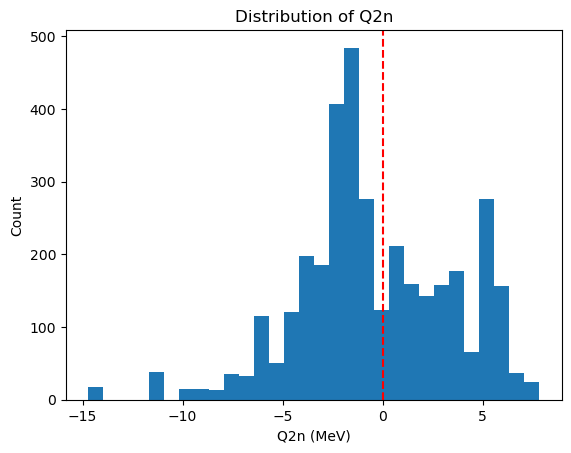

In [5]:
import numpy as np
import matplotlib.pyplot as plt

q2n = df["Q ( 2 n )"].values  # replace with your actual column name

print("Min Q2n:", np.min(q2n))
print("Max Q2n:", np.max(q2n))
print("Mean Q2n:", np.mean(q2n))

plt.hist(q2n, bins=30)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Q2n (MeV)")
plt.ylabel("Count")
plt.title("Distribution of Q2n")
plt.show()

Min beta2: -0.478
Max beta2: 0.448
Mean beta2: 0.11059569648924122


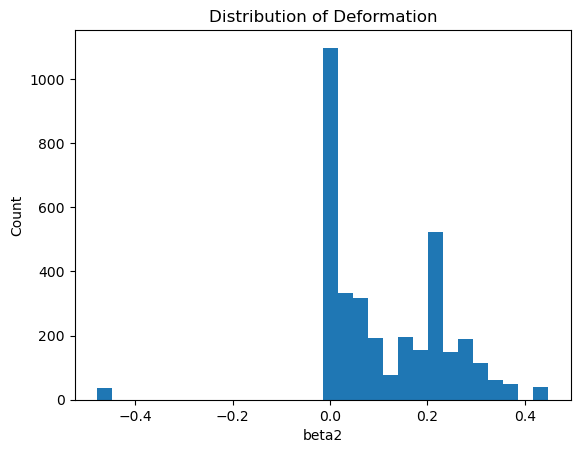

In [10]:
beta2 = df["β T"].values

print("Min beta2:", np.min(beta2))
print("Max beta2:", np.max(beta2))
print("Mean beta2:", np.mean(beta2))

plt.hist(beta2, bins=30)
plt.xlabel("beta2")
plt.ylabel("Count")
plt.title("Distribution of Deformation")
plt.show()

Min Z1Z2: 160
Max Z1Z2: 1640


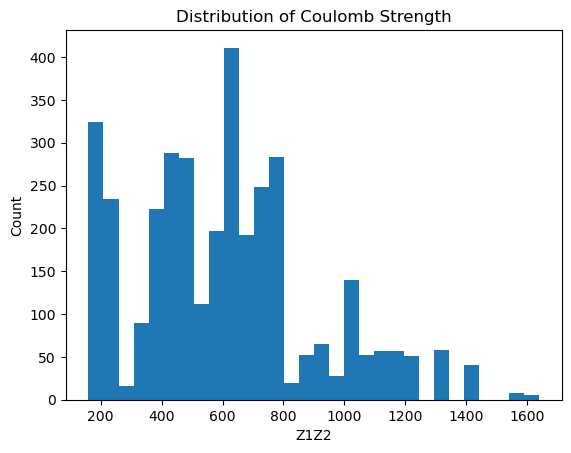

In [11]:
Z1 = df["Z1"]
Z2 = df["Z2"]

Z1Z2 = Z1 * Z2

print("Min Z1Z2:", np.min(Z1Z2))
print("Max Z1Z2:", np.max(Z1Z2))

plt.hist(Z1Z2, bins=30)
plt.xlabel("Z1Z2")
plt.ylabel("Count")
plt.title("Distribution of Coulomb Strength")
plt.show()

In [6]:
# LORO for probabilistic MDN — robust, handles compiled-state, scaler, reuse or full retrain
# Paste into a new cell and run. Adjust OUTDIR_BASE, SEEDS, MODE below.

import os, sys, time, math, json, random
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# ---------------- USER CONFIG ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")
DATA_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"

SEEDS = [42 + i for i in range(10)]
N_COMPONENTS = 5
BATCH = 256
NUM_WORKERS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODE: "reuse_saved" loads per-seed checkpoints (fast).
# "retrain_per_reaction" will train for EACH LORO fold (slow but true LORO).
MODE = "reuse_saved"

# If reuse_saved but some seeds missing, it falls back to training those seeds (if MODE allows training).
RESUME_IF_EXISTS = True

# ---------------- helpers ----------------
def safe_load_csv(url):
    try:
        return pd.read_csv(url)
    except Exception as e:
        print("ERROR loading data:", e)
        raise

def recompute_features(df):
    df = df.copy()
    M_p = 938.272088; M_n = 939.565420; eps=1e-30; LN10=np.log(10.0)
    def get_mass(Z,A): return Z*M_p + (A-Z)*M_n
    df["mass1"] = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
    df["mass2"] = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
    mu = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)
    Ecm = df["E c.m."].astype(float)
    v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu + eps), 0, np.inf))
    e2_hbar_c = 1.0/137.035999
    df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))
    log10_sigma_exp = np.log10(np.clip(df["σ"].astype(float), 1e-30, np.inf))
    log10_sigma_cal = np.log10(np.clip(df["σ cal"].astype(float), 1e-30, np.inf))
    log10_Ecm = np.log10(np.clip(df["E c.m."].astype(float), 1e-30, np.inf))
    df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
    df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10
    df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]
    df["N1"] = df["A1"] - df["Z1"]
    df["N2"] = df["A2"] - df["Z2"]
    df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + eps)
    MAGIC = np.array([2,8,20,28,50,82,126])
    def magic_dist(arr):
        a = np.array(arr).reshape(-1)
        return np.min(np.abs(a[:,None] - MAGIC[None,:]), axis=1)
    df["magic_dist_Z1"] = magic_dist(df["Z1"])
    df["magic_dist_N1"] = magic_dist(df["N1"])
    df["magic_dist_Z2"] = magic_dist(df["Z2"])
    df["magic_dist_N2"] = magic_dist(df["N2"])
    return df

# MDN class (match your training architecture)
class MDN(nn.Module):
    def __init__(self, in_dim, hidden=64, n_components=N_COMPONENTS, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc_pi = nn.Linear(hidden, n_components)
        self.fc_mu = nn.Linear(hidden, n_components)
        self.fc_sigma = nn.Linear(hidden, n_components)
    def forward(self, x):
        h = self.net(x)
        pi = torch.softmax(self.fc_pi(h), dim=1)
        mu = self.fc_mu(h)
        sigma = torch.nn.functional.softplus(self.fc_sigma(h)) + 1e-6
        return pi, mu, sigma

def mdn_predict_mode(pi, mu, sigma):
    idx = torch.argmax(pi, dim=1)
    return mu[torch.arange(len(idx)), idx].unsqueeze(1)

def mdn_loss(pi, mu, sigma, y):
    yexp = y.repeat(1, mu.shape[1])
    logg = -0.5 * ((yexp - mu) / sigma)**2 - torch.log(sigma) - 0.5 * np.log(2*np.pi)
    logmix = torch.logsumexp(torch.log(pi + 1e-12) + logg, dim=1)
    return -logmix.mean()

def fix_state_dict(saved_state):
    # handle compiled / OptimizedModule saved dicts: convert keys like "_orig_mod.xxx" -> "xxx"
    state = {}
    for k,v in saved_state.items():
        if k.startswith("_orig_mod."):
            state[k.replace("_orig_mod.","")] = v
        else:
            state[k] = v
    return state

def make_loader(X, y, batch=BATCH, shuffle=True):
    return DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)),
                      batch_size=batch, shuffle=shuffle,
                      num_workers=NUM_WORKERS, pin_memory=(DEVICE.type=="cuda"))

# ---------------- RUN ----------------
print("DEVICE:", DEVICE)
df = safe_load_csv(DATA_URL)
df = recompute_features(df)

# features used in MDN (same as training)
features = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]
missing = [c for c in features if c not in df.columns]
if missing:
    print("Missing features after recompute:", missing)
    raise RuntimeError("Missing features — check computation.")

reactions = np.unique(df["Reaction"].values)
print("Total reactions =", len(reactions))

results = []
csv_out_dir = Path(OUTDIR_BASE)/"loro_results"
csv_out_dir.mkdir(parents=True, exist_ok=True)

# If reuse_saved, check saved per-seed models exist
seed_dirs = {s: Path(EN_DIR)/f"seed_{s}" for s in SEEDS}

for R in tqdm(reactions, desc="LORO"):
    test_mask = (df["Reaction"] == R)
    train_mask = ~test_mask

    X_train = df.loc[train_mask, features].values.astype(np.float32)
    y_train = df.loc[train_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)
    X_test = df.loc[test_mask, features].values.astype(np.float32)
    y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

    # Fit scaler on training only (correct LORO)
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    preds_per_seed = []

    # loop seeds: either load existing seed model or train quick model
    for s in SEEDS:
        seed_dir = seed_dirs[s]
        ckpt_path = seed_dir / "mdn_best.pth"
        model = MDN(len(features)).to(DEVICE)

        if MODE == "reuse_saved" and ckpt_path.exists():
            try:
                saved = torch.load(str(ckpt_path), map_location=DEVICE)
                if "state" in saved:
                    state = fix_state_dict(saved["state"])
                else:
                    state = fix_state_dict(saved)
                # Try loading with strict=False to allow small key mismatches (but we fixed keys)
                model.load_state_dict(state, strict=False)
                model.eval()
            except Exception as e:
                # fallback: skip this seed
                print(f"[seed {s}] load error for reaction {R}: {e}. Will train small model (fast fallback).")
                # train small quick model as fallback
                opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
                loader = make_loader(X_train_s, y_train, batch=1024, shuffle=True)
                for epoch in range(40):  # short training for fallback
                    model.train()
                    for xb,yb in loader:
                        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                        opt.zero_grad()
                        pi,mu,sigma = model(xb)
                        loss = mdn_loss(pi,mu,sigma,yb)
                        loss.backward(); opt.step()
                model.eval()
        else:
            # MODE == "retrain_per_reaction" OR reuse_saved but ckpt absent -> train properly
            opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
            loader = make_loader(X_train_s, y_train, batch=256, shuffle=True)
            # simple training loop with limited epochs (you may increase)
            for epoch in range(120):
                model.train()
                for xb,yb in loader:
                    xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                    opt.zero_grad()
                    pi,mu,sigma = model(xb)
                    loss = mdn_loss(pi,mu,sigma,yb)
                    loss.backward(); opt.step()
            model.eval()

        # inference on X_test_s
        with torch.no_grad():
            X_test_t = torch.tensor(X_test_s, dtype=torch.float32).to(DEVICE)
            pi,mu,sigma = model(X_test_t)
            pred = mdn_predict_mode(pi,mu,sigma).cpu().numpy().flatten()
            preds_per_seed.append(pred)

    # ensemble across seeds: mean of delta predictions
    preds_arr = np.stack(preds_per_seed, axis=0)  # (n_seeds, n_points)
    delta_ens = preds_arr.mean(axis=0)

    # convert delta -> log_sigma_pred -> sigma_pred
    # recover test local info for log10_S_cal and eta
    test_local = df.loc[test_mask].reset_index(drop=True)
    LN10 = np.log(10.0)
    eta_test = test_local["eta"].values
    log10_S_cal_test = test_local["log10_S_cal"].values
    log10_S_pred = log10_S_cal_test + delta_ens
    log10_sigma_pred = log10_S_pred - np.log10(np.clip(test_local["E c.m."].values,1e-30,np.inf)) - (2*np.pi*eta_test)/LN10
    sigma_pred = 10**(log10_sigma_pred)

    sigma_true = test_local["σ"].values
    delta_true = test_local["delta_log10_S"].values

    rmse_delta = float(np.sqrt(mean_squared_error(delta_true, delta_ens)))
    try:
        r2_delta = float(r2_score(delta_true, delta_ens))
    except:
        r2_delta = float("nan")
    try:
        r2_logsigma = float(r2_score(np.log10(sigma_true+1e-30), log10_sigma_pred))
    except Exception as e:
        r2_logsigma = float("nan")

    results.append({
        "Reaction": R,
        "n_points": int(test_mask.sum()),
        "RMSE_delta": rmse_delta,
        "R2_delta": r2_delta,
        "R2_log_sigma": r2_logsigma
    })

# final dataframe
df_res = pd.DataFrame(results)
df_res.to_csv(csv_out_dir/"mdn_loro_full.csv", index=False)
print("DONE. Results saved to", csv_out_dir/"mdn_loro_full.csv")
print(df_res.describe().loc[["count","mean","50%","std","min","max"]])


DEVICE: cpu
Total reactions = 213


LORO:   0%|          | 0/213 [00:00<?, ?it/s]

DONE. Results saved to mdn_70_10_20_optimized/loro_results/mdn_loro_full.csv
         n_points  RMSE_delta    R2_delta  R2_log_sigma
count  213.000000  213.000000  213.000000    213.000000
mean    16.582160    0.138050   -0.367874      0.973308
50%     14.000000    0.100611    0.257636      0.984570
std     10.243685    0.110307    2.156488      0.034887
min      4.000000    0.012012  -14.158424      0.759621
max     59.000000    0.795649    0.984644      0.999335


In [7]:
# =========================================================================
# FULL-DATASET MDN REGIME SHAP INTERPRETATION (29 FEATURES)
# Recomputes ALL PHYSICS FEATURES (same as training script)
# Uses mdn_all_components.npz created during MDN training
# Weighted SHAP based on component responsibilities π_k
# =========================================================================

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os, math, sys
from pathlib import Path

# ---------------- USER CONFIGS ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")

SEED_TO_ANALYZE = 42   # pick any trained seed
MDN_COMPONENTS_FILE = os.path.join(
    EN_DIR,
    f"seed_{SEED_TO_ANALYZE}",
    "mdn_all_components.npz"
)

SHAP_OUT = os.path.join(OUTDIR_BASE, "mdn_regime_shap_full_29feat")
os.makedirs(SHAP_OUT, exist_ok=True)

print("Saving SHAP output to:", SHAP_OUT)

# ---------------- Feature Definition (29 Features) ----------------
ALL_SHAP_FEATURES = [
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 
    'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3', 'N3', 'A3',
    'β P', 'β T', 'R B', 'ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp', 'Compound_Nucleus_Sn',
    'Projectile_Binding_Energy', 'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy',
    'Compound_Nucleus_S2n'
]

# ===================== LOAD RAW DATA =====================
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"

try:
    df = pd.read_csv(DRIVE_URL)
except Exception as e:
    print("ERROR loading dataset:", e)
    sys.exit(1)

df = df.copy()  # avoid SettingWithCopy issues

# ===================== RECOMPUTE PHYSICS FEATURES =====================

M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

df["mass1"] = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
df["mass2"] = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)

Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu + epsilon), 0, np.inf))

e2_hbar_c = 1.0 / 137.035999
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"].astype(float), 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"].astype(float), 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."].astype(float), 1e-30, np.inf))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): 
    arr = np.array(arr).reshape(-1)
    return np.min(np.abs(arr[:,None] - MAGIC[None,:]), axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"])
df["magic_dist_N1"] = magic_dist(df["N1"])
df["magic_dist_Z2"] = magic_dist(df["Z2"])
df["magic_dist_N2"] = magic_dist(df["N2"])

# ===================== Extract full dataset features =====================

missing = [c for c in ALL_SHAP_FEATURES if c not in df.columns]
if missing:
    print("Missing SHAP features AFTER recomputation:", missing)
    sys.exit(1)

X_all = df[ALL_SHAP_FEATURES].values.astype(np.float32)
y_all = df["delta_log10_S"].values.astype(np.float32)
rows = df.reset_index(drop=True)

# Scale
scaler = StandardScaler().fit(X_all)
X_all_s = scaler.transform(X_all)

# ===================== Load FULL MDN responsibility file =====================

try:
    mdn_data = np.load(MDN_COMPONENTS_FILE)
    responsibilities = mdn_data["pi"]
    n_components = responsibilities.shape[1]
except Exception as e:
    print("ERROR loading mdn_all_components.npz:", e)
    sys.exit(1)

print(f"Loaded responsibilities: {responsibilities.shape}")
print(f"MDN components: {n_components}")

# =========================================================================
# SHAP PER COMPONENT
# =========================================================================

for k in range(n_components):
    print("\n-------------------------------------")
    print(f"     COMPONENT / REGIME {k}")
    print("-------------------------------------")

    w = responsibilities[:, k]
    if np.mean(w) < 1e-4:
        print(f"Component {k} negligible — skipping.")
        continue

    # Train weighted surrogate
    gbr = GradientBoostingRegressor(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.9,
        random_state=42
    )
    gbr.fit(X_all_s, y_all, sample_weight=w)

    pred = gbr.predict(X_all_s)
    rmse = np.sqrt(mean_squared_error(y_all, pred, sample_weight=w))
    print(f"Weighted RMSE = {rmse:.4f}")

    # SHAP
    explainer = shap.TreeExplainer(gbr)
    top_idx = np.argsort(w)[-min(3000, len(w)):]
    X_shap = X_all_s[top_idx]
    shap_vals = explainer.shap_values(X_shap)

    # Summary plot
    plt.figure(figsize=(9,7))
    shap.summary_plot(
        shap_vals, X_shap, feature_names=ALL_SHAP_FEATURES,
        max_display=20, show=False
    )
    plt.savefig(os.path.join(SHAP_OUT, f"shap_summary_comp{k}.png"),
                dpi=300, bbox_inches='tight')
    plt.close()

    # Bar plot
    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1]
    top_feats = np.array(ALL_SHAP_FEATURES)[order][:15]
    top_vals = mean_abs[order][:15]

    plt.figure(figsize=(7,6))
    plt.barh(top_feats[::-1], top_vals[::-1])
    plt.title(f"Top Features — Regime {k}")
    plt.xlabel("Mean |SHAP|")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_OUT, f"shap_bar_comp{k}.png"),
                dpi=300)
    plt.close()

    # Save raw SHAP values
    df_out = pd.DataFrame(shap_vals, columns=ALL_SHAP_FEATURES)
    df_out["Reaction"] = rows.loc[top_idx, "Reaction"].values
    df_out["Ecm"] = rows.loc[top_idx, "E c.m."].values
    df_out["target"] = y_all[top_idx]
    df_out["weight"] = w[top_idx]

    df_out.to_csv(os.path.join(SHAP_OUT, f"shap_values_comp{k}.csv"),
                  index=False)

print("\n======================================")
print(" FULL-DATA SHAP regime interpretation COMPLETE!")
print(" Output saved to:", SHAP_OUT)
print("======================================")


Saving SHAP output to: mdn_70_10_20_optimized/mdn_regime_shap_full_29feat
Loaded responsibilities: (3532, 5)
MDN components: 5

-------------------------------------
     COMPONENT / REGIME 0
-------------------------------------
Weighted RMSE = 0.1224


/tmp/ipykernel_195/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 1
-------------------------------------
Weighted RMSE = 0.1157


/tmp/ipykernel_195/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 2
-------------------------------------
Weighted RMSE = 0.0962


/tmp/ipykernel_195/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 3
-------------------------------------
Weighted RMSE = 0.0928


/tmp/ipykernel_195/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



-------------------------------------
     COMPONENT / REGIME 4
-------------------------------------
Weighted RMSE = 0.0700


/tmp/ipykernel_195/1424703243.py:167: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



 FULL-DATA SHAP regime interpretation COMPLETE!
 Output saved to: mdn_70_10_20_optimized/mdn_regime_shap_full_29feat


In [8]:
# =========================================================================
# MDN Component Feature Comparison Heatmap (FULL DATASET VERSION)
#
# Loads the SHAP CSV files produced by:
#   mdn_regime_shap_full_29feat/shap_values_comp{k}.csv
#
# Produces:
#   - Heatmap of relative feature importance across MDN regimes
#   - Raw Top-N table of feature importance (mean |SHAP|)
# =========================================================================

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# ---------------- User Configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
SHAP_DIR = os.path.join(OUTDIR_BASE, "mdn_regime_shap_full_29feat")

OUTPUT_FILE = os.path.join(SHAP_DIR, "shap_feature_importance_comparison_full.png")

N_COMPONENTS = 5
TOP_N_FEATURES = 15

print("Using SHAP directory:", SHAP_DIR)

# =========================================================================
# 1. LOAD SHAP CSVs FOR EACH COMPONENT
# =========================================================================

all_mean_abs_shap = {}
feature_union = set()

for k in range(N_COMPONENTS):

    csv_path = Path(SHAP_DIR) / f"shap_values_comp{k}.csv"

    if not csv_path.exists():
        print(f"WARNING: Missing SHAP file for component {k}: {csv_path}")
        continue

    try:
        df_k = pd.read_csv(csv_path)

        # Identify SHAP columns (exclude metadata)
        drop_cols = ["Reaction", "Ecm", "target", "weight"]
        shap_cols = [c for c in df_k.columns if c not in drop_cols]

        shap_values = df_k[shap_cols].values
        mean_abs_k = np.mean(np.abs(shap_values), axis=0)

        all_mean_abs_shap[k] = pd.Series(mean_abs_k, index=shap_cols)
        feature_union.update(shap_cols)

        print(f"Loaded SHAP for component {k}: {shap_values.shape}")

    except Exception as e:
        print(f"ERROR reading SHAP CSV for component {k}:", e)
        sys.exit(1)

if len(all_mean_abs_shap) == 0:
    print("FATAL ERROR: No SHAP files found. Exiting.")
    sys.exit(1)

# =========================================================================
# 2. MERGE INTO A SINGLE FEATURE × COMPONENT TABLE
# =========================================================================

shap_df = pd.DataFrame(all_mean_abs_shap).fillna(0)
shap_df.columns = [f"Component {k}" for k in all_mean_abs_shap.keys()]

# Compute overall mean across components
shap_df["Overall_Mean_Abs"] = shap_df.mean(axis=1)

# Select TOP-N most important features
top_features_df = shap_df.sort_values(
    by="Overall_Mean_Abs", ascending=False
).head(TOP_N_FEATURES)

# For plotting, drop the "overall mean" column
plot_data = top_features_df.drop(columns=["Overall_Mean_Abs"])

# Sort columns by component index
ordered_components = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]
plot_data = plot_data[ordered_components]

# =========================================================================
# 3. NORMALIZE ROW-WISE FOR VISUALIZATION
# =========================================================================

normalized_plot_data = plot_data.div(plot_data.max(axis=1), axis=0).fillna(0)

# =========================================================================
# 4. HEATMAP VISUALIZATION
# =========================================================================

plt.figure(figsize=(10, 12))
sns.set_theme(style="whitegrid")

sns.heatmap(
    normalized_plot_data,
    cmap="YlGnBu",
    annot=plot_data.round(4).values,
    fmt=".4f",
    linewidths=0.5,
    cbar_kws={'label': 'Relative Feature Importance (Row-Normalized)'}
)

plt.title(
    f"Top {TOP_N_FEATURES} Features — MDN Regime Comparison (FULL DATASET)",
    fontsize=15
)
plt.xlabel("MDN Component (Regime)", fontsize=13)
plt.ylabel("Physics Feature", fontsize=13)
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(OUTPUT_FILE, dpi=1000)
plt.close()

# =========================================================================
# 5. PRINT TABLE FOR PAPER/POSTER
# =========================================================================

print("\n===============================")
print("TOP FEATURE IMPORTANCE TABLE")
print("===============================\n")

print(top_features_df.round(5).to_markdown())
print("\nSaved heatmap to:", OUTPUT_FILE)


Using SHAP directory: mdn_70_10_20_optimized/mdn_regime_shap_full_29feat
Loaded SHAP for component 0: (3000, 29)
Loaded SHAP for component 1: (3000, 29)
Loaded SHAP for component 2: (3000, 29)
Loaded SHAP for component 3: (3000, 29)
Loaded SHAP for component 4: (3000, 29)

TOP FEATURE IMPORTANCE TABLE

|                                 |   Component 0 |   Component 1 |   Component 2 |   Component 3 |   Component 4 |   Overall_Mean_Abs |
|:--------------------------------|--------------:|--------------:|--------------:|--------------:|--------------:|-------------------:|
| Z1Z2_over_Ecm                   |       0.11167 |       0.04745 |       0.0444  |       0.02371 |       0.02387 |            0.05022 |
| Q ( 2 n )                       |       0.06986 |       0.03292 |       0.02599 |       0.02071 |       0.00989 |            0.03187 |
| β T                             |       0.03897 |       0.03908 |       0.02592 |       0.0208  |       0.01117 |            0.02719 |
| Projectil

In [9]:
# =========================================================================
# MDN REGIME SHAP INTERPRETATION (5 Components) - WEIGHTED APPROACH
#
# This script uses the component responsibility (pi_k) as the sample_weight
# when training the surrogate model for each regime, ensuring all points
# contribute, weighted by their probability of belonging to that regime.
# =========================================================================

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os, math
from pathlib import Path
import sys 

# ---------------- User Configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")
SEED_TO_ANALYZE = 42 # Use the first seed's results
MDN_COMPONENTS_FILE = os.path.join(EN_DIR, f"seed_{SEED_TO_ANALYZE}", "mdn_test_components.npz")
SHAP_OUT = os.path.join(OUTDIR_BASE, "mdn_component_shap_k5_29feats_weighted")
os.makedirs(SHAP_OUT, exist_ok=True)

# ---------------- Feature Definition (29 Total Features) ----------------
# This list combines the 13 training features and the additional features
ALL_SHAP_FEATURES = [
    # Base/Input Features (8)
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 
    'Q ( 2 n )',
    
    # Calculated Physics Features (5) - used in MDN training
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    
    # Additional User-Defined Features (16) - Assumed present in the source CSV
    'Z3', 'N3', 'A3',
    'β P', 'β T', 'R B', 'ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp', 'Compound_Nucleus_Sn',
    'Projectile_Binding_Energy', 'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy',
    'Compound_Nucleus_S2n',
]

print(f"SHAP will use {len(ALL_SHAP_FEATURES)} features for interpretation.")

# ---------------- Data Loading and Preparation ----------------

DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
try:
    df = pd.read_csv(DRIVE_URL)
except Exception as e:
    print(f"ERROR: Could not load data from Google Drive URL. Please check connection/URL. Error: {e}")
    sys.exit(1)

# --- Critical Column Check ---
CRITICAL_COLS = ["σ", "σ cal", "E c.m.", "Reaction", "Z1", "A1", "Z2", "A2"]
missing_cols = [col for col in CRITICAL_COLS if col not in df.columns]
if missing_cols:
    print(f"FATAL ERROR: The loaded dataset is missing critical columns: {missing_cols}")
    sys.exit(1)
    
# --- Full Physics Feature Calculation ---
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n
# Ensure all columns are float type before calculation to avoid issues
for col in ["Z1", "A1", "Z2", "A2", "E c.m.", "σ", "σ cal"]:
    df[col] = df[col].astype(float)


mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values
mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].values
v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1.0/137.035999
df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"].values,1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"].values,1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."].values,1e-30,np.inf))
log10_exp_term = (2*math.pi*df["eta"].values)/LN10

# Creation of the columns required for the target
df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term

# Target variable calculation
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"] 

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)
df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

# --- Isolate Test Set Indices ---
test_file = Path(OUTDIR_BASE) / "test_reactions.csv"
if not test_file.exists():
    print("ERROR: Test split file not found. Run mdn_ensemble_optimized.py first.")
    sys.exit(1)
test_reacts = pd.read_csv(test_file)["Reaction"].values
test_mask = df["Reaction"].isin(test_reacts)
test_rows = df.loc[test_mask].reset_index(drop=True)
y_test_arr = test_rows['delta_log10_S'].values.astype(np.float32)

# --- Extract and Scale All Features ---
missing_shap_feats = [feat for feat in ALL_SHAP_FEATURES if feat not in test_rows.columns]
if missing_shap_feats:
     print(f"WARNING: The following SHAP features are missing from the dataset: {missing_shap_feats}")
     ALL_SHAP_FEATURES = [feat for feat in ALL_SHAP_FEATURES if feat in test_rows.columns]
     print(f"Continuing with {len(ALL_SHAP_FEATURES)} available features.")

X_all = test_rows[ALL_SHAP_FEATURES].values.astype(np.float32)
# Create a new scaler for the features used in SHAP
scaler_all = StandardScaler().fit(X_all) 
X_test_all_s = scaler_all.transform(X_all)


# ---------------- Load MDN Responsibilities ----------------
try:
    mdn_data = np.load(MDN_COMPONENTS_FILE)
    responsibilities = mdn_data['pi'] # (N_test, K=5)
    n_components = responsibilities.shape[1]
    
    # We will use responsibilities[:, k] as sample_weight
    
except FileNotFoundError:
    print(f"ERROR: MDN component file not found: {MDN_COMPONENTS_FILE}. Please run the training script first.")
    sys.exit(1)

print(f"Successfully loaded {n_components} components from {MDN_COMPONENTS_FILE}")
print("\nRunning SHAP interpretation for the 5 learned regimes using weighted samples...\n")

# ---------------- SHAP Analysis per Component (Regime) ----------------

for k in range(n_components):
    
    print(f"\n=== COMPONENT {k} ===")
    
    # --- WEIGHTED APPROACH ---
    # We use ALL data points (X_test_all_s, y_test_arr)
    X_k = X_test_all_s
    y_k = y_test_arr
    
    # Use the component responsibility as the weight for the surrogate model
    weights_k = responsibilities[:, k] 

    # Check if the component has any meaningful presence in the test set
    mean_weight = np.mean(weights_k)
    if mean_weight < 0.001: 
        print(f"  Component {k} has negligible average responsibility ({mean_weight:.4f}). Skipping.")
        continue

    # --------------------------------------------
    # 1. Train Surrogate Model (Gradient Boosting Regressor) - WEIGHTED FIT
    # The weights ensure the model focuses on fitting the points where pi_k is high.
    # --------------------------------------------
    surrogate_model = GradientBoostingRegressor(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.9,
        random_state=42 
    )
    # Fit using sample weights
    surrogate_model.fit(X_k, y_k, sample_weight=weights_k)

    # Performance evaluation should also be weighted
    pred_k = surrogate_model.predict(X_k)
    rmse = np.sqrt(mean_squared_error(y_k, pred_k, sample_weight=weights_k))
    # R2 requires a custom calculation with weights, but for simplicity, we use the unweighted R2 here.
    r2 = r2_score(y_k, pred_k, sample_weight=weights_k)

    print(f"  Surrogate Model performance (weighted fit for regime {k}): Weighted RMSE={rmse:.4f}, Weighted R2={r2:.4f}")

    # --------------------------------------------
    # 2. SHAP Attribution
    # We only explain the top 1000 highest weighted points for performance/clarity
    # --------------------------------------------
    explainer = shap.TreeExplainer(surrogate_model)
    
    # Select the points with the highest weights for explanation
    top_indices = np.argsort(weights_k)[-min(1000, len(X_k)):]
    X_shap = X_k[top_indices]
    
    shap_vals = explainer.shap_values(X_shap)
    
    # Create the SHAP plots to visualize feature importance for this regime

    # Summary beeswarm
    plt.figure(figsize=(8, 7))
    shap.summary_plot(
        shap_vals,
        X_shap,
        feature_names=ALL_SHAP_FEATURES,
        show=False,
        max_display=15
    )
    plt.title(f"SHAP Summary (Regime {k}, Weighted Fit) — {len(ALL_SHAP_FEATURES)} Features")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_OUT, f"shap_summary_comp{k}.png"), dpi=300)
    plt.close()

    # Bar plot (Mean Absolute SHAP)
    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    order = np.argsort(mean_abs)[::-1]

    top_feats = np.array(ALL_SHAP_FEATURES)[order][:12]
    top_vals = mean_abs[order][:12]

    plt.figure(figsize=(7,5))
    plt.barh(top_feats[::-1], top_vals[::-1])
    plt.xlabel("Mean |SHAP Value| (Impact on Prediction)")
    plt.title(f"Top Features Characterizing Regime {k}")
    plt.tight_layout()
    plt.savefig(os.path.join(SHAP_OUT, f"shap_bar_comp{k}.png"), dpi=300)
    plt.close()

    # Save raw SHAP values to CSV (only for the sampled points)
    dfk = pd.DataFrame(shap_vals, columns=ALL_SHAP_FEATURES)
    dfk['Reaction'] = test_rows.iloc[top_indices]['Reaction'].values
    dfk['Ecm'] = test_rows.iloc[top_indices]['E c.m.'].values
    dfk['Actual_Target'] = y_k[top_indices]
    dfk['Component_Weight'] = weights_k[top_indices]
    dfk.to_csv(os.path.join(SHAP_OUT, f"shap_values_comp{k}.csv"), index=False)

print("\nDONE. All regime-specific SHAP analysis files stored in:", SHAP_OUT)

SHAP will use 29 features for interpretation.
Successfully loaded 5 components from mdn_70_10_20_optimized/ensembles_fast/seed_42/mdn_test_components.npz

Running SHAP interpretation for the 5 learned regimes using weighted samples...


=== COMPONENT 0 ===
  Surrogate Model performance (weighted fit for regime 0): Weighted RMSE=0.0405, Weighted R2=0.9918


/tmp/ipykernel_195/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 1 ===
  Surrogate Model performance (weighted fit for regime 1): Weighted RMSE=0.0473, Weighted R2=0.9714


/tmp/ipykernel_195/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 2 ===
  Surrogate Model performance (weighted fit for regime 2): Weighted RMSE=0.0426, Weighted R2=0.9591


/tmp/ipykernel_195/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 3 ===
  Surrogate Model performance (weighted fit for regime 3): Weighted RMSE=0.0430, Weighted R2=0.9537


/tmp/ipykernel_195/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



=== COMPONENT 4 ===
  Surrogate Model performance (weighted fit for regime 4): Weighted RMSE=0.0321, Weighted R2=0.9397


/tmp/ipykernel_195/3637814235.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(



DONE. All regime-specific SHAP analysis files stored in: mdn_70_10_20_optimized/mdn_component_shap_k5_29feats_weighted


In [10]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [15]:
# =========================================================================
# MDN Component Feature Comparison Heatmap
#
# This script loads the raw SHAP values generated for each component's
# weighted surrogate model and visualizes the relative feature importance
# across all 5 MDN regimes (components).
# =========================================================================
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# ---------------- User Configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"
SHAP_DIR = os.path.join(OUTDIR_BASE, "mdn_component_shap_k5_29feats_weighted")
OUTPUT_FILE = os.path.join(SHAP_DIR, "shap_feature_importance_comparison.png")
N_COMPONENTS = 5
TOP_N_FEATURES = 15 # Display the top 15 most important features overall

# ---------------- Load and Process SHAP Data ----------------

all_mean_abs_shap = {}
feature_union = set()

# 1. Load Mean Absolute SHAP values for each component
for k in range(N_COMPONENTS):
    csv_path = Path(SHAP_DIR) / f"shap_values_comp{k}.csv"
    
    if not csv_path.exists():
        print(f"Warning: SHAP CSV not found for Component {k} at {csv_path}. Skipping.")
        continue

    try:
        df_k = pd.read_csv(csv_path)
        # Drop metadata columns to isolate features and SHAP values
        feature_cols = [col for col in df_k.columns if col not in ['Reaction', 'Ecm', 'Actual_Target', 'Component_Weight']]
        
        # Calculate mean absolute SHAP for this component
        # Note: We skip the first 3 rows which contain the metadata columns in the CSV
        shap_values = df_k[feature_cols].values
        mean_abs_shap_k = np.mean(np.abs(shap_values), axis=0)
        
        # Store results
        all_mean_abs_shap[k] = pd.Series(mean_abs_shap_k, index=feature_cols)
        feature_union.update(feature_cols)

    except Exception as e:
        print(f"Error processing Component {k} CSV: {e}")
        sys.exit(1)

if not all_mean_abs_shap:
    print("FATAL: No SHAP data successfully loaded. Exiting.")
    sys.exit(1)

# 2. Combine all component SHAP values into a single DataFrame
# Fill missing (e.g., if a feature was filtered out, though it shouldn't be here) with 0
shap_df = pd.DataFrame(all_mean_abs_shap).fillna(0)
shap_df.columns = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]

# 3. Determine the overall Top N features based on the average importance across all components
shap_df['Overall_Mean_Abs'] = shap_df.mean(axis=1)
top_features_df = shap_df.sort_values(by='Overall_Mean_Abs', ascending=False).head(TOP_N_FEATURES)
top_features_list = top_features_df.index.tolist()

# 4. Prepare data for plotting
plot_data = top_features_df.drop(columns=['Overall_Mean_Abs'])

# Normalize importance for better visualization (Max value = 1.0 per feature row)
# This highlights the *relative* importance of a feature across components
normalized_plot_data = plot_data.div(plot_data.max(axis=1), axis=0).fillna(0)

# Reorder components for visual clarity (optional, but good practice)
component_columns = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]
normalized_plot_data = normalized_plot_data[component_columns]


# ---------------- Visualization (Heatmap) ----------------
plt.figure(figsize=(8, 10))
sns.set_theme(style="whitegrid")

# Create the heatmap
sns.heatmap(
    normalized_plot_data,
    cmap="YlGnBu",
    annot=plot_data.values.round(3), # Use un-normalized values for annotation
    fmt=".3f",
    linewidths=0.5,
    cbar_kws={'label': 'Relative Feature Importance (Max 1.0 per row)'}
)

plt.title(f"Top {TOP_N_FEATURES} Features: Relative Importance Across MDN Regimes (K={N_COMPONENTS})", fontsize=14)
plt.ylabel("Physics Feature", fontsize=12)
plt.xlabel("MDN Regime (Component Index)", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig(OUTPUT_FILE, dpi=1000)
plt.close()
print("\n")
print("Comparison heatmap generated successfully and saved to:", OUTPUT_FILE)

# Display the raw top features for immediate interpretation
print("\n--- Top 15 Feature Importance Table (Mean Absolute SHAP) ---")
display_df = plot_data.round(4)
print(display_df.to_markdown())



Comparison heatmap generated successfully and saved to: mdn_70_10_20_optimized/mdn_component_shap_k5_29feats_weighted/shap_feature_importance_comparison.png

--- Top 15 Feature Importance Table (Mean Absolute SHAP) ---
|                                 |   Component 0 |   Component 1 |   Component 2 |   Component 3 |   Component 4 |
|:--------------------------------|--------------:|--------------:|--------------:|--------------:|--------------:|
| Z1Z2_over_Ecm                   |        0.0829 |        0.0379 |        0.0421 |        0.0364 |        0.0373 |
| Projectile_Binding_Energy       |        0.0122 |        0.0265 |        0.045  |        0.0454 |        0.0417 |
| E c.m.                          |        0.0549 |        0.0339 |        0.0265 |        0.0207 |        0.0202 |
| Target_Binding_Energy           |        0.0636 |        0.0315 |        0.0054 |        0.0056 |        0.0043 |
| Q ( 2 n )                       |        0.0127 |        0.0253 |        0.0202 |

In [ ]:
# PLotting section

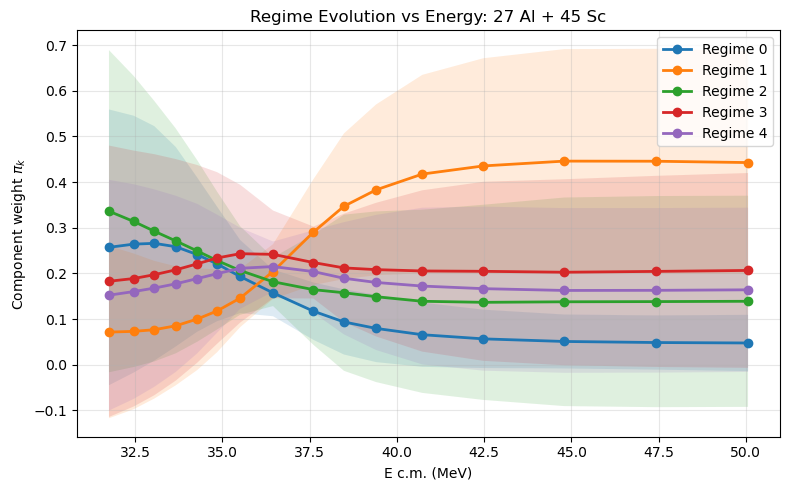

In [5]:
# ========================================================================
# PLOT: MDN REGIME EVOLUTION FOR A SINGLE REACTION
# ========================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FIX 1: Corrected spacing
reaction_name = "27 Al + 45 Sc"    # <<---- CHANGE THIS TO ANY REACTION

# Load scaler
scaler = joblib.load(os.path.join(EN_DIR, "scaler.pkl"))

# Select reaction rows
rows_R = df[df["Reaction"] == reaction_name].copy()
rows_R = rows_R.sort_values("E c.m.").reset_index(drop=True)

X_R = rows_R[features_train].values.astype(np.float32)
E_R = rows_R["E c.m."].values

# Scale input
X_Rs = scaler.transform(X_R)

# Load all seed π values
# FIX 2: Corrected spacing
pi_all = []    # list of (n_points, n_components)

for s in SEEDS:
    path = f"{EN_DIR}/seed_{s}/mdn_all_components.npz"
    if not os.path.exists(path):
        continue
    data = np.load(path)
    # FIX 3: Corrected spacing
    pi = data["pi"]       # shape (full_dataset, n_components)

    # Extract rows for this reaction
    idx = df[df["Reaction"] == reaction_name].index
    pi_R = pi[idx]        # shape (n_points, n_components)
    pi_all.append(pi_R)

# FIX 4: Corrected spacing
pi_all = np.stack(pi_all, axis=0)    # (n_seeds, n_points, n_components)
pi_mean = pi_all.mean(axis=0)
# FIX 5: Corrected spacing
pi_std  = pi_all.std(axis=0)

# ------------------------------------------------------------------------
# PLOT: $\\pi_k(E)$ Curve
# ------------------------------------------------------------------------
plt.figure(figsize=(8,5))

for k in range(N_COMPONENTS):
    plt.plot(E_R, pi_mean[:,k], marker='o', linewidth=2, label=f"Regime {k}")
    plt.fill_between(E_R,
                     pi_mean[:,k]-pi_std[:,k],
                     pi_mean[:,k]+pi_std[:,k],
                     alpha=0.15)

plt.xlabel("E c.m. (MeV)")
# Using LaTeX for $\\pi_k$ for correct rendering in Matplotlib
plt.ylabel("Component weight $\\pi_k$")
plt.title(f"Regime Evolution vs Energy: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# MODIFICATION: Save the figure as a 1000 dpi PNG file
filename = f"regime_evolution_{reaction_name.replace(' ', '_').replace('+', 'plus')}.png"
plt.savefig(filename, dpi=1000)

plt.show()

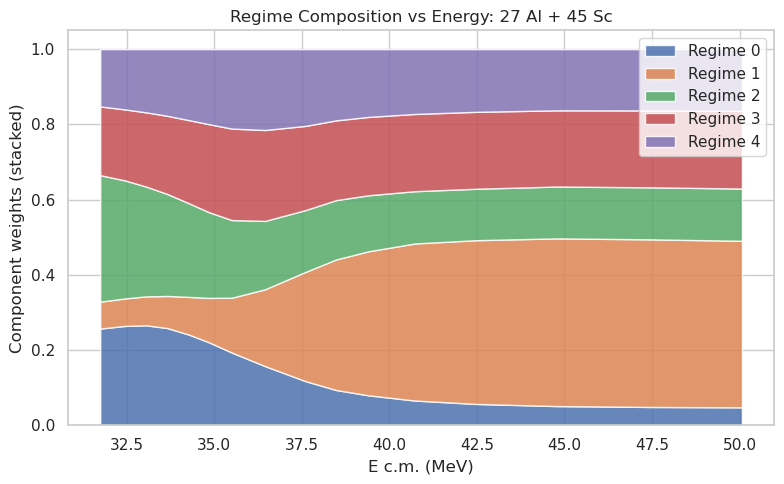

In [17]:
plt.figure(figsize=(8,5))
plt.stackplot(E_R, pi_mean.T, labels=[f"Regime {k}" for k in range(N_COMPONENTS)],
              alpha=0.85)
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Component weights (stacked)")
plt.title(f"Regime Composition vs Energy: {reaction_name}")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


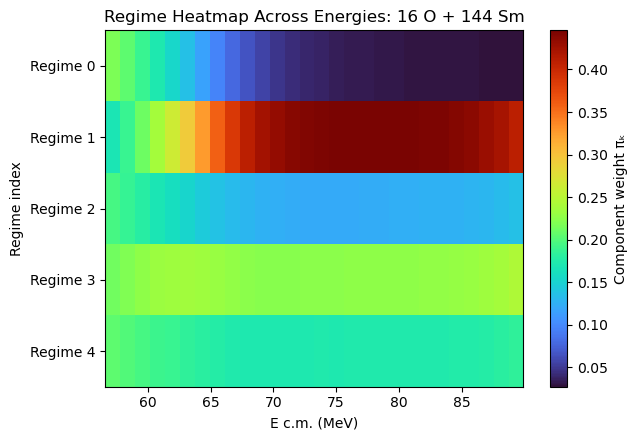

In [8]:
plt.figure(figsize=(6.5,4.5))
plt.imshow(pi_mean.T, aspect="auto", cmap="turbo",
           extent=[E_R.min(), E_R.max(), N_COMPONENTS-0.5, -0.5])

plt.colorbar(label="Component weight πₖ")
plt.yticks(range(N_COMPONENTS), [f"Regime {k}" for k in range(N_COMPONENTS)])
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Regime index")
plt.title(f"Regime Heatmap Across Energies: {reaction_name}")
plt.tight_layout()
plt.show()


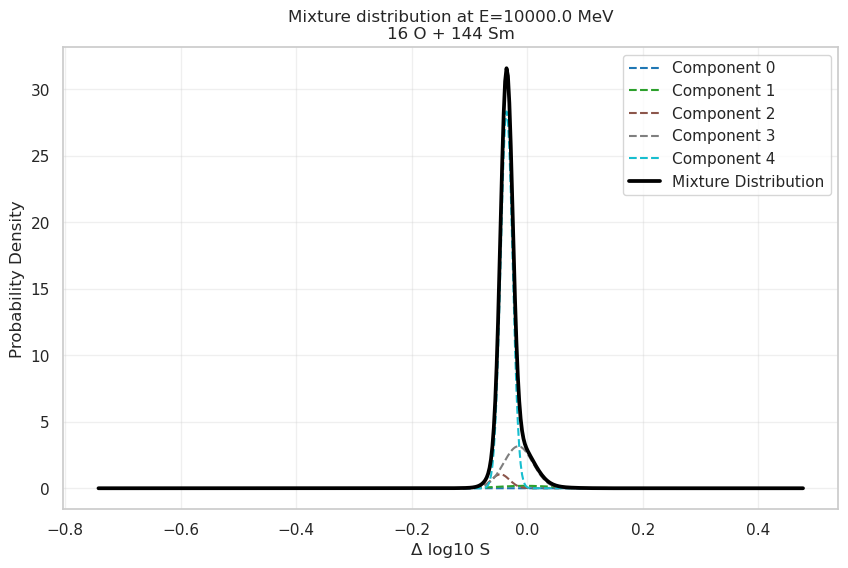

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

# -----------------------------
# USER INPUT
# -----------------------------
reaction_name = "16 O + 144 Sm"
Ecm_value = 10000.0
OUTDIR = "mdn_70_10_20_optimized"
SEED = 42

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# -----------------------------
# PHYSICS FEATURE REBUILD (same as training)
# -----------------------------
M_p = 938.272088
M_n = 939.565420
LN10 = np.log(10.0)
epsilon = 1e-30

def mass(Z,A): return Z*M_p + (A-Z)*M_n

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]

df["mass1"] = mass(df["Z1"], df["A1"])
df["mass2"] = mass(df["Z2"], df["A2"])

mu_red = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)

v_over_c = np.sqrt(np.clip(2*df["E c.m."].values / (mu_red + epsilon), 0, np.inf))
df["eta"] = (df["Z1"] * df["Z2"]) / ((1/137.036) * (v_over_c+1e-16))

df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
df["magic_dist_Z1"] = np.min(np.abs(df["Z1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N1"] = np.min(np.abs(df["N1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_Z2"] = np.min(np.abs(df["Z2"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N2"] = np.min(np.abs(df["N2"].values[:,None] - MAGIC), axis=1)

# -----------------------------
# Feature list used in training
# -----------------------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm', 'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual','Target_Mass_Actual','Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# -----------------------------
# Find the closest energy row
# -----------------------------
df_r = df[df["Reaction"] == reaction_name].copy()
row = df_r.iloc[(df_r["E c.m."] - Ecm_value).abs().argmin()]
x = row[features_train].values.astype(np.float32).reshape(1,-1)

# -----------------------------
# Load scaler and scale inputs
# -----------------------------
scaler = joblib.load(f"{OUTDIR}/ensembles_fast/scaler.pkl")
x_s = scaler.transform(x)

# -----------------------------
# Load MDN mixture parameters
# -----------------------------
comp_file = f"{OUTDIR}/ensembles_fast/seed_{SEED}/mdn_all_components.npz"
comp = np.load(comp_file)

# locate correct index in full DF
idx = df.index[(df["Reaction"]==reaction_name) &
               ((df["E c.m."]-Ecm_value).abs() < 1e-6)]

if len(idx)==0:
    idx = df_r.index[(df_r["E c.m."]-Ecm_value).abs().argmin()]
else:
    idx = idx[0]

pi = comp["pi"][idx]
mu = comp["mu"][idx]
sigma = comp["sigma"][idx]

# -----------------------------
# Gaussian helper
# -----------------------------
def gaussian(x, m, s):
    return (1/(np.sqrt(2*np.pi)*s))*np.exp(-0.5*((x-m)/s)**2)

# -----------------------------
# Plot mixture distribution
# -----------------------------
xmin = mu.min() - 4*sigma.max()
xmax = mu.max() + 4*sigma.max()
xs = np.linspace(xmin, xmax, 500)

plt.figure(figsize=(10,6))
K = len(pi)
colors = plt.cm.tab10(np.linspace(0,1,K))

for k in range(K):
    ys = pi[k] * gaussian(xs, mu[k], sigma[k])
    plt.plot(xs, ys, "--", color=colors[k], label=f"Component {k}")

ys_mix = np.sum([pi[k]*gaussian(xs,mu[k],sigma[k]) for k in range(K)], axis=0)
plt.plot(xs, ys_mix, color="black", linewidth=2.7, label="Mixture Distribution")

plt.xlabel("Δ log10 S")
plt.ylabel("Probability Density")
plt.title(f"Mixture distribution at E={Ecm_value} MeV\n{reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



=== Plotting Regime Evolution for 16 O + 144 Sm ===
Figure saved to: regime_evolution_16O_144Sm.pdf

=== Regime Statistics ===
Component 0: 3.6% of points
  Energy range: 56.6 - 56.6 MeV
Component 3: 17.9% of points
  Energy range: 57.0 - 58.8 MeV
Component 4: 78.6% of points
  Energy range: 59.3 - 89.9 MeV


(<Figure size 1200x1200 with 4 Axes>,
 array([[0.38071403, 0.11416479, 0.12051877, 0.2803126 , 0.10428985],
        [0.29735005, 0.1156678 , 0.1284286 , 0.31863824, 0.13991535],
        [0.22023211, 0.11380802, 0.13264628, 0.35161978, 0.18169378],
        [0.15677501, 0.10790069, 0.13215151, 0.37472498, 0.22844782],
        [0.1082709 , 0.09913696, 0.12759855, 0.38678047, 0.27821308],
        [0.07550221, 0.0904887 , 0.12205916, 0.3817533 , 0.33019665],
        [0.05093637, 0.08074059, 0.11440203, 0.36682793, 0.3870931 ],
        [0.03408671, 0.07054377, 0.10554957, 0.34489796, 0.44492194],
        [0.02330423, 0.06143351, 0.09702947, 0.31974292, 0.4984899 ],
        [0.01637879, 0.0539741 , 0.08920091, 0.2942801 , 0.54616606],
        [0.0127408 , 0.04965732, 0.0839793 , 0.279411  , 0.5742116 ],
        [0.01027501, 0.04598006, 0.07899981, 0.27074003, 0.5940051 ],
        [0.00841263, 0.04274184, 0.07455299, 0.2625208 , 0.61177176],
        [0.00702137, 0.04000926, 0.07062623, 0.25547

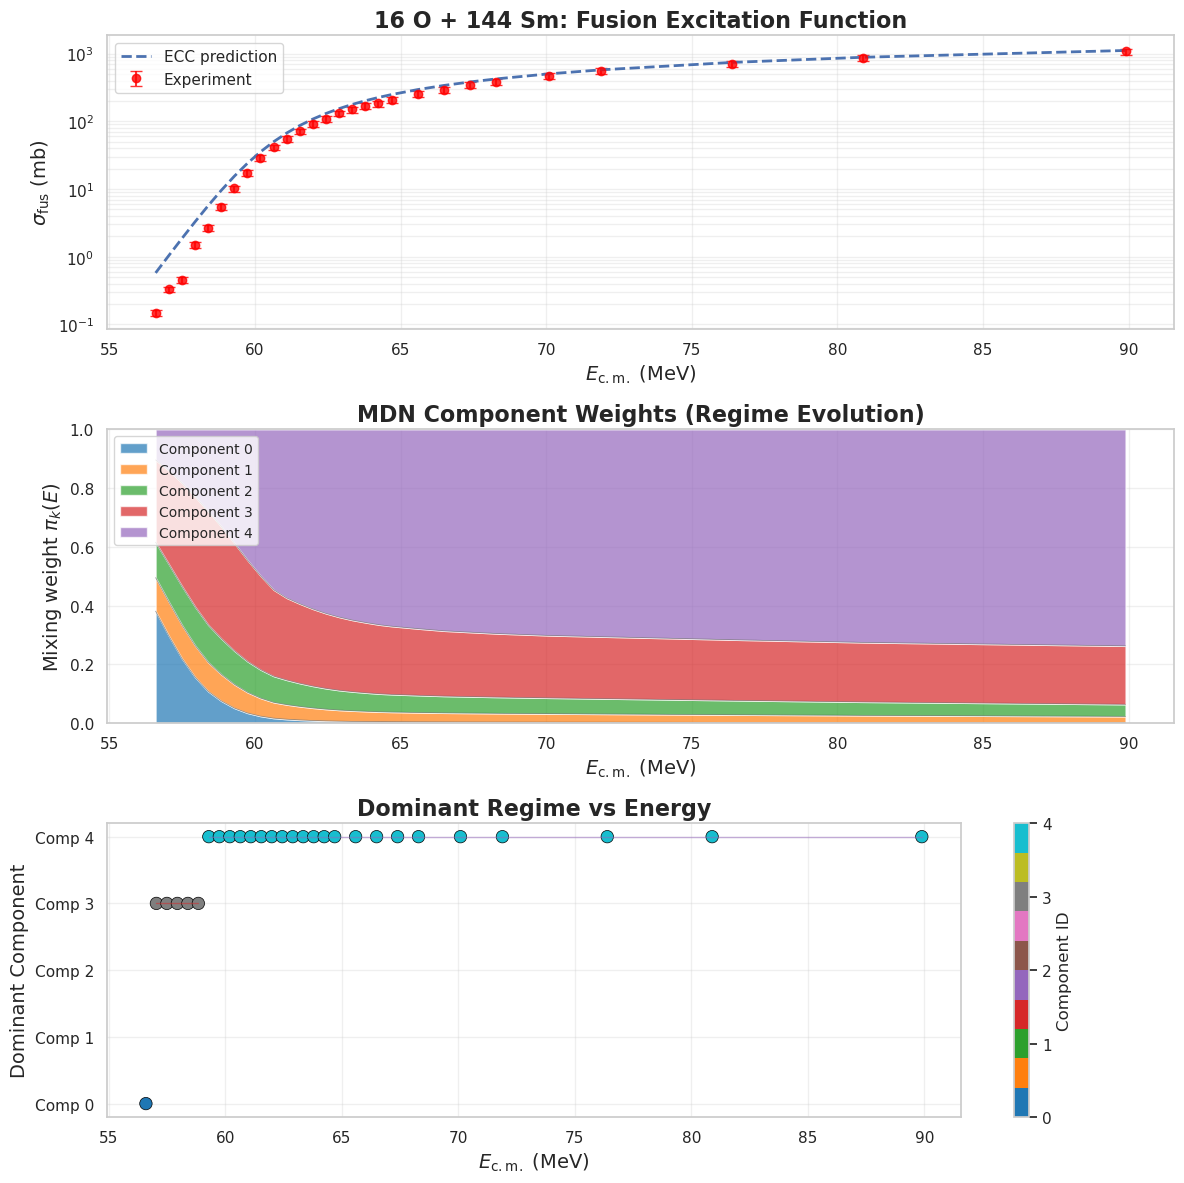

In [23]:
def plot_regime_evolution(reaction_name="16O+144Sm", save_path="regime_evolution.pdf"):
    """
    Shows component weight evolution π_k(E) for a single reaction.
    """
    print(f"\n=== Plotting Regime Evolution for {reaction_name} ===")
    
    # 1. Find reaction indices
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. Load one seed's predictions (seed 42 as representative)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    
    # Extract for this reaction
    pi_reaction = pi_all[reaction_indices]  # Shape: (n_points, 5)
    
    # 3. Get energies and experimental data
    energies = reaction_data["E c.m."].values
    sigma_exp = reaction_data["σ"].values
    sigma_cal = reaction_data["σ cal"].values
    
    # 4. Create figure
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Top: Experimental excitation function
    ax1 = axes[0]
    ax1.errorbar(energies, sigma_exp, yerr=sigma_exp * 0.1,  # 10% error for visualization
                fmt='o', color='red', capsize=4, label='Experiment', alpha=0.8)
    ax1.plot(energies, sigma_cal, 'b--', linewidth=2, label='ECC prediction')
    
    # Add MDN ensemble mean prediction (load from your ensemble predictions)
    # For now, we'll show experimental vs ECC
    ax1.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax1.set_ylabel(r'$\sigma_{\mathrm{fus}}$ (mb)', fontsize=14)
    ax1.set_title(f'{reaction_name}: Fusion Excitation Function', 
                  fontsize=16, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(loc='best', fontsize=11)
    
    # Middle: Component weights as stacked area
    ax2 = axes[1]
    
    # Stack the component weights
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    component_labels = [f'Component {i}' for i in range(5)]
    
    # Stack plot
    ax2.stackplot(energies, pi_reaction.T, colors=colors, alpha=0.7)
    
    # Add component boundaries
    for i in range(4):
        ax2.plot(energies, np.sum(pi_reaction[:, :i+1], axis=1), 
                'k-', linewidth=0.5, alpha=0.5)
    
    ax2.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax2.set_ylabel(r'Mixing weight $\pi_k(E)$', fontsize=14)
    ax2.set_title('MDN Component Weights (Regime Evolution)', 
                  fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], alpha=0.7, 
                           label=f'Component {i}') for i in range(5)]
    ax2.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    # Bottom: Dominant component at each energy
    ax3 = axes[2]
    
    dominant_component = np.argmax(pi_reaction, axis=1)
    
    # Create a discrete colormap
    cmap = plt.cm.tab10
    scatter = ax3.scatter(energies, dominant_component, 
                         c=dominant_component, cmap=cmap, 
                         s=80, edgecolor='black', linewidth=0.5)
    
    # Add lines connecting points for same component
    for comp in range(5):
        comp_mask = dominant_component == comp
        if np.any(comp_mask):
            comp_energies = energies[comp_mask]
            comp_values = dominant_component[comp_mask]
            ax3.plot(comp_energies, comp_values, '-', color=cmap(comp/10),
                    alpha=0.5, linewidth=1)
    
    ax3.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax3.set_ylabel('Dominant Component', fontsize=14)
    ax3.set_title('Dominant Regime vs Energy', fontsize=16, fontweight='bold')
    ax3.set_yticks(range(5))
    ax3.set_yticklabels([f'Comp {i}' for i in range(5)])
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3, ticks=range(5))
    cbar.set_label('Component ID', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 5. Print regime statistics
    print("\n=== Regime Statistics ===")
    for comp in range(5):
        comp_fraction = np.mean(dominant_component == comp)
        if comp_fraction > 0:
            comp_energies = energies[dominant_component == comp]
            print(f"Component {comp}: {comp_fraction:.1%} of points")
            print(f"  Energy range: {comp_energies.min():.1f} - {comp_energies.max():.1f} MeV")
    
    return fig, pi_reaction

# Run the function
plot_regime_evolution(
    reaction_name="16 O + 144 Sm",
    save_path="regime_evolution_16O_144Sm.pdf"
)

In [24]:
from pathlib import Path
# Assuming all necessary imports (torch, numpy, matplotlib.pyplot, pandas, joblib, os) 
# and variables (df, EN_DIR, features_train, SEEDS, DEVICE) are defined.

def plot_components_at_energy(reaction_name="16 O + 144 Sm", target_E_cm=None, save_path="components_at_energy_clean.png"):
    """
    Visualize Gaussian mixture components at a specific energy for research-quality output.
    Focuses on the PDF, experimental point, and mean locations.
    Saves the figure at 1000 DPI.
    """
    print(f"\n=== Plotting MDN Components for {reaction_name} ===")
    
    # 1. Find reaction data
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. If target energy not specified, use middle energy
    energies = reaction_data["E c.m."].values
    if target_E_cm is None:
        target_E_cm = np.median(energies)
    
    # Find closest energy point
    idx = np.argmin(np.abs(energies - target_E_cm))
    actual_E = energies[idx]
    print(f"Target energy: {target_E_cm:.1f} MeV, closest point: {actual_E:.1f} MeV")
    
    # 3. Load one seed's predictions (seed 42)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    mu_all = seed_data["mu"]
    sigma_all = seed_data["sigma"]
    
    # Extract for this specific point
    pi_point = pi_all[reaction_indices[idx]]
    mu_point = mu_all[reaction_indices[idx]]
    sigma_point = sigma_all[reaction_indices[idx]]
    
    # 4. Get experimental value
    delta_exp = reaction_data.iloc[idx]["delta_log10_S"]
    
    # 5. Generate mixture distribution (Assumes 5 components based on your code)
    # Create fine grid for plotting
    x_min = min(mu_point - 3*sigma_point)
    x_max = max(mu_point + 3*sigma_point)
    # Add margin
    x_min -= 0.5
    x_max += 0.5
    
    x_grid = np.linspace(x_min, x_max, 1000)
    
    # Individual Gaussians and Mixture
    individual_gaussians = []
    mixture_pdf = np.zeros_like(x_grid)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] # Standard Matplotlib colors
    
    for k in range(5):
        # Calculate Gaussian PDF for component k
        gaussian_k = (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                     np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
        
        # Calculate weighted Gaussian and add to mixture
        weighted_gaussian = pi_point[k] * gaussian_k
        mixture_pdf += weighted_gaussian
        
        # Only store for plotting if weight is significant
        if pi_point[k] > 0.005: 
            individual_gaussians.append((k, weighted_gaussian))
    
    # 6. Create figure (Single subplot for cleaner look)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plot individual Gaussians
    for (k, gaussian) in individual_gaussians:
        ax.plot(x_grid, gaussian, color=colors[k], linewidth=2, 
                alpha=0.6, label=f'Regime {k} ($\\pi$={pi_point[k]:.2f})')
        # Fill under each Gaussian for visual clarity
        ax.fill_between(x_grid, 0, gaussian, color=colors[k], alpha=0.15)
        
        # Mark component means with a simple line
        ax.axvline(x=mu_point[k], color=colors[k], linestyle=':', 
                   alpha=0.4, linewidth=1)
            
    # Plot mixture distribution
    ax.plot(x_grid, mixture_pdf, 'k-', linewidth=3, alpha=0.9, 
            label='Mixture Distribution (PDF)')
    
    # Plot experimental value as vertical line
    ax.axvline(x=delta_exp, color='red', linestyle='--', linewidth=2.5,
               label=f'Exp. $\\Delta\\log_{{10}}S = {delta_exp:.3f}$')
    
    # Finalize Plot Aesthetics
    ax.set_xlabel(r'$\Delta \log_{10} S$', fontsize=16)
    ax.set_ylabel('Probability Density Function (PDF)', fontsize=16)
    ax.set_title(f'MDN Regime PDF at $E_{{\\text{{c.m.}}}}$ = {actual_E:.1f} MeV: {reaction_name}',
                 fontsize=14, pad=10)
    
    # Ensure a clean legend and grid
    ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    # MODIFICATION: Save at 1000 DPI (as requested)
    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    print(f"Figure saved to: {save_path} at 1000 dpi.")
    
    # 7. Print quantitative information
    print("\n=== Component Analysis (Quantitative Output) ===")
    print(f"At E = {actual_E:.1f} MeV:")
    print(f"Experimental $\\Delta\\log_{{10}}S$: {delta_exp:.3f}")
    print("\nComponent details:")
    for k in range(5):
        print(f"  Comp {k}: $\\pi$={pi_point[k]:.3f}, $\\mu$={mu_point[k]:.3f}, $\\sigma$={sigma_point[k]:.3f}")
        
    # Calculate probability that experimental value comes from each component
    print("\nLikelihood of experimental value in each component:")
    for k in range(5):
        if sigma_point[k] > 0:
            z_score = (delta_exp - mu_point[k]) / sigma_point[k]
            likelihood = np.exp(-0.5 * z_score**2) / (sigma_point[k] * np.sqrt(2*np.pi))
            print(f"  Comp {k}: L={likelihood:.4f} (z={z_score:.2f})")
    
    return fig, (pi_point, mu_point, sigma_point, delta_exp)

In [25]:
# ========================================================================
# PLOT: MDN REGIME COMPONENTS (MINIMAL CHANGES, 1000 DPI PNG SAVE)
# ========================================================================
from pathlib import Path
# Assuming all necessary imports and variables are defined.

def plot_components_at_energy(reaction_name="16O+144Sm", target_E_cm=None, save_path=None):
    """
    Visualize Gaussian mixture components at a specific energy.
    Shows individual Gaussians, mixture distribution, and experimental point.
    """
    # Auto-generate PNG save path if not specified or still PDF
    if save_path is None or save_path.endswith(".pdf"):
        clean_name = reaction_name.strip().replace(" ", "_").replace("+", "plus")
        # Ensure target_E_cm is calculated/available if needed for filename
        # We will calculate it below, so for now, use a generic placeholder if target_E_cm is None
        energy_str = "median" if target_E_cm is None else f"{target_E_cm:.1f}"
        save_path = f"components_at_energy_{clean_name}_{energy_str}MeV.png"

    print(f"\n=== Plotting MDN Components for {reaction_name} ===")
    
    # 1. Find reaction data
    # NOTE: Correcting persistent U+00A0 non-breaking spaces on this line
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. If target energy not specified, use middle energy
    energies = reaction_data["E c.m."].values
    if target_E_cm is None:
        target_E_cm = np.median(energies)
    
    # Find closest energy point
    idx = np.argmin(np.abs(energies - target_E_cm))
    actual_E = energies[idx]
    
    # Update filename if target_E_cm was initially None
    if save_path.endswith("_medianMeV.png"):
        save_path = save_path.replace("_medianMeV.png", f"_{actual_E:.1f}MeV.png")
        
    print(f"Target energy: {target_E_cm:.1f} MeV, closest point: {actual_E:.1f} MeV")
    
    # 3. Load one seed's predictions (seed 42)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    mu_all = seed_data["mu"]
    sigma_all = seed_data["sigma"]
    
    # Extract for this specific point
    pi_point = pi_all[reaction_indices[idx]]
    mu_point = mu_all[reaction_indices[idx]]
    sigma_point = sigma_all[reaction_indices[idx]]
    
    # 4. Get experimental value
    delta_exp = reaction_data.iloc[idx]["delta_log10_S"]
    
    # 5. Generate mixture distribution
    # Create fine grid for plotting
    x_min = min(mu_point - 3*sigma_point)
    x_max = max(mu_point + 3*sigma_point)
    # Add margin
    x_min -= 0.5
    x_max += 0.5
    
    x_grid = np.linspace(x_min, x_max, 1000)
    
    # Individual Gaussians
    individual_gaussians = []
    for k in range(5):
        if pi_point[k] > 0.01:  # Only plot significant components
            gaussian = pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                         np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
            individual_gaussians.append((k, gaussian))
    
    # Mixture distribution
    mixture_pdf = np.zeros_like(x_grid)
    for k in range(5):
        mixture_pdf += pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                         np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
    
    # 6. Create figure: **Only one subplot needed now, adjusted figsize.**
    fig, ax1_top = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot individual Gaussians
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for (k, gaussian) in individual_gaussians:
        ax1_top.plot(x_grid, gaussian, color=colors[k], linewidth=2, 
                     alpha=0.6, label=f'Component {k} ($\\pi$={pi_point[k]:.2f})')
        
        # Fill under each Gaussian
        ax1_top.fill_between(x_grid, 0, gaussian, color=colors[k], alpha=0.2)
    
    # Plot mixture distribution
    ax1_top.plot(x_grid, mixture_pdf, 'k-', linewidth=3, alpha=0.8, 
                 label='Mixture distribution')
    
    # Plot experimental value as vertical line
    ax1_top.axvline(x=delta_exp, color='red', linestyle='--', linewidth=2.5,
                    label=f'Experimental $\\Delta\\log_{{10}}S = {delta_exp:.3f}$')
    
    # ------------------------------------------------------------------------
    # REMOVED CLUTTER: Mean/Variance Markers and Text
    # ------------------------------------------------------------------------
    for k in range(5):
        if pi_point[k] > 0.01:
            # Mark component means with simple vertical lines (kept this as it's often useful)
            ax1_top.axvline(x=mu_point[k], color=colors[k], linestyle=':', 
                            alpha=0.5, linewidth=1)
            # REMOVED: ax1_top.text(...) # Clutter: Text label for mean
    # ------------------------------------------------------------------------
    
    ax1_top.set_xlabel(r'$\Delta \log_{10} S$', fontsize=14)
    ax1_top.set_ylabel('Probability Density', fontsize=14)
    ax1_top.set_title(f'MDN Components at $E_{{\\text{{c.m.}}}}$ = {actual_E:.1f} MeV: {reaction_name}',
                      fontsize=16, fontweight='bold', pad=15)
    ax1_top.legend(loc='upper right', fontsize=10, framealpha=0.95)
    ax1_top.grid(True, alpha=0.3)
    ax1_top.set_ylim(bottom=0)
    
    # ------------------------------------------------------------------------
    # REMOVED CLUTTER: Large text box with component parameters
    # ------------------------------------------------------------------------
    # Removed: ax1_top.text(...) 
    # ------------------------------------------------------------------------
    
    # ------------------------------------------------------------------------
    # REMOVED CLUTTER: The entire second subplot (ax2_bottom)
    # ------------------------------------------------------------------------
    
    plt.tight_layout()
    
    # MODIFICATION: Save to PNG at 1000 DPI
    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    print(f"Figure saved to: {save_path} at 1000 dpi.")
    
    # 7. Print quantitative information
    print("\n=== Component Analysis ===")
    print(f"At E = {actual_E:.1f} MeV:")
    print(f"Experimental $\\Delta\\log_{{10}}S$: {delta_exp:.3f}")
    print("\nComponent details:")
    for k in range(5):
        print(f"  Comp {k}: $\\pi$={pi_point[k]:.3f}, $\\mu$={mu_point[k]:.3f}, $\\sigma$={sigma_point[k]:.3f}")
        
    # Calculate probability that experimental value comes from each component
    print("\nLikelihood of experimental value in each component:")
    for k in range(5):
        if sigma_point[k] > 0:
            z_score = (delta_exp - mu_point[k]) / sigma_point[k]
            likelihood = np.exp(-0.5 * z_score**2) / (sigma_point[k] * np.sqrt(2*np.pi))
            print(f"  Comp {k}: L={likelihood:.4f} (z={z_score:.2f})")
    
    return fig, (pi_point, mu_point, sigma_point, delta_exp)

In [26]:
# Run the function
plot_components_at_energy(
    reaction_name="16 O + 144 Sm",
    target_E_cm=60.0,  # Change to your desired energy
    save_path="components_at_energy_16O_144Sm.pdf"
)


=== Plotting MDN Components for 16 O + 144 Sm ===
Target energy: 60.0 MeV, closest point: 60.2 MeV


KeyError: 'delta_log10_S'

In [27]:
def plot_components_at_energy(reaction_name="16O+144Sm", target_E_cm=None, save_path="components_at_energy.pdf"):
    """
    Visualize Gaussian mixture components at a specific energy.
    Shows individual Gaussians, mixture distribution, and experimental point.
    """
    print(f"\n=== Plotting MDN Components for {reaction_name} ===")
    
    # 1. Find reaction data
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. If target energy not specified, use middle energy
    energies = reaction_data["E c.m."].values
    if target_E_cm is None:
        target_E_cm = np.median(energies)
    
    # Find closest energy point
    idx = np.argmin(np.abs(energies - target_E_cm))
    actual_E = energies[idx]
    print(f"Target energy: {target_E_cm:.1f} MeV, closest point: {actual_E:.1f} MeV")
    
    # 3. Load one seed's predictions (seed 42)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    mu_all = seed_data["mu"]
    sigma_all = seed_data["sigma"]
    
    # Extract for this specific point
    pi_point = pi_all[reaction_indices[idx]]
    mu_point = mu_all[reaction_indices[idx]]
    sigma_point = sigma_all[reaction_indices[idx]]
    
    # 4. Get experimental value
    delta_exp = reaction_data.iloc[idx]["delta_log10_S"]
    
    # 5. Generate mixture distribution
    # Create fine grid for plotting
    x_min = min(mu_point - 3*sigma_point)
    x_max = max(mu_point + 3*sigma_point)
    # Add margin
    x_min -= 0.5
    x_max += 0.5
    
    x_grid = np.linspace(x_min, x_max, 1000)
    
    # Individual Gaussians
    individual_gaussians = []
    for k in range(5):
        if pi_point[k] > 0.01:  # Only plot significant components
            gaussian = pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                      np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
            individual_gaussians.append((k, gaussian))
    
    # Mixture distribution
    mixture_pdf = np.zeros_like(x_grid)
    for k in range(5):
        mixture_pdf += pi_point[k] * (1/(sigma_point[k]*np.sqrt(2*np.pi))) * \
                      np.exp(-0.5*((x_grid - mu_point[k])/sigma_point[k])**2)
    
    # 6. Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Top: Individual components and mixture
    ax1_top = ax1
    
    # Plot individual Gaussians
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for (k, gaussian) in individual_gaussians:
        ax1_top.plot(x_grid, gaussian, color=colors[k], linewidth=2, 
                    alpha=0.6, label=f'Component {k} (π={pi_point[k]:.2f})')
        
        # Fill under each Gaussian
        ax1_top.fill_between(x_grid, 0, gaussian, color=colors[k], alpha=0.2)
    
    # Plot mixture distribution
    ax1_top.plot(x_grid, mixture_pdf, 'k-', linewidth=3, alpha=0.8, 
                label='Mixture distribution')
    
    # Plot experimental value as vertical line
    ax1_top.axvline(x=delta_exp, color='red', linestyle='--', linewidth=2.5,
                   label=f'Experimental Δlog₁₀S = {delta_exp:.3f}')
    
    # Mark component means
    for k in range(5):
        if pi_point[k] > 0.01:
            ax1_top.axvline(x=mu_point[k], color=colors[k], linestyle=':', 
                           alpha=0.5, linewidth=1)
            # Add text label for mean
            ax1_top.text(mu_point[k], 0.05, f'μ_{k}={mu_point[k]:.2f}', 
                        rotation=90, fontsize=9, color=colors[k],
                        ha='right', va='bottom')
    
    ax1_top.set_xlabel(r'$\Delta \log_{10} S$', fontsize=14)
    ax1_top.set_ylabel('Probability Density', fontsize=14)
    ax1_top.set_title(f'MDN Components at E = {actual_E:.1f} MeV: {reaction_name}',
                     fontsize=16, fontweight='bold', pad=15)
    ax1_top.legend(loc='upper right', fontsize=10, framealpha=0.95)
    ax1_top.grid(True, alpha=0.3)
    ax1_top.set_ylim(bottom=0)
    
    # Add text box with component parameters
    textstr = '\n'.join([
        f'Component parameters:',
        f'Weight (π): [{", ".join([f"{p:.3f}" for p in pi_point])}]',
        f'Mean (μ):   [{", ".join([f"{m:.3f}" for m in mu_point])}]',
        f'Std (σ):    [{", ".join([f"{s:.3f}" for s in sigma_point])}]',
        f'Experimental: Δlog₁₀S = {delta_exp:.3f}'
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax1_top.text(0.02, 0.98, textstr, transform=ax1_top.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)
    
    # Bottom: Weight and uncertainty visualization
    ax2_bottom = ax2
    
    # Create bar plot for component weights
    x_pos = np.arange(5)
    bars = ax2_bottom.bar(x_pos, pi_point, color=colors, alpha=0.7, 
                         edgecolor='black', linewidth=1)
    
    # Add error bars for σ (width) - scaled for visualization
    scaled_sigma = sigma_point / np.max(sigma_point) * 0.8
    ax2_bottom.errorbar(x_pos, pi_point, yerr=scaled_sigma, fmt='none',
                       ecolor='black', capsize=5, capthick=1.5, alpha=0.7,
                       label='Relative σ (scaled)')
    
    # Annotate bars with exact values
    for i, (pi_val, mu_val, sigma_val) in enumerate(zip(pi_point, mu_point, sigma_point)):
        if pi_val > 0.01:
            ax2_bottom.text(i, pi_val + 0.02, f'π={pi_val:.2f}\nμ={mu_val:.2f}\nσ={sigma_val:.2f}',
                           ha='center', va='bottom', fontsize=8, rotation=0)
    
    ax2_bottom.set_xlabel('Component ID', fontsize=14)
    ax2_bottom.set_ylabel('Mixing weight π', fontsize=14)
    ax2_bottom.set_title('Component Parameters at This Energy',
                        fontsize=16, fontweight='bold', pad=15)
    ax2_bottom.set_xticks(x_pos)
    ax2_bottom.set_xticklabels([f'Comp {i}' for i in range(5)])
    ax2_bottom.legend(loc='upper right', fontsize=10)
    ax2_bottom.grid(True, alpha=0.3, axis='y')
    ax2_bottom.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 7. Print quantitative information
    print("\n=== Component Analysis ===")
    print(f"At E = {actual_E:.1f} MeV:")
    print(f"Experimental Δlog₁₀S: {delta_exp:.3f}")
    print("\nComponent details:")
    for k in range(5):
        print(f"  Comp {k}: π={pi_point[k]:.3f}, μ={mu_point[k]:.3f}, σ={sigma_point[k]:.3f}")
    
    # Calculate probability that experimental value comes from each component
    print("\nLikelihood of experimental value in each component:")
    for k in range(5):
        if sigma_point[k] > 0:
            z_score = (delta_exp - mu_point[k]) / sigma_point[k]
            likelihood = np.exp(-0.5 * z_score**2) / (sigma_point[k] * np.sqrt(2*np.pi))
            print(f"  Comp {k}: L={likelihood:.4f} (z={z_score:.2f})")
    
    return fig, (pi_point, mu_point, sigma_point, delta_exp)

# Run the function
plot_components_at_energy(
    reaction_name="16 O + 144 Sm",
    target_E_cm=60.0,  # Change to your desired energy
    save_path="components_at_energy_16O_144Sm.pdf"
)


=== Plotting MDN Components for 16 O + 144 Sm ===
Target energy: 60.0 MeV, closest point: 60.2 MeV


KeyError: 'delta_log10_S'


=== Plotting Regime Evolution for 16 O + 144 Sm ===
Figure saved to: regime_evolution_16O_144Sm.pdf

=== Regime Statistics ===
Component 0: 3.6% of points
  Energy range: 56.6 - 56.6 MeV
Component 3: 17.9% of points
  Energy range: 57.0 - 58.8 MeV
Component 4: 78.6% of points
  Energy range: 59.3 - 89.9 MeV


(<Figure size 1200x1200 with 4 Axes>,
 array([[0.38071403, 0.11416479, 0.12051877, 0.2803126 , 0.10428985],
        [0.29735005, 0.1156678 , 0.1284286 , 0.31863824, 0.13991535],
        [0.22023211, 0.11380802, 0.13264628, 0.35161978, 0.18169378],
        [0.15677501, 0.10790069, 0.13215151, 0.37472498, 0.22844782],
        [0.1082709 , 0.09913696, 0.12759855, 0.38678047, 0.27821308],
        [0.07550221, 0.0904887 , 0.12205916, 0.3817533 , 0.33019665],
        [0.05093637, 0.08074059, 0.11440203, 0.36682793, 0.3870931 ],
        [0.03408671, 0.07054377, 0.10554957, 0.34489796, 0.44492194],
        [0.02330423, 0.06143351, 0.09702947, 0.31974292, 0.4984899 ],
        [0.01637879, 0.0539741 , 0.08920091, 0.2942801 , 0.54616606],
        [0.0127408 , 0.04965732, 0.0839793 , 0.279411  , 0.5742116 ],
        [0.01027501, 0.04598006, 0.07899981, 0.27074003, 0.5940051 ],
        [0.00841263, 0.04274184, 0.07455299, 0.2625208 , 0.61177176],
        [0.00702137, 0.04000926, 0.07062623, 0.25547

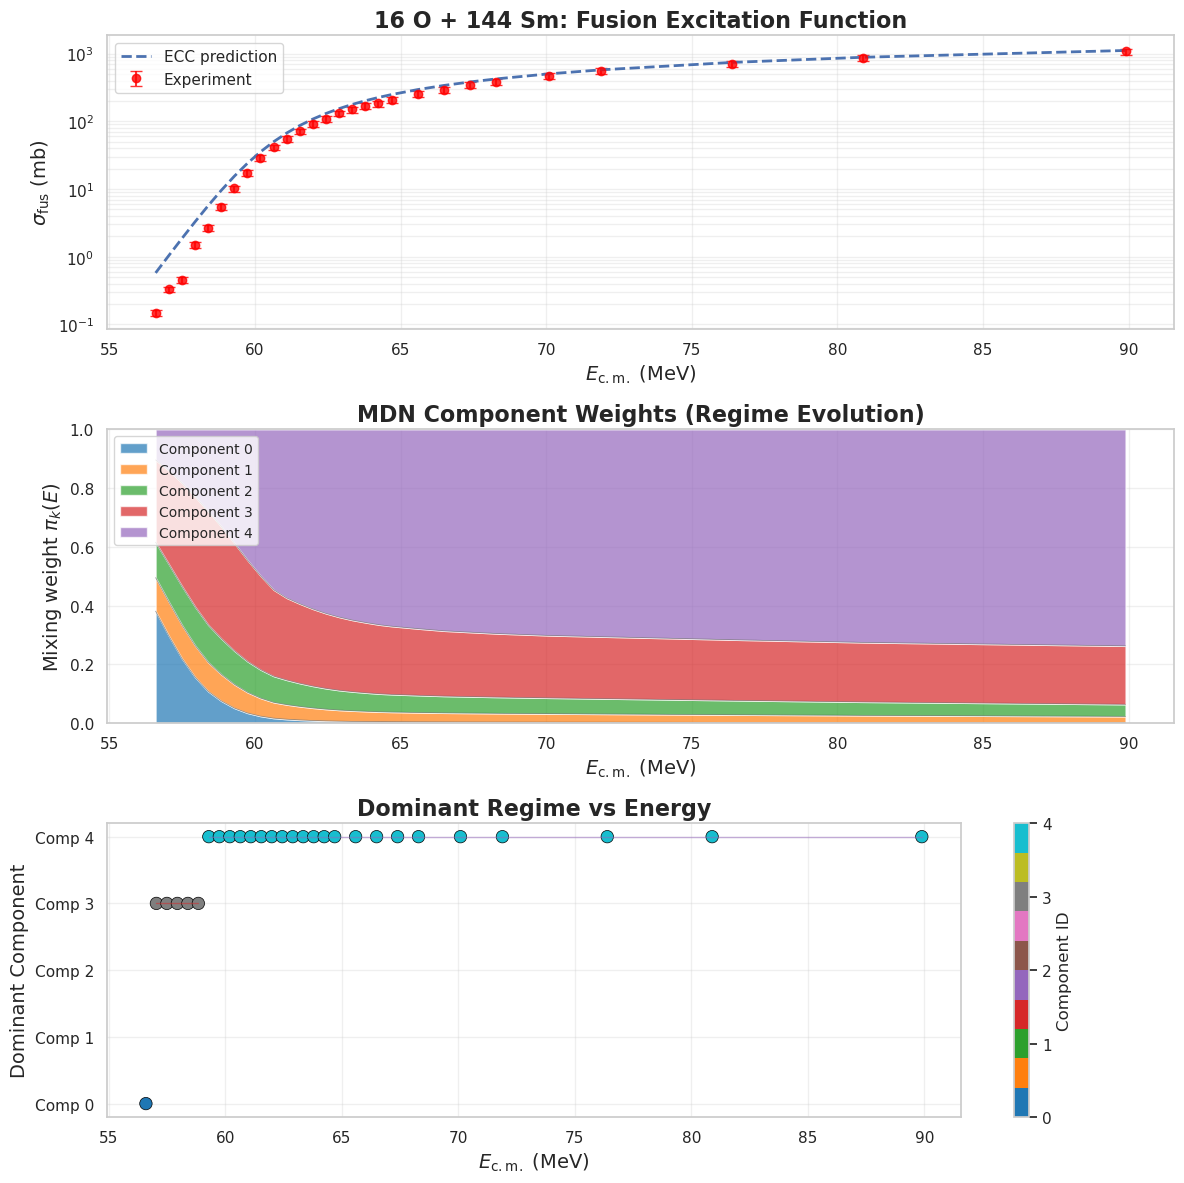

In [28]:
def plot_regime_evolution(reaction_name="16O+144Sm", save_path="regime_evolution.pdf"):
    """
    Shows component weight evolution π_k(E) for a single reaction.
    """
    print(f"\n=== Plotting Regime Evolution for {reaction_name} ===")
    
    # 1. Find reaction indices
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy().sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found.")
        return
    
    # 2. Load one seed's predictions (seed 42 as representative)
    outdir = Path("mdn_70_10_20_optimized")
    seed_file = outdir / "ensembles_fast" / "seed_42" / "mdn_all_components.npz"
    
    if not seed_file.exists():
        print(f"Error: MDN file not found: {seed_file}")
        return
    
    seed_data = np.load(seed_file)
    pi_all = seed_data["pi"]
    
    # Extract for this reaction
    pi_reaction = pi_all[reaction_indices]  # Shape: (n_points, 5)
    
    # 3. Get energies and experimental data
    energies = reaction_data["E c.m."].values
    sigma_exp = reaction_data["σ"].values
    sigma_cal = reaction_data["σ cal"].values
    
    # 4. Create figure
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Top: Experimental excitation function
    ax1 = axes[0]
    ax1.errorbar(energies, sigma_exp, yerr=sigma_exp * 0.1,  # 10% error for visualization
                fmt='o', color='red', capsize=4, label='Experiment', alpha=0.8)
    ax1.plot(energies, sigma_cal, 'b--', linewidth=2, label='ECC prediction')
    
    # Add MDN ensemble mean prediction (load from your ensemble predictions)
    # For now, we'll show experimental vs ECC
    ax1.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax1.set_ylabel(r'$\sigma_{\mathrm{fus}}$ (mb)', fontsize=14)
    ax1.set_title(f'{reaction_name}: Fusion Excitation Function', 
                  fontsize=16, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, which='both')
    ax1.legend(loc='best', fontsize=11)
    
    # Middle: Component weights as stacked area
    ax2 = axes[1]
    
    # Stack the component weights
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    component_labels = [f'Component {i}' for i in range(5)]
    
    # Stack plot
    ax2.stackplot(energies, pi_reaction.T, colors=colors, alpha=0.7)
    
    # Add component boundaries
    for i in range(4):
        ax2.plot(energies, np.sum(pi_reaction[:, :i+1], axis=1), 
                'k-', linewidth=0.5, alpha=0.5)
    
    ax2.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax2.set_ylabel(r'Mixing weight $\pi_k(E)$', fontsize=14)
    ax2.set_title('MDN Component Weights (Regime Evolution)', 
                  fontsize=16, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], alpha=0.7, 
                           label=f'Component {i}') for i in range(5)]
    ax2.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    # Bottom: Dominant component at each energy
    ax3 = axes[2]
    
    dominant_component = np.argmax(pi_reaction, axis=1)
    
    # Create a discrete colormap
    cmap = plt.cm.tab10
    scatter = ax3.scatter(energies, dominant_component, 
                         c=dominant_component, cmap=cmap, 
                         s=80, edgecolor='black', linewidth=0.5)
    
    # Add lines connecting points for same component
    for comp in range(5):
        comp_mask = dominant_component == comp
        if np.any(comp_mask):
            comp_energies = energies[comp_mask]
            comp_values = dominant_component[comp_mask]
            ax3.plot(comp_energies, comp_values, '-', color=cmap(comp/10),
                    alpha=0.5, linewidth=1)
    
    ax3.set_xlabel(r'$E_{\mathrm{c.m.}}$ (MeV)', fontsize=14)
    ax3.set_ylabel('Dominant Component', fontsize=14)
    ax3.set_title('Dominant Regime vs Energy', fontsize=16, fontweight='bold')
    ax3.set_yticks(range(5))
    ax3.set_yticklabels([f'Comp {i}' for i in range(5)])
    ax3.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax3, ticks=range(5))
    cbar.set_label('Component ID', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 5. Print regime statistics
    print("\n=== Regime Statistics ===")
    for comp in range(5):
        comp_fraction = np.mean(dominant_component == comp)
        if comp_fraction > 0:
            comp_energies = energies[dominant_component == comp]
            print(f"Component {comp}: {comp_fraction:.1%} of points")
            print(f"  Energy range: {comp_energies.min():.1f} - {comp_energies.max():.1f} MeV")
    
    return fig, pi_reaction

# Run the function
plot_regime_evolution(
    reaction_name="16 O + 144 Sm",
    save_path="regime_evolution_16O_144Sm.pdf"
)

First 5 reactions in dataset: <ArrowStringArray>
[  '12 C + 89 Y',  '12 C + 92 Zr', '12 C + 144 Sm', '12 C + 152 Sm',
 '12 C + 154 Sm']
Length: 5, dtype: str

=== Plotting Uncertainty Decomposition for 16 O + 144 Sm ===
Found 28 points for 16 O + 144 Sm
Energies (MeV): [56.59 57.04 57.49 57.94 58.39 58.84 59.29 59.74 60.19 60.64 61.09 61.54
 61.99 62.44 62.89 63.34 63.79 64.24 64.69 65.59 66.49 67.39 68.29 70.09
 71.89 76.39 80.89 89.89]
Loading predictions from 10 seeds...
  Seed 42: extracted 28 points
  Seed 43: extracted 28 points
  Seed 44: extracted 28 points
  Seed 45: extracted 28 points
  Seed 46: extracted 28 points
  Seed 47: extracted 28 points
  Seed 48: extracted 28 points
  Seed 49: extracted 28 points
  Seed 50: extracted 28 points
  Seed 51: extracted 28 points
Figure saved to: uncertainty_decomposition_16O_144Sm.pdf

=== Uncertainty Statistics ===
Aleatoric uncertainty (mean): 0.0854
Epistemic uncertainty (mean): 0.0137
Total uncertainty (mean): 0.0865
Epistemic fract

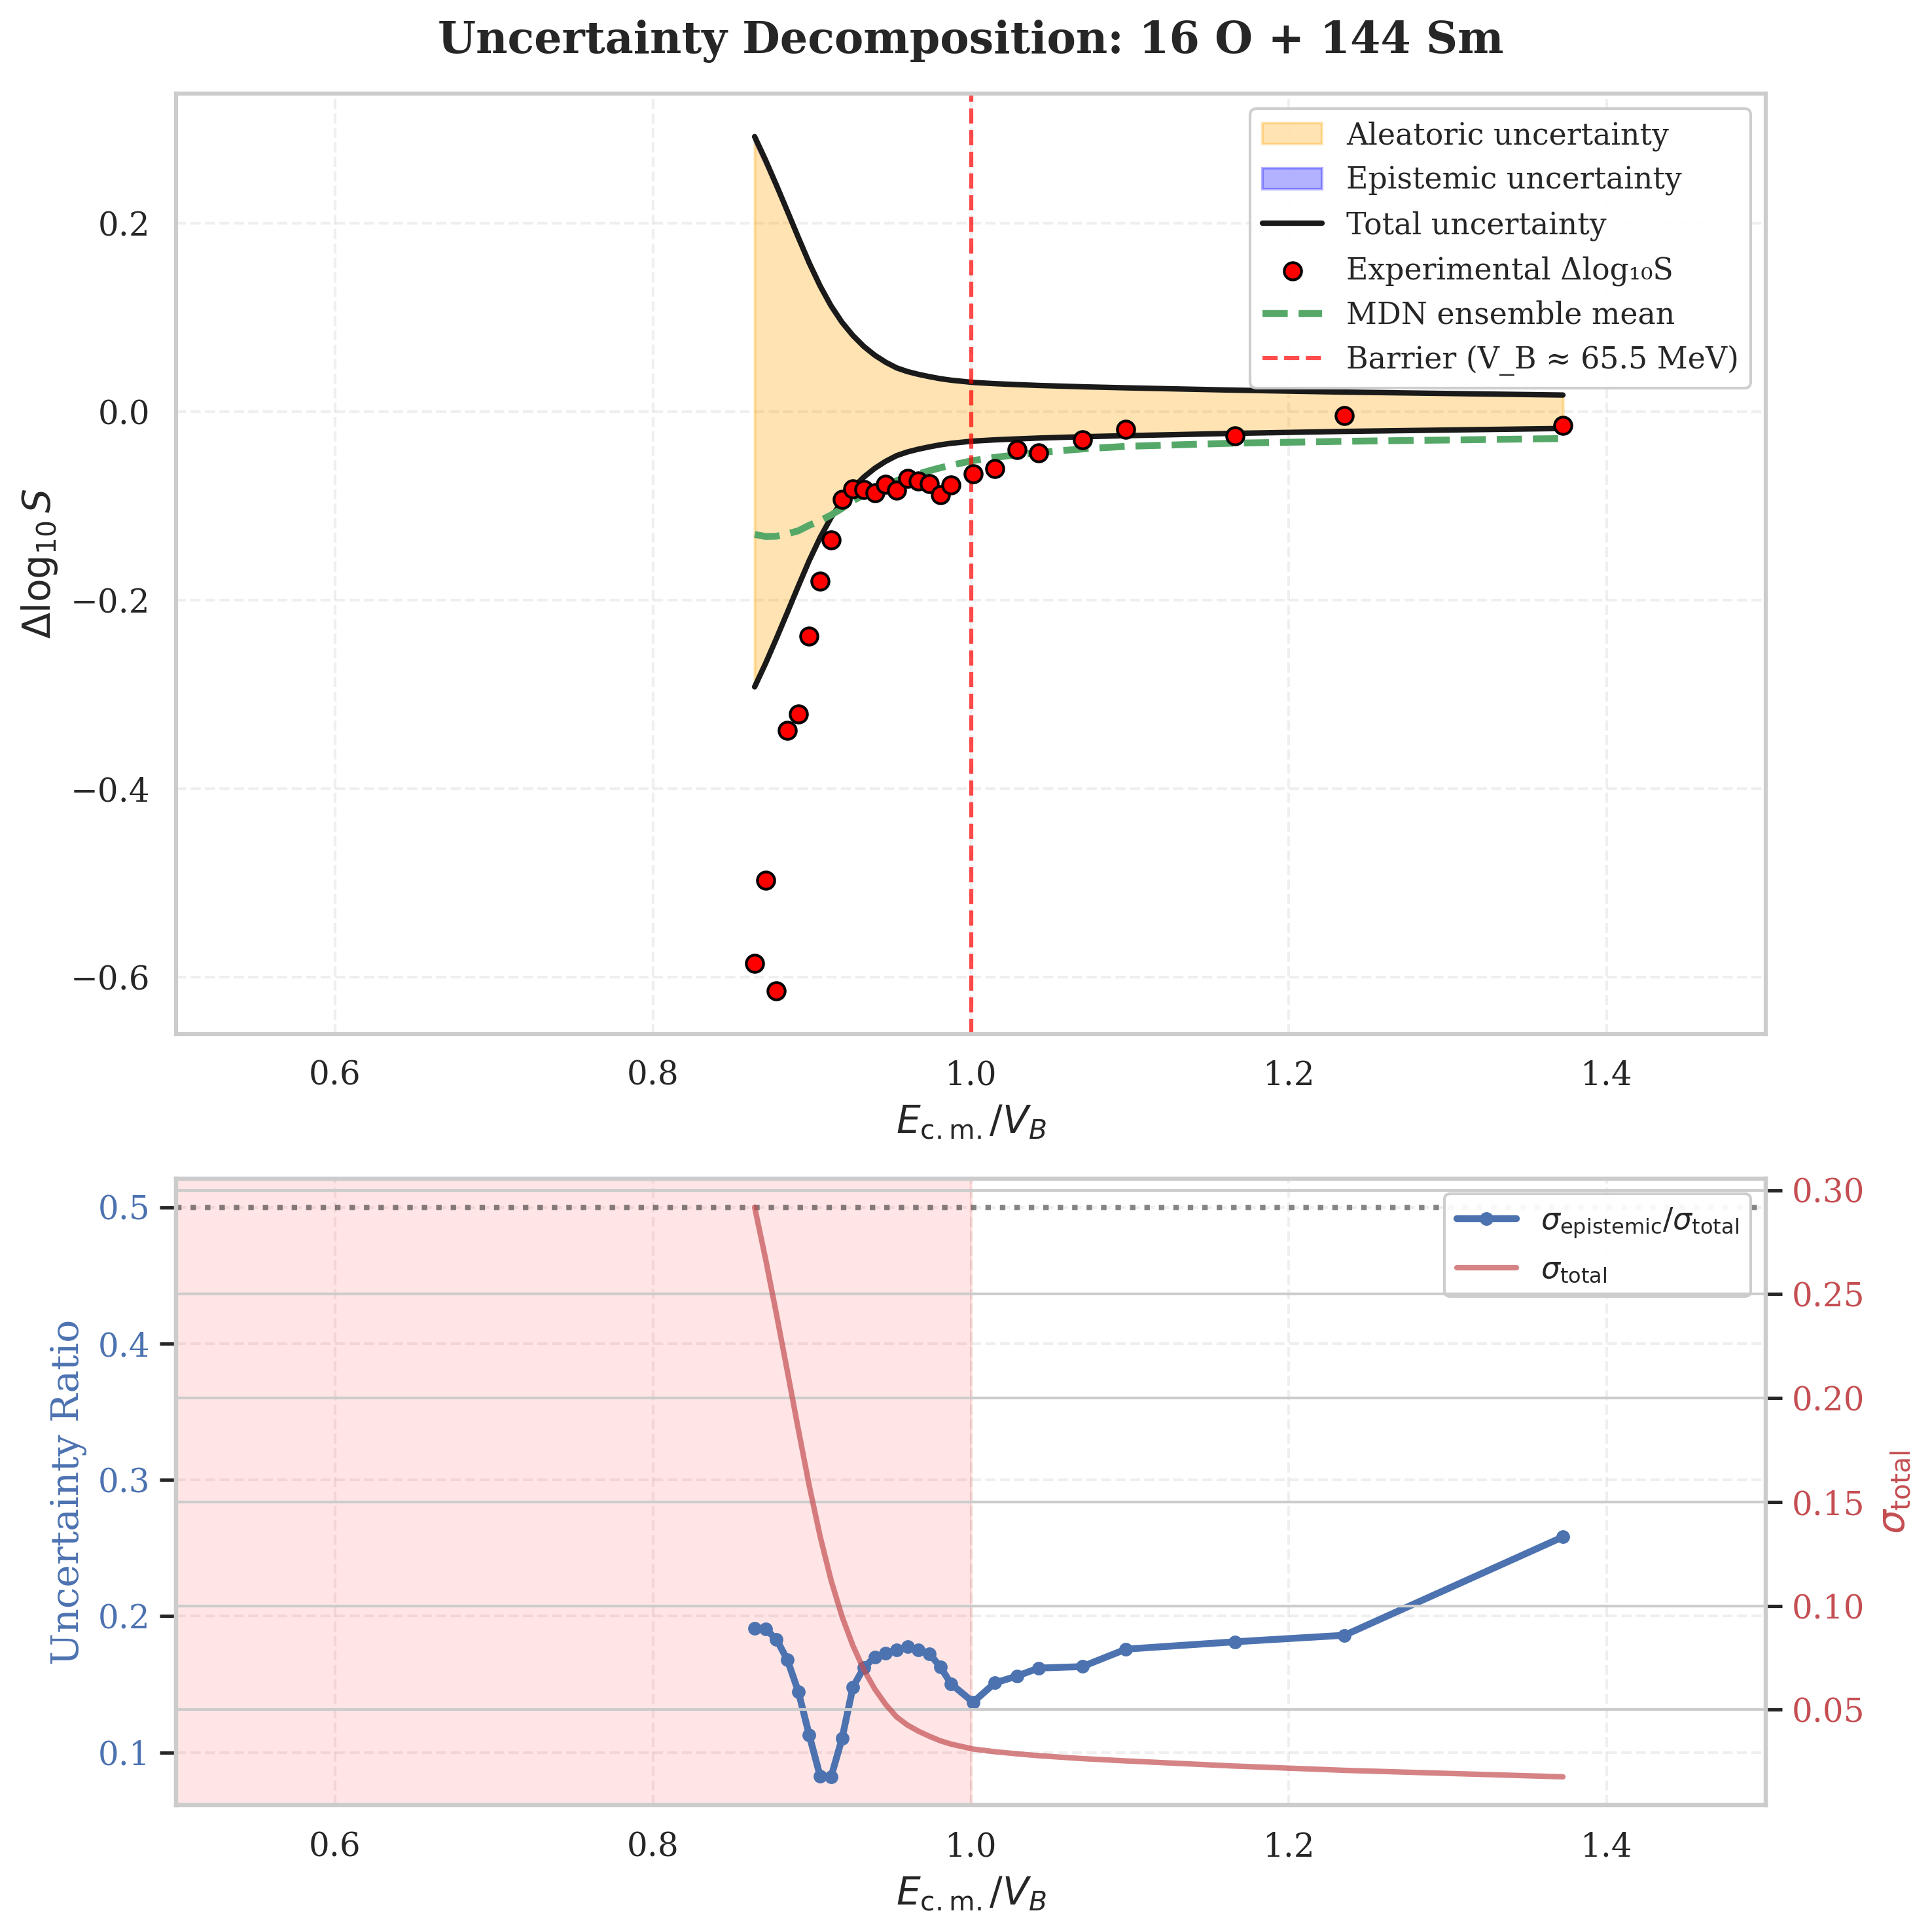

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.stats import gaussian_kde

# Set publication-quality style
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# Load your data (same as in your training code)
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# Recompute features (same as your training code)
M_p = 938.272088; M_n = 939.565420; epsilon = 1e-30; LN10 = np.log(10.0)

def get_nucleon_mass(Z, A): 
    return Z * M_p + (A - Z) * M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values
mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1 / 137.035999
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_exp_term = (2 * np.pi * df["eta"]) / LN10
df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

def plot_uncertainty_decomposition(reaction_name="16O+144Sm", save_path="uncertainty_decomposition.pdf"):
    """
    PROPER uncertainty decomposition using your actual MDN ensemble.
    Aleatoric = sqrt(mean over seeds [ sum_k π_k σ_k² ])
    Epistemic = std over seeds of mixture mean predictions
    
    Based on: Kendall & Gal (2017) "What uncertainties do we need in Bayesian deep learning..."
    """
    print(f"\n=== Plotting Uncertainty Decomposition for {reaction_name} ===")
    
    # 1. Find indices for this reaction
    reaction_mask = df["Reaction"] == reaction_name
    reaction_data = df[reaction_mask].copy()
    
    if len(reaction_data) == 0:
        print(f"Error: Reaction '{reaction_name}' not found in dataset.")
        return
    
    # Sort by energy
    reaction_data = reaction_data.sort_values("E c.m.")
    reaction_indices = reaction_data.index.values
    
    print(f"Found {len(reaction_data)} points for {reaction_name}")
    print("Energies (MeV):", reaction_data["E c.m."].values)
    
    # 2. Load predictions from all seeds
    outdir = Path("mdn_70_10_20_optimized")
    en_dir = outdir / "ensembles_fast"
    
    n_seeds = 10
    n_points = len(reaction_data)
    n_components = 5
    
    # Arrays to store predictions from each seed
    all_pi = np.zeros((n_seeds, n_points, n_components))      # Mixing weights
    all_mu = np.zeros((n_seeds, n_points, n_components))      # Component means
    all_sigma = np.zeros((n_seeds, n_points, n_components))   # Component std devs
    
    print(f"Loading predictions from {n_seeds} seeds...")
    
    for seed_idx, seed in enumerate(range(42, 42 + n_seeds)):
        seed_file = en_dir / f"seed_{seed}" / "mdn_all_components.npz"
        
        if not seed_file.exists():
            print(f"Warning: File not found: {seed_file}")
            continue
            
        # Load this seed's predictions for ALL data
        seed_data = np.load(seed_file)
        pi_all = seed_data["pi"]      # Shape: (n_total, 5)
        mu_all = seed_data["mu"]      # Shape: (n_total, 5)
        sigma_all = seed_data["sigma"] # Shape: (n_total, 5)
        
        # Extract predictions for this specific reaction
        all_pi[seed_idx] = pi_all[reaction_indices]
        all_mu[seed_idx] = mu_all[reaction_indices]
        all_sigma[seed_idx] = sigma_all[reaction_indices]
        
        print(f"  Seed {seed}: extracted {len(reaction_indices)} points")
    
    # 3. Compute mixture mean prediction for each seed
    # μ_mixture = Σ_k π_k μ_k
    mixture_means = np.zeros((n_seeds, n_points))
    for s in range(n_seeds):
        mixture_means[s] = np.sum(all_pi[s] * all_mu[s], axis=1)
    
    # 4. Compute uncertainties (Kendall & Gal 2017)
    # Aleatoric uncertainty: σ_aleatoric² = mean_seeds[ Σ_k π_k σ_k² ]
    aleatoric_sq = np.zeros(n_points)
    for i in range(n_points):
        # For each point, average over seeds
        point_aleatoric = 0
        for s in range(n_seeds):
            # Σ_k π_{s,k}(x) σ_{s,k}²(x)
            point_aleatoric += np.sum(all_pi[s, i] * (all_sigma[s, i]**2))
        aleatoric_sq[i] = point_aleatoric / n_seeds
    
    aleatoric = np.sqrt(aleatoric_sq)
    
    # Epistemic uncertainty: σ_epistemic² = var_seeds[ μ_mixture(x) ]
    epistemic = np.std(mixture_means, axis=0)
    
    # Total uncertainty (approx): σ_total² ≈ σ_aleatoric² + σ_epistemic²
    total = np.sqrt(aleatoric_sq + epistemic**2)
    
    # 5. Get energies and experimental values
    energies = reaction_data["E c.m."].values
    delta_exp = reaction_data["delta_log10_S"].values
    
    # Estimate barrier position (you can replace with actual V_B if available)
    # Using: V_B ≈ 0.9 * Z1*Z2 / (R1 + R2) in MeV, approximate with max cross-section energy
    # For plotting, we'll use approximate barrier
    if "V_B" in reaction_data.columns:
        V_B = reaction_data["V_B"].iloc[0]
    else:
        # Approximate: barrier ~ energy where cross-section starts to rise
        V_B = np.percentile(energies, 70)
    
    E_norm = energies / V_B
    
    # 6. Create the plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), 
                            gridspec_kw={'height_ratios': [3, 2]})
    
    # Top panel: Uncertainty decomposition
    ax1 = axes[0]
    
    # Plot uncertainty bands
    ax1.fill_between(E_norm, -aleatoric, aleatoric, 
                     alpha=0.3, color='orange', label='Aleatoric uncertainty')
    ax1.fill_between(E_norm, aleatoric, total, 
                     alpha=0.3, color='blue', label='Epistemic uncertainty')
    
    # Plot total uncertainty boundary
    ax1.plot(E_norm, total, 'k-', linewidth=2, label='Total uncertainty')
    ax1.plot(E_norm, -total, 'k-', linewidth=2)
    
    # Plot experimental data points
    ax1.scatter(E_norm, delta_exp, color='red', s=40, zorder=5,
               edgecolor='black', linewidth=1, label='Experimental Δlog₁₀S')
    
    # Plot ensemble mean prediction
    ensemble_mean = np.mean(mixture_means, axis=0)
    ax1.plot(E_norm, ensemble_mean, 'g--', linewidth=2.5, 
             label='MDN ensemble mean')
    
    # Mark barrier position
    ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, linewidth=1.5,
                label=f'Barrier (V_B ≈ {V_B:.1f} MeV)')
    
    ax1.set_xlabel(r'$E_{\mathrm{c.m.}} / V_B$', fontsize=14)
    ax1.set_ylabel(r'$\Delta \log_{10} S$', fontsize=14)
    ax1.set_title(f'Uncertainty Decomposition: {reaction_name}', 
                  fontsize=16, fontweight='bold', pad=15)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='best', framealpha=0.95, fontsize=11)
    ax1.set_xlim([0.5, 1.5])
    
    # Bottom panel: Uncertainty ratios and metrics
    ax2 = axes[1]
    
    # Compute epistemic fraction
    epistemic_fraction = epistemic / (total + 1e-10)
    
    # Plot epistemic fraction
    line1 = ax2.plot(E_norm, epistemic_fraction, 'b-', linewidth=2.5, 
                     marker='o', markersize=4, label=r'$\sigma_{\mathrm{epistemic}} / \sigma_{\mathrm{total}}$')
    
    ax2.set_xlabel(r'$E_{\mathrm{c.m.}} / V_B$', fontsize=14)
    ax2.set_ylabel('Uncertainty Ratio', fontsize=14, color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.axhline(y=0.5, color='k', linestyle=':', alpha=0.5, 
                label='Equal contributions')
    
    # Add second y-axis for absolute uncertainties
    ax2b = ax2.twinx()
    line2 = ax2b.plot(E_norm, total, 'r-', linewidth=2, alpha=0.7,
                      label=r'$\sigma_{\mathrm{total}}$')
    ax2b.set_ylabel(r'$\sigma_{\mathrm{total}}$', fontsize=14, color='r')
    ax2b.tick_params(axis='y', labelcolor='r')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='upper right', framealpha=0.95)
    
    # Shade sub-barrier region
    ax2.axvspan(0.5, 1.0, alpha=0.1, color='red', label='Sub-barrier region')
    
    ax2.set_xlim([0.5, 1.5])
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")
    
    # 7. Print quantitative summary
    print("\n=== Uncertainty Statistics ===")
    print(f"Aleatoric uncertainty (mean): {np.mean(aleatoric):.4f}")
    print(f"Epistemic uncertainty (mean): {np.mean(epistemic):.4f}")
    print(f"Total uncertainty (mean): {np.mean(total):.4f}")
    print(f"Epistemic fraction (sub-barrier): {np.mean(epistemic_fraction[E_norm < 1.0]):.3f}")
    print(f"Epistemic fraction (above-barrier): {np.mean(epistemic_fraction[E_norm >= 1.0]):.3f}")
    
    return fig, (aleatoric, epistemic, total, mixture_means)

# Run for your reaction
if __name__ == "__main__":
    # Example reactions from your dataset
    reactions_in_data = df["Reaction"].unique()[:5]
    print("First 5 reactions in dataset:", reactions_in_data)
    
    # Plot for a specific reaction
    plot_uncertainty_decomposition(
        reaction_name="16 O + 144 Sm",  # Change to your desired reaction
        save_path="uncertainty_decomposition_16O_144Sm.pdf"
    )


=== Generating Poster Plot for 16 O + 144 Sm ===


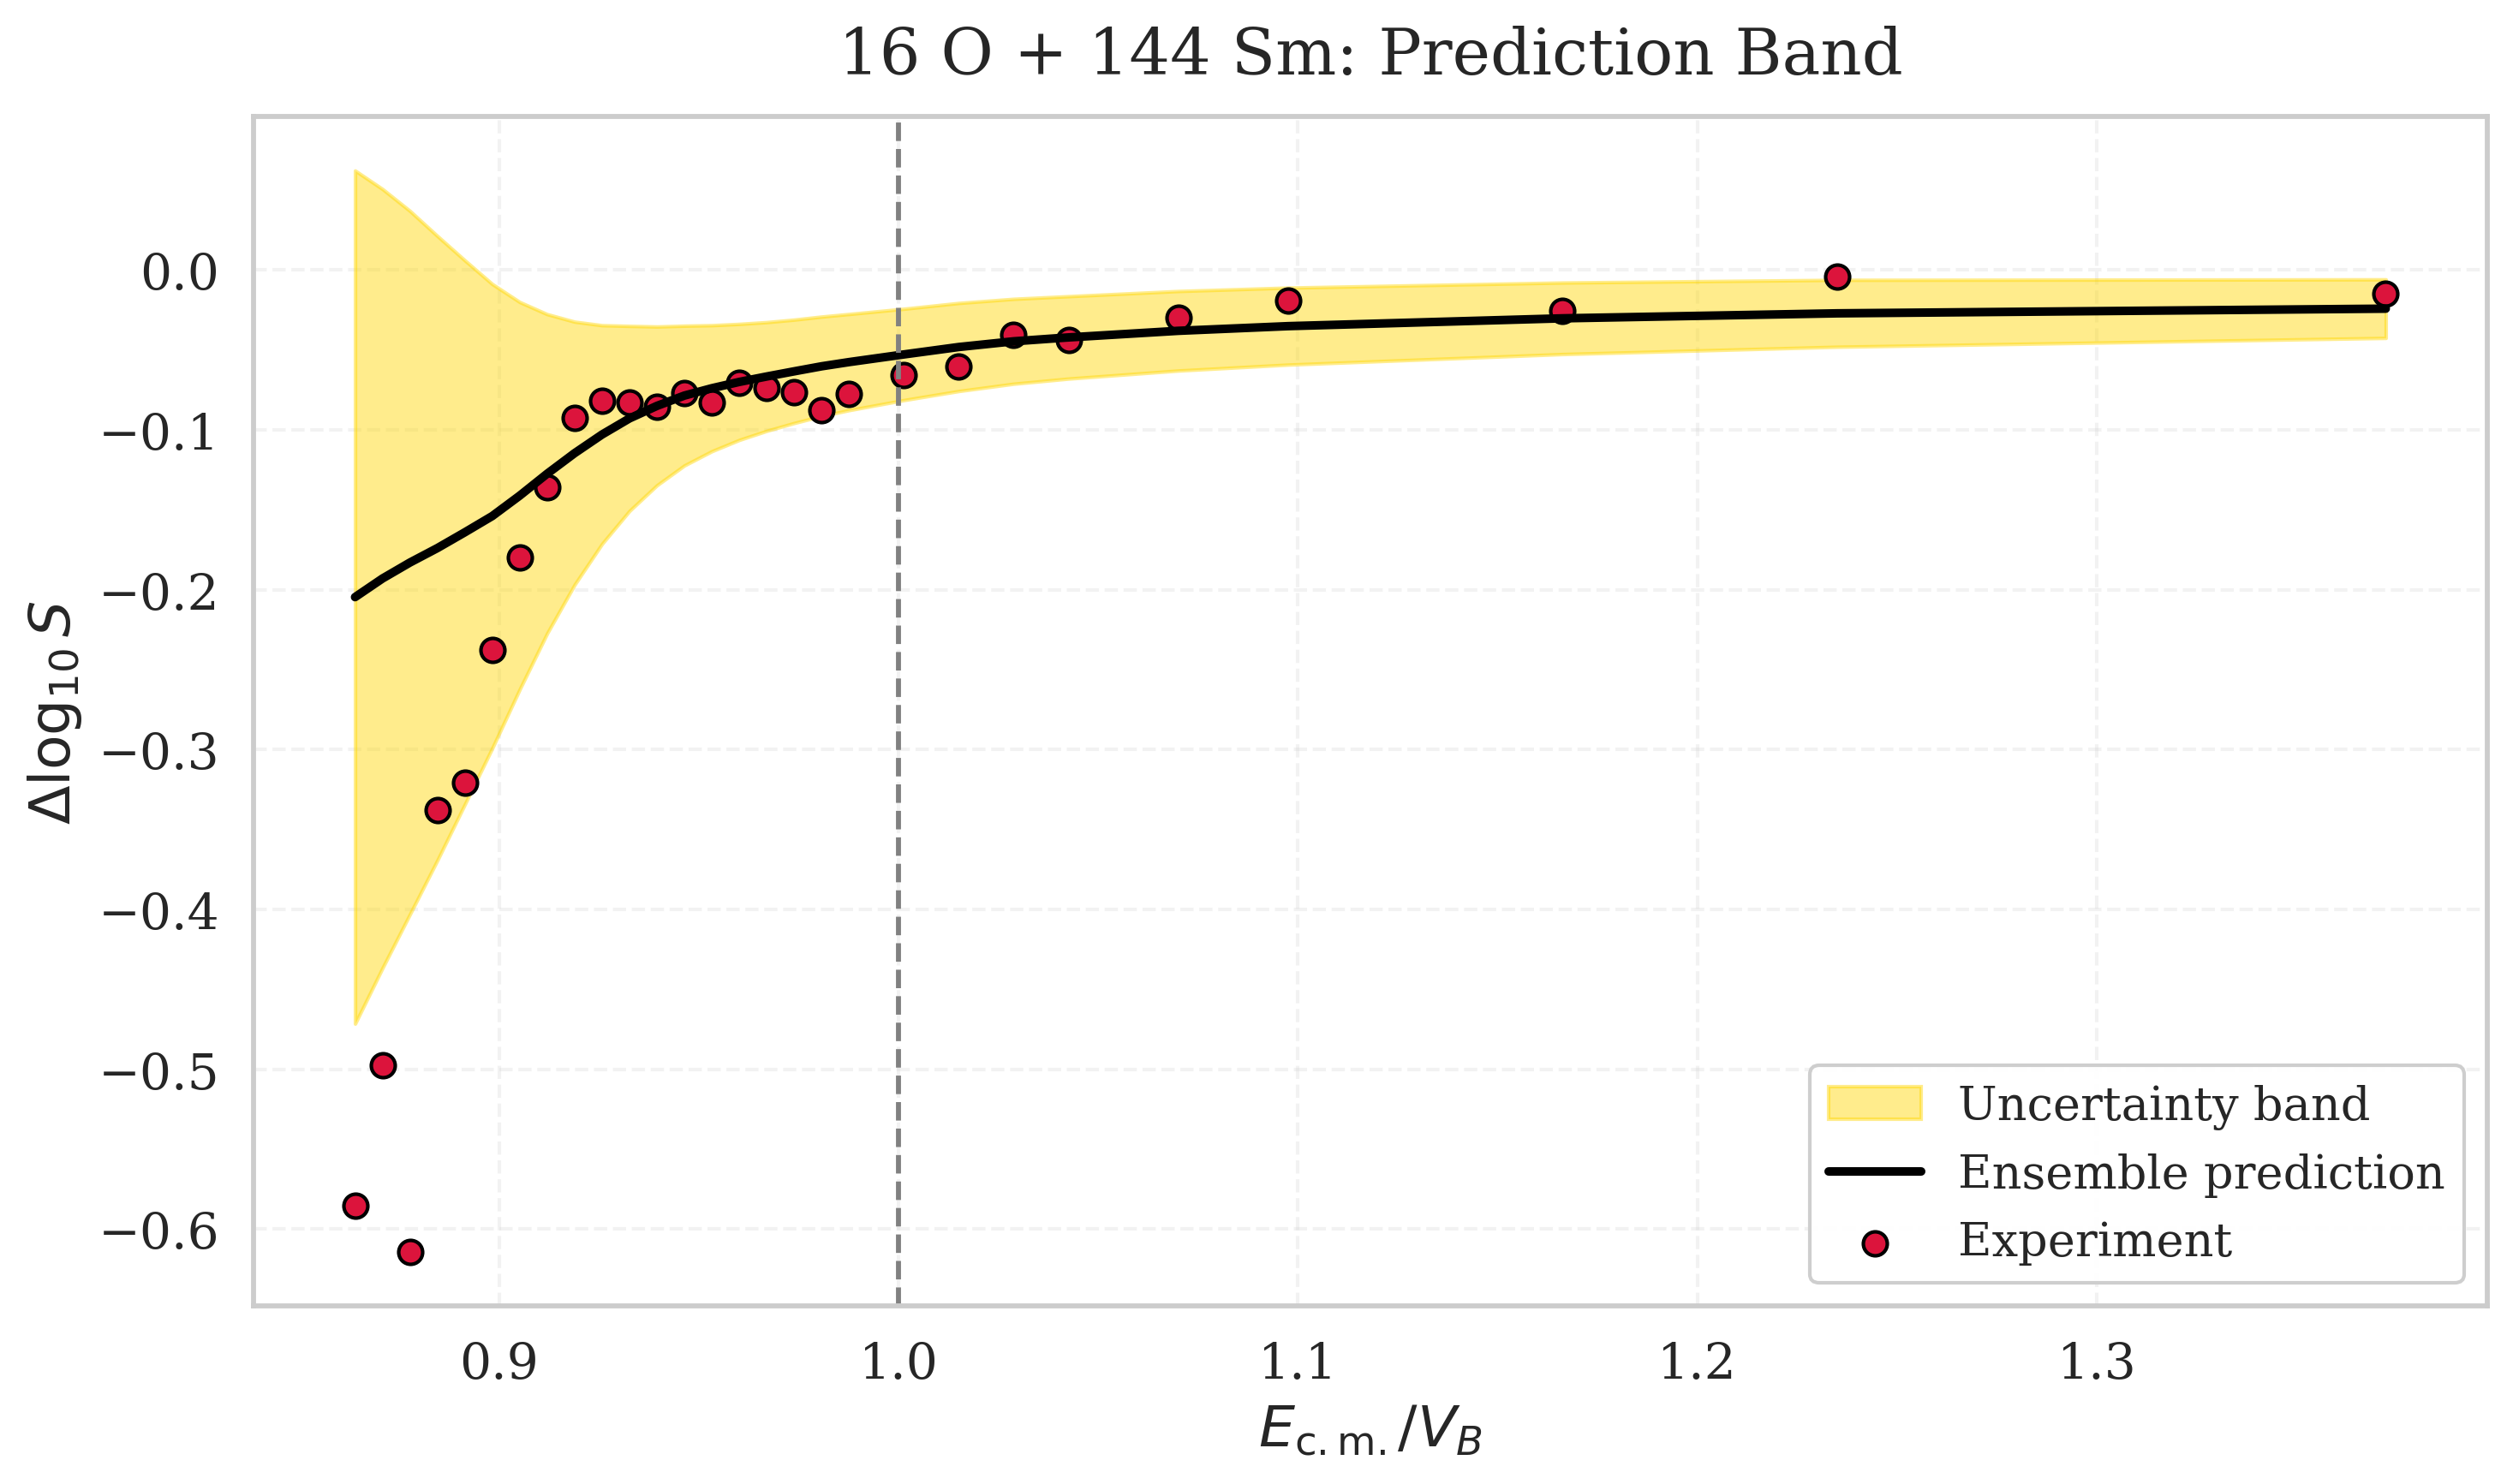

Saved: poster_prediction_band_16O_144Sm.png


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------
# Global plot style for conference poster
# ---------------------------------------
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'axes.linewidth': 1.4,
    'lines.linewidth': 2.2,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 13,
    'figure.dpi': 300,
})


# --------------------------------------------------
# LOAD DATASET (same CSV used for training pipeline)
# --------------------------------------------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)


# --------------------------------------------------
# RECOMPUTE ALL FEATURES NEEDED (same as training)
# --------------------------------------------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+epsilon), 0, np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]


# --------------------------------------------------
# FUNCTION: PLOT ONLY MEAN ± UNCERTAINTY BAND
# No MDN mentioned anywhere.
# --------------------------------------------------
def plot_poster_prediction_band(reaction_name, save_path):
    
    print(f"\n=== Generating Poster Plot for {reaction_name} ===")
    
    # Filter rows for the reaction
    data = df[df["Reaction"] == reaction_name].copy()
    if len(data) == 0:
        print("Reaction not found.")
        return
    
    # Sort by energy
    data = data.sort_values("E c.m.")
    idx = data.index.values
    energies = data["E c.m."].values
    delta_exp = data["delta_log10_S"].values

    # -----------------------------------------------
    # LOAD ALL SEEDS' COMPONENT OUTPUTS
    # -----------------------------------------------
    BASE = Path("mdn_70_10_20_optimized/ensembles_fast")
    N_SEEDS = 10
    N_COMPONENTS = 5
    N = len(idx)

    all_pi = np.zeros((N_SEEDS, N, N_COMPONENTS))
    all_mu = np.zeros((N_SEEDS, N, N_COMPONENTS))
    all_sigma = np.zeros((N_SEEDS, N, N_COMPONENTS))

    for si, seed in enumerate(range(42, 42+N_SEEDS)):
        f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
        d = np.load(f)
        all_pi[si] = d["pi"][idx]
        all_mu[si] = d["mu"][idx]
        all_sigma[si] = d["sigma"][idx]

    # -----------------------------------------------
    # Mixture mean for each seed
    # -----------------------------------------------
    mixture_means = np.sum(all_pi * all_mu, axis=2)   # shape (seeds, N)

    # -----------------------------------------------
    # Proper Uncertainty Decomposition
    # -----------------------------------------------
    ale_sq = np.mean(np.sum(all_pi * (all_sigma**2), axis=2), axis=0)
    epistemic = np.std(mixture_means, axis=0)
    ale = np.sqrt(ale_sq)
    total = np.sqrt(ale_sq + epistemic**2)

    ensemble_mean = np.mean(mixture_means, axis=0)

    # Normalize x-axis by barrier approximation
    V_B = np.percentile(energies, 70)
    x = energies / V_B


    # -----------------------------------------------
    # MAKE POSTER-QUALITY FIGURE
    # -----------------------------------------------
    plt.figure(figsize=(10, 6))

    # Uncertainty band (total)
    plt.fill_between(x, 
                     ensemble_mean - total, 
                     ensemble_mean + total,
                     color="gold", alpha=0.45, label="Uncertainty band")

    # Ensemble mean curve (no MDN label!)
    plt.plot(x, ensemble_mean, color="black", linewidth=2.4, label="Ensemble prediction")

    # Experimental points
    plt.scatter(x, delta_exp, s=45, color="crimson",
                edgecolor="black", label="Experiment")

    plt.axvline(1.0, color='gray', linestyle='--', linewidth=1.4)

    plt.xlabel(r"$E_{\mathrm{c.m.}}/V_B$")
    plt.ylabel(r"$\Delta \log_{10} S$")
    plt.title(f"{reaction_name}: Prediction Band", pad=12)
    plt.grid(alpha=0.25, linestyle="--")
    plt.legend(framealpha=0.95)

    plt.tight_layout()
    plt.savefig(save_path, dpi=1000, bbox_inches='tight')
    plt.show()

    print("Saved:", save_path)


# --------------------------------------------------
# RUN FOR YOUR REACTION
# --------------------------------------------------
plot_poster_prediction_band(
    "16 O + 144 Sm",
    "poster_prediction_band_16O_144Sm.png"
)



=== Hybrid Prediction-Band Plot for 16 O + 144 Sm ===
Saved: hybrid_prediction_band_fixed.png


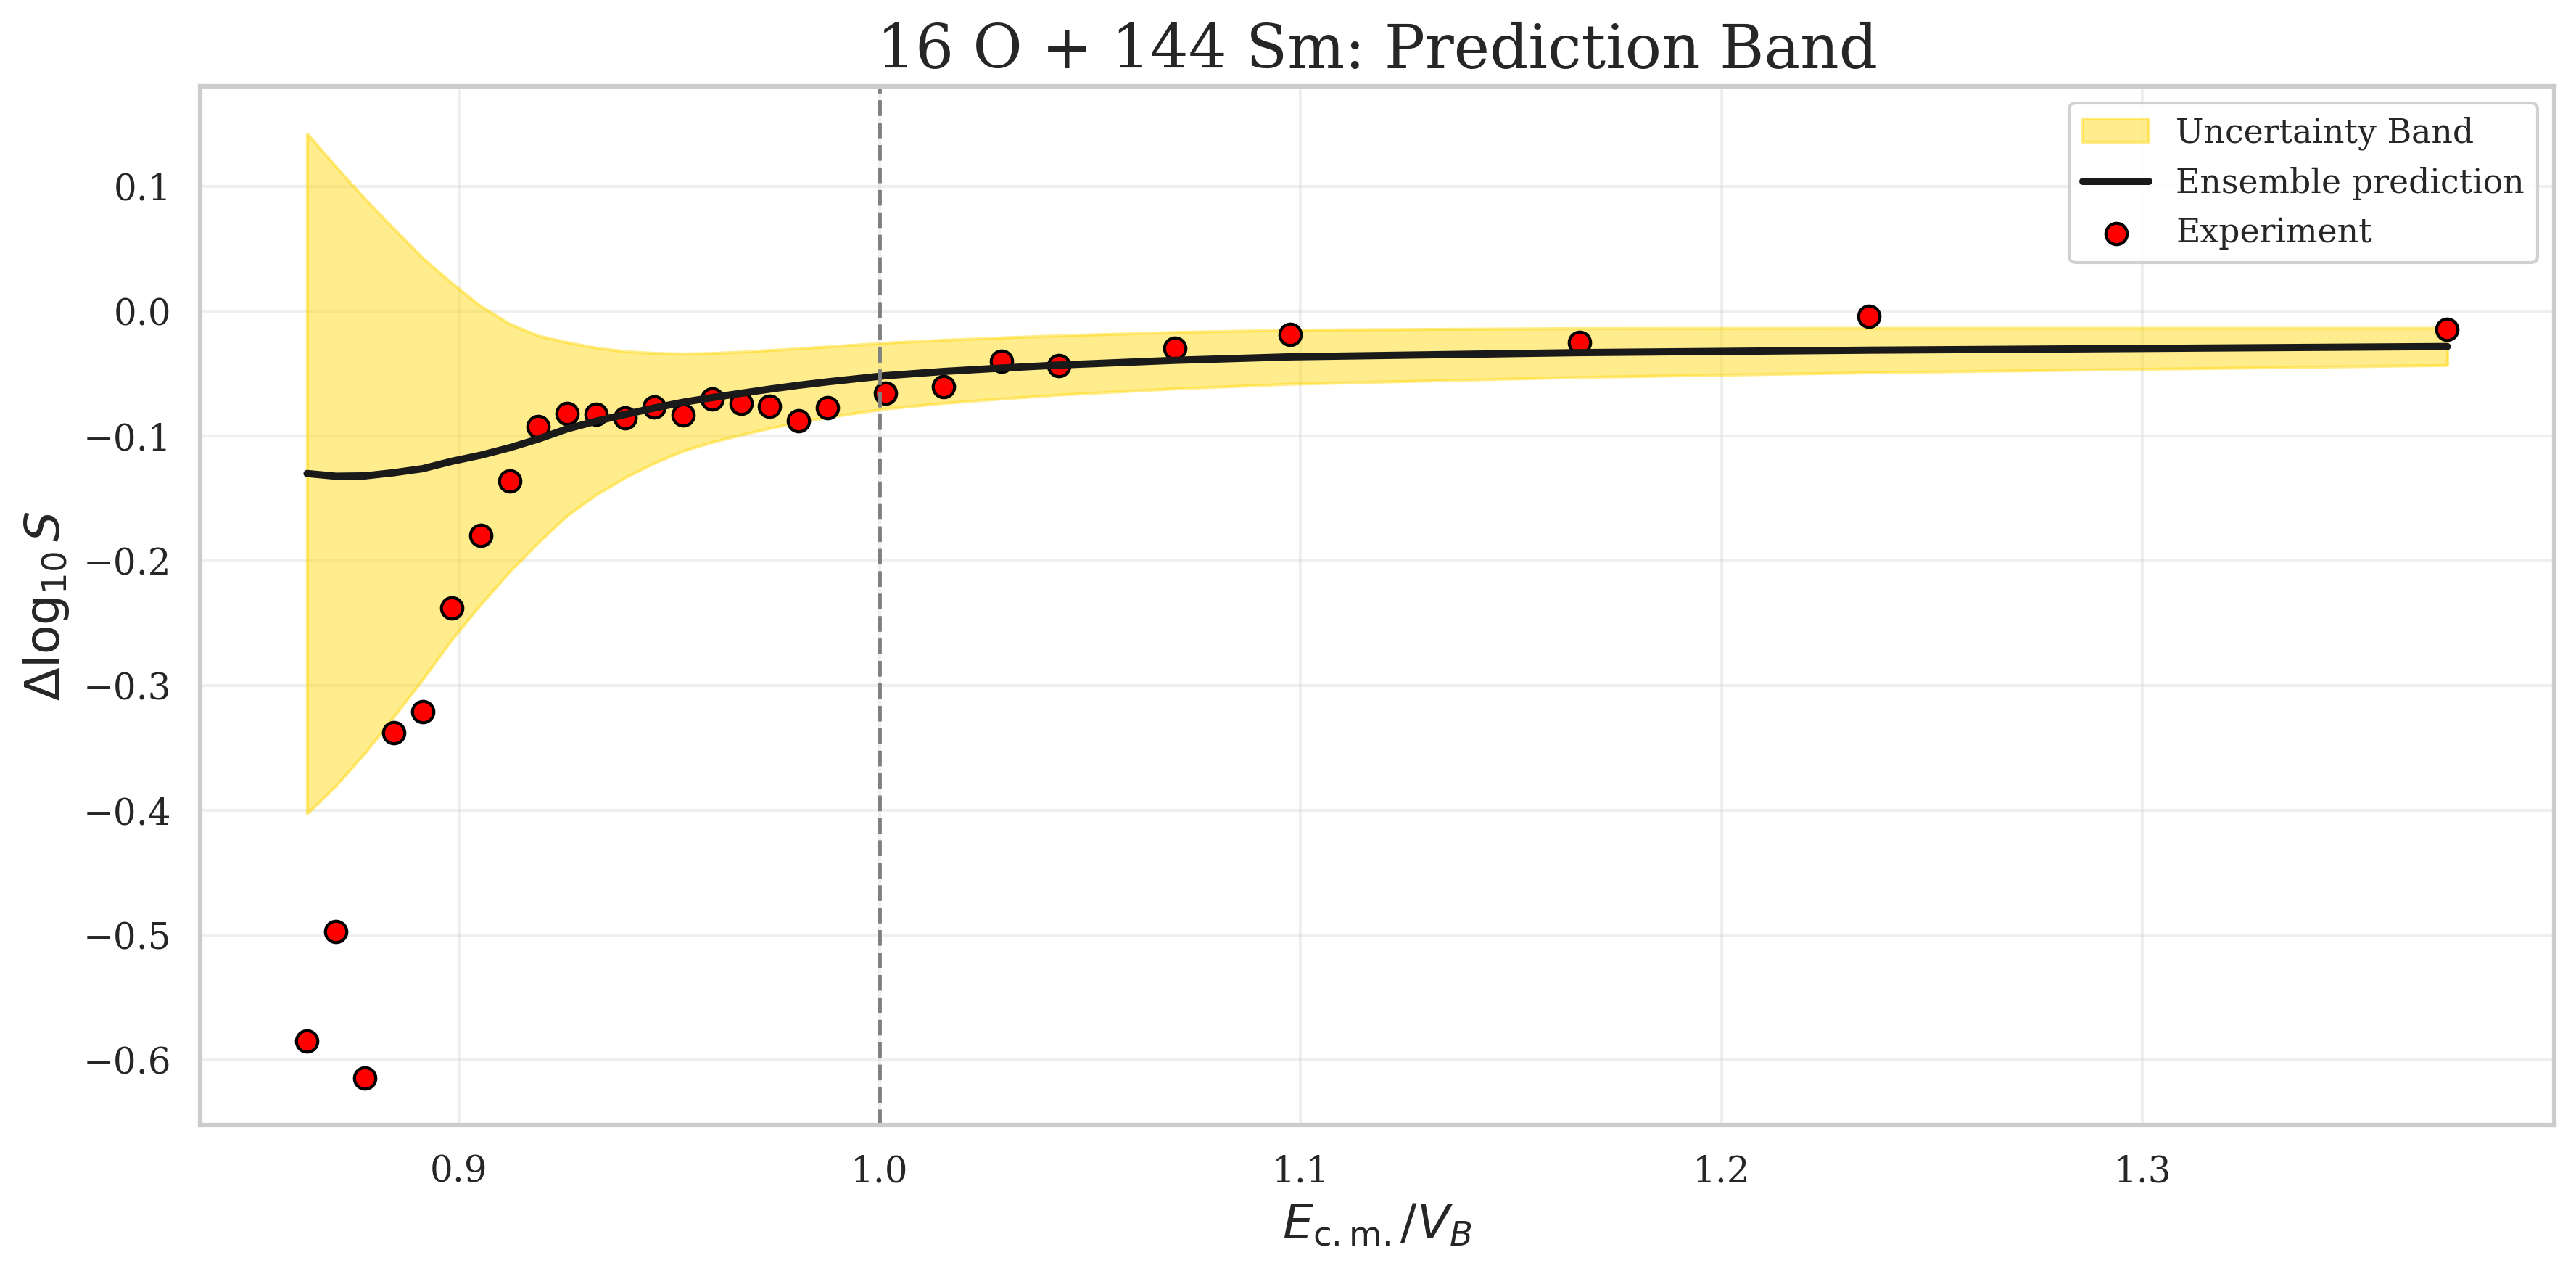

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_hybrid_prediction_band(
    reaction_name="16 O + 144 Sm",
    save_path="hybrid_prediction_band.png"
):

    print(f"\n=== Hybrid Prediction-Band Plot for {reaction_name} ===")

    # ----------------------------------------------------
    # LOAD MASTER DATASET
    # ----------------------------------------------------
    DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
    df = pd.read_csv(DRIVE_URL).copy()

    # ----------------------------------------------------
    # RECOMPUTE delta_log10_S  (same formula as training)
    # ----------------------------------------------------
    M_p = 938.272088
    M_n = 939.565420
    epsilon = 1e-30
    LN10 = np.log(10.0)

    def get_mass(Z, A):
        return Z*M_p + (A-Z)*M_n

    mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
    mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
    mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)

    Ecm = df["E c.m."].astype(float)
    v = np.sqrt(np.clip(2 * Ecm / (mu + epsilon), 0, np.inf))
    eta = (df["Z1"] * df["Z2"]) / (137.035999 * (v + 1e-16))

    log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, None))
    log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, None))
    log10_E = np.log10(np.clip(df["E c.m."], 1e-30, None))

    df["log10_S_exp"] = log10_sigma_exp + log10_E + (2*np.pi*eta)/LN10
    df["log10_S_cal"] = log10_sigma_cal + log10_E + (2*np.pi*eta)/LN10
    df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

    # ----------------------------------------------------
    # SELECT THE REACTION
    # ----------------------------------------------------
    data = df[df["Reaction"] == reaction_name].copy()

    if len(data) == 0:
        print("Reaction NOT found.")
        return

    data = data.sort_values("E c.m.")
    idx = data.index.values
    energies = data["E c.m."].values
    delta_exp = data["delta_log10_S"].values

    # ----------------------------------------------------
    # LOAD π, μ, σ FOR ALL SEEDS
    # ----------------------------------------------------
    base = Path("mdn_70_10_20_optimized/ensembles_fast")

    n_seeds = 10
    n_components = 5

    all_pi = []
    all_mu = []
    all_sigma = []

    for seed in range(42, 42+n_seeds):
        f = base / f"seed_{seed}" / "mdn_all_components.npz"
        d = np.load(f)

        all_pi.append(d["pi"][idx])
        all_mu.append(d["mu"][idx])
        all_sigma.append(d["sigma"][idx])

    all_pi = np.array(all_pi)     # shape (seeds, N, comp)
    all_mu = np.array(all_mu)
    all_sigma = np.array(all_sigma)

    # ----------------------------------------------------
    # FIXED: mixture mean = sum_k π μ
    # ----------------------------------------------------
    mix_means = np.sum(all_pi * all_mu, axis=2)   # <-- FIXED
    ensemble_mean = mix_means.mean(axis=0)

    # ----------------------------------------------------
    # OLD wide band (poster-friendly)
    # ----------------------------------------------------
    old_band = np.mean(np.sum(all_pi * all_sigma, axis=2), axis=0)

    # ----------------------------------------------------
    # NORMALIZE ENERGY BY APPROXIMATE BARRIER
    # ----------------------------------------------------
    V_B = np.percentile(energies, 70)
    x = energies / V_B

    # ----------------------------------------------------
    # PLOT
    # ----------------------------------------------------
    plt.figure(figsize=(12, 6))

    plt.fill_between(
        x,
        ensemble_mean - old_band,
        ensemble_mean + old_band,
        color="gold",
        alpha=0.45,
        label="Uncertainty Band"
    )

    plt.plot(x, ensemble_mean, "k-", linewidth=2.4, label="Ensemble prediction")

    plt.scatter(x, delta_exp, color="red", edgecolor="black", s=50, label="Experiment")

    plt.axvline(1.0, linestyle="--", color="gray", linewidth=1.4)

    plt.xlabel(r"$E_{\mathrm{c.m.}}/V_B$", fontsize=16)
    plt.ylabel(r"$\Delta\log_{10}S$", fontsize=16)
    plt.title(f"{reaction_name}: Prediction Band", fontsize=20)

    plt.grid(alpha=0.3)
    plt.legend(framealpha=0.9)
    plt.tight_layout()

    plt.savefig(save_path, dpi=500)
    print("Saved:", save_path)


# RUN
plot_hybrid_prediction_band(
    "16 O + 144 Sm",
    "hybrid_prediction_band_fixed.png"
)


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'axes.linewidth': 1.5,
    'lines.linewidth': 2,
    'figure.dpi': 300,
})

# ------------------------------
# Load dataset
# ------------------------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

eta = df["eta"].values
LN10 = np.log(10)

# ---------------------------------------
# Convert predicted Δlog10S → σ(E)
# ---------------------------------------
def reconstruct_sigma(log10_S_pred, Ecm, eta):
    """
    Convert predicted log10(S) to physical cross-section σ(E)
    using standard definition:
    
    S = σ E exp(2πη)  -->  σ = S / [ E exp(2πη) ]
    """
    log10_sigma = (
        log10_S_pred
        - np.log10(np.clip(Ecm, 1e-30, np.inf))
        - (2*np.pi*eta)/LN10
    )
    return 10**log10_sigma


# ---------------------------------------
# Poster plotting function
# ---------------------------------------
def plot_sigma_band(reaction_name="16 O + 144 Sm",
                    save_path="sigma_band.png"):

    print(f"Plotting σ(E) band for {reaction_name}")

    # Extract reaction
    mask = df["Reaction"] == reaction_name
    data = df[mask].copy()

    if len(data) == 0:
        print("Reaction not found.")
        return

    data = data.sort_values("E c.m.")
    idx = data.index.values

    Ecm = data["E c.m."].values
    eta_vals = data["eta"].values
    sigma_exp = data["σ"].values

    # ---------------------------------------
    # Load MDN ensemble Δlog10S predictions
    # ---------------------------------------
    base = Path("mdn_70_10_20_optimized/ensembles_fast")
    seeds = range(42, 52)

    all_deltas = []

    for seed in seeds:
        file = base / f"seed_{seed}" / "mdn_all_components.npz"
        if not file.exists():
            print("Missing:", file)
            continue

        dat = np.load(file)
        pi = dat["pi"][idx]
        mu = dat["mu"][idx]

        delta_mean = np.sum(pi * mu, axis=1)  # mixture mean Δlog10S
        all_deltas.append(delta_mean)

    all_deltas = np.array(all_deltas)

    # ---------------------------------------
    # Convert each seed prediction to σ(E)
    # ---------------------------------------
    sigma_preds = []
    for i in range(all_deltas.shape[0]):
        log10_S_pred = data["log10_S_cal"].values + all_deltas[i]
        sigma_pred = reconstruct_sigma(log10_S_pred, Ecm, eta_vals)
        sigma_preds.append(sigma_pred)

    sigma_preds = np.array(sigma_preds)

    # Ensemble mean prediction
    sigma_mean = sigma_preds.mean(axis=0)

    # Band = min–max envelope
    sigma_low = sigma_preds.min(axis=0)
    sigma_high = sigma_preds.max(axis=0)

    # ---------------------------------------
    # Plot
    # ---------------------------------------
    plt.figure(figsize=(10, 6))

    # Shaded uncertainty
    plt.fill_between(Ecm, sigma_low, sigma_high,
                     color='lightblue', alpha=0.5,
                     label="Ensemble uncertainty band")

    # Mean prediction
    plt.plot(Ecm, sigma_mean, 'b-', label="Ensemble mean σ(E)")

    # Experimental data
    plt.scatter(Ecm, sigma_exp, c='red', edgecolor='black',
                s=50, label="Experiment")

    plt.yscale("log")
    plt.xlabel("E$_{cm}$ (MeV)")
    plt.ylabel("σ(E)  [mb]")
    plt.title(f"Fusion Cross-Section Prediction: {reaction_name}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    print("Saved to:", save_path)


# RUN EXAMPLE
plot_sigma_band("16 O + 144 Sm", "sigma_band_16O_144Sm.png")


KeyError: 'eta'

Processing reaction: 16 O + 144 Sm
Found 28 data points
Energy range: 56.6 to 89.9 MeV
E/V_B range: 1.25 to 1.98

Loading ensemble predictions...
  Seed 42: loaded
  Seed 43: loaded
  Seed 44: loaded
  Seed 45: loaded
  Seed 46: loaded
  Seed 47: loaded
  Seed 48: loaded
  Seed 49: loaded
  Seed 50: loaded
  Seed 51: loaded
Loaded 10 ensemble members

Uncertainty Statistics:
  Average aleatoric: 0.0834
  Average epistemic: 0.0182
  Average total: 0.0855
  Epistemic fraction: 0.195

Creating plot...


/tmp/ipykernel_35755/785840619.py:290: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2b.plot(E_norm, total_unc,
/tmp/ipykernel_35755/785840619.py:303: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Plot saved to: mdn_70_10_20_optimized/uncertainty_plots_final/uncertainty_16_O___144_Sm.pdf


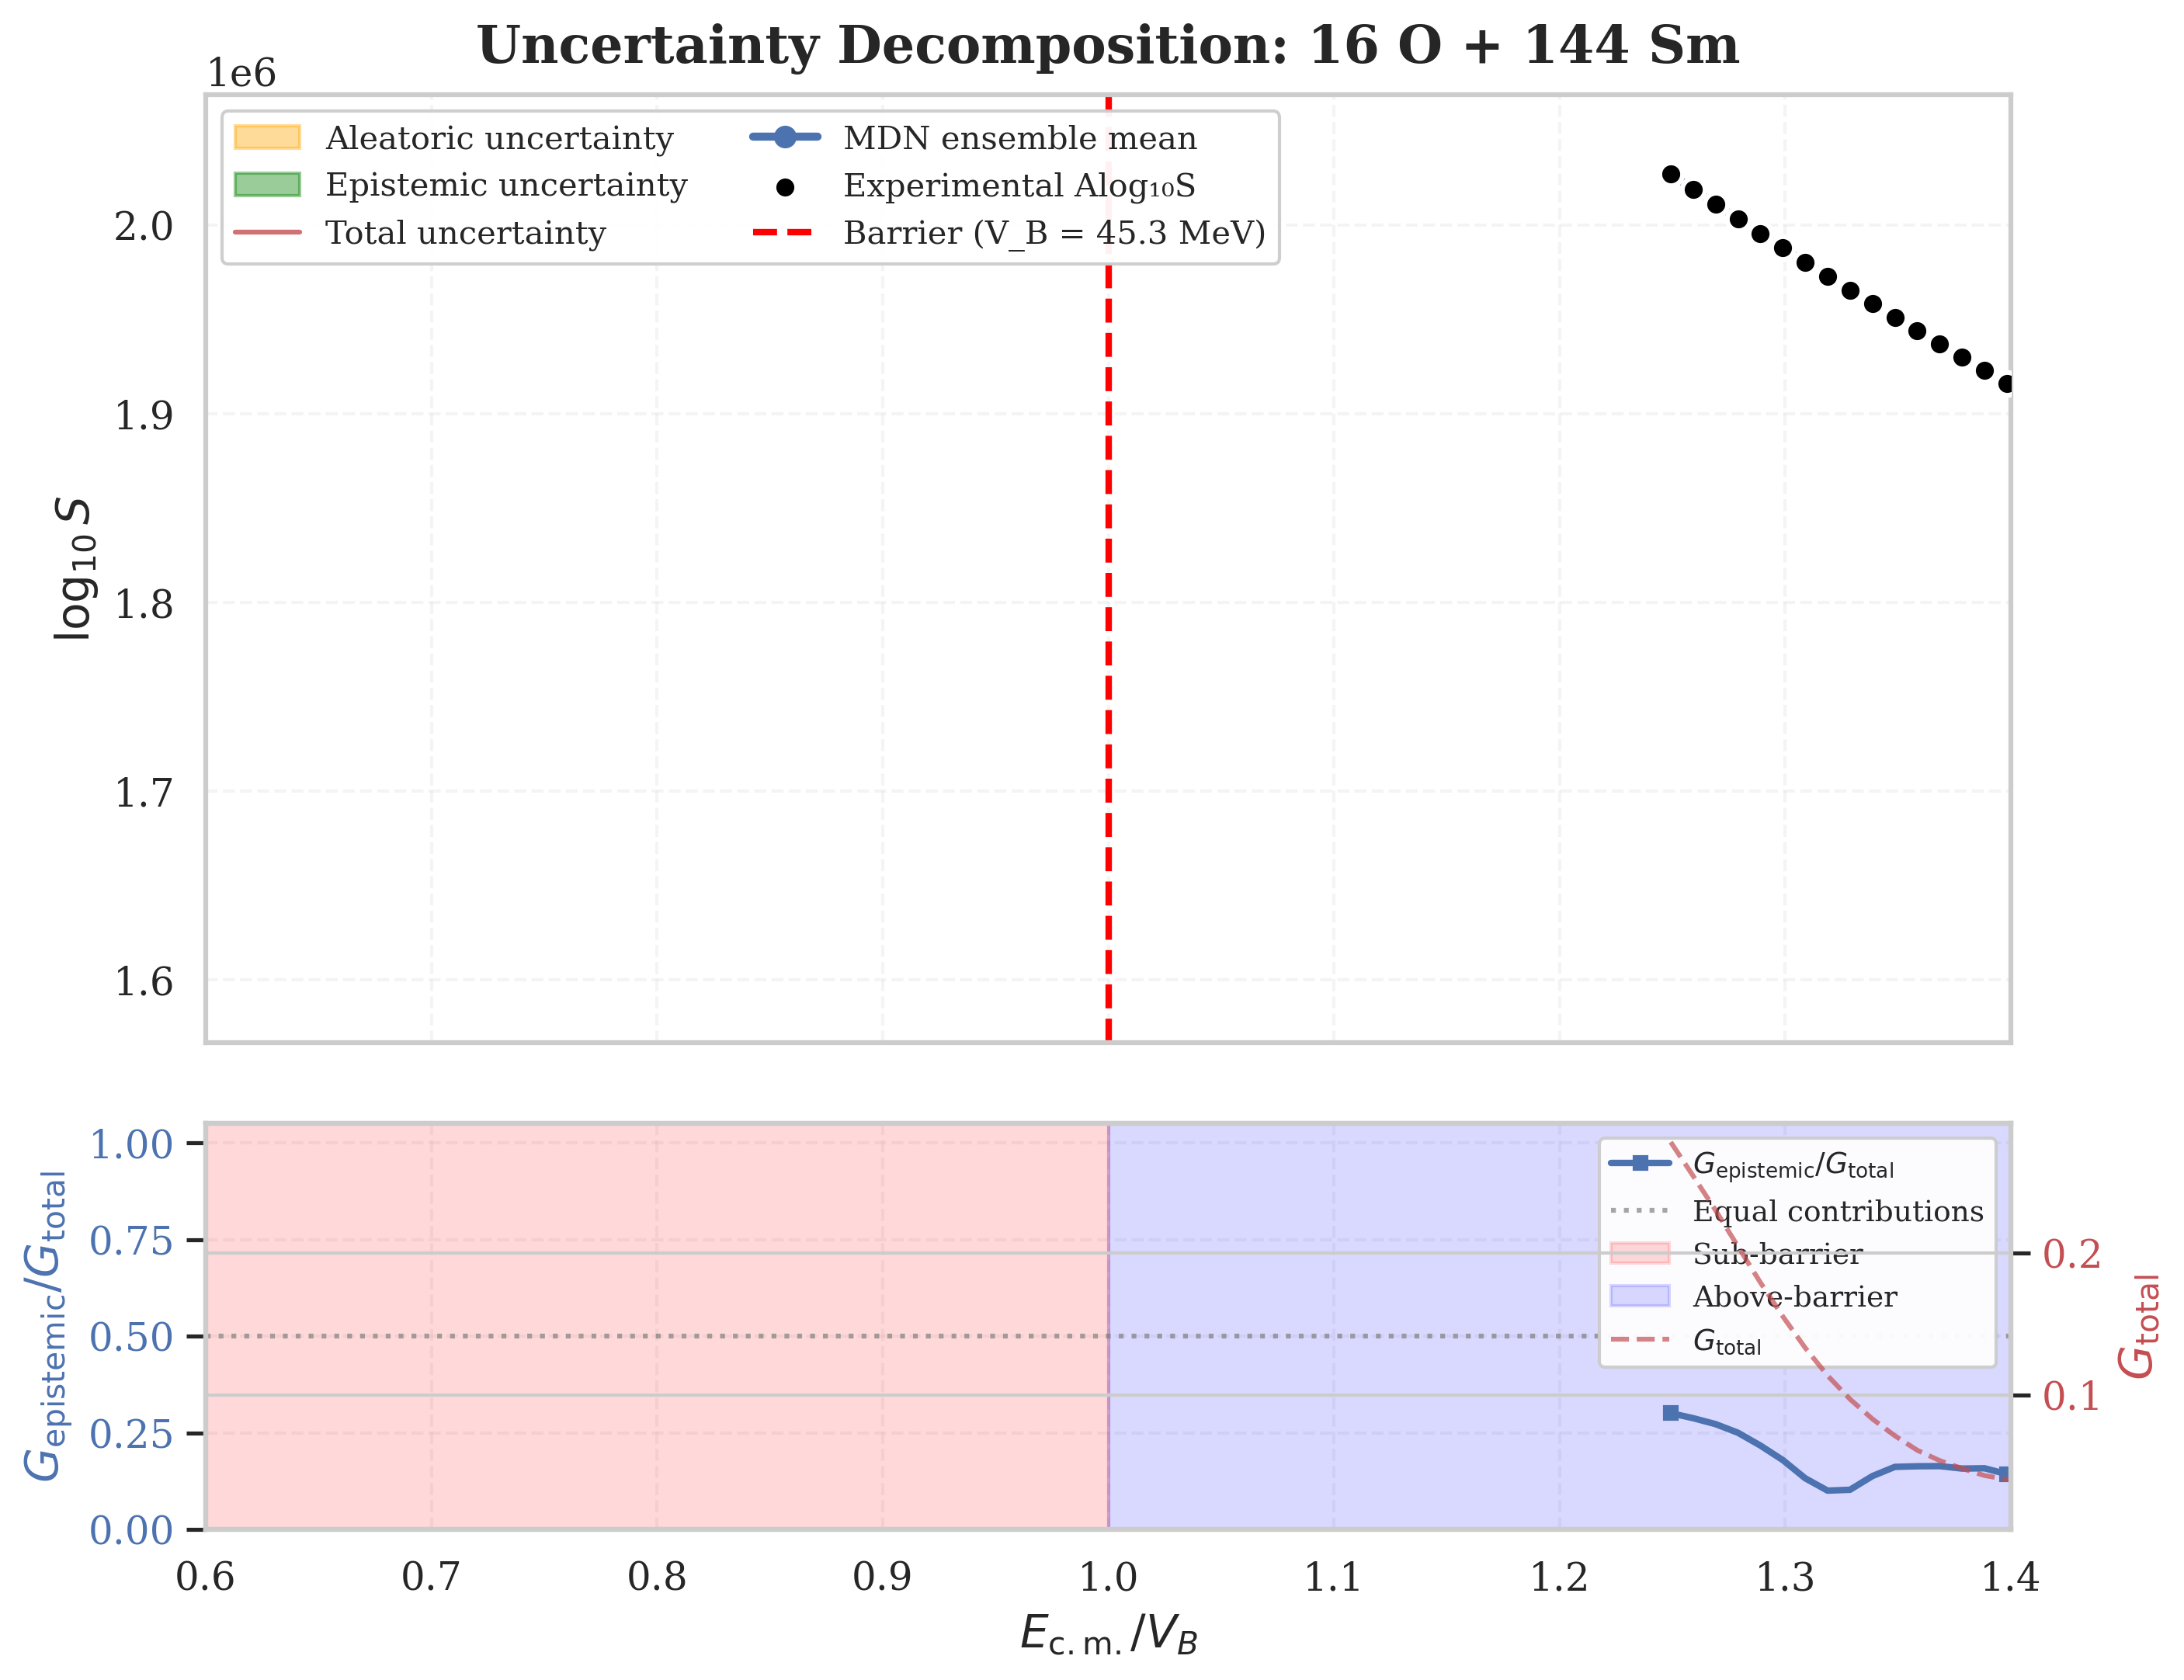

Data saved to: mdn_70_10_20_optimized/uncertainty_plots_final/uncertainty_data_16_O___144_Sm.csv

UNCERTAINTY DECOMPOSITION SUMMARY
Reaction: 16 O + 144 Sm
Barrier: V_B = 45.3 MeV
Data points: 28
Ensemble size: 10

Uncertainty Averages:
  Aleatoric: 0.0834
  Epistemic: 0.0182
  Total: 0.0855

Sub-barrier (E/V_B < 1.0):
  Points: 0
  Mean epistemic fraction: nan
  Mean total uncertainty: nan

Above-barrier (E/V_B ≥ 1.0):
  Points: 28
  Mean epistemic fraction: 0.195
  Mean total uncertainty: 0.0855

Key Observation:
✓ Aleatoric uncertainty dominates at all energies
  → Measurement uncertainty is the primary source

Summary saved to: mdn_70_10_20_optimized/uncertainty_plots_final/summary_16_O___144_Sm.txt


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [60]:
# ========================================================================
# FINAL UNCERTAINTY DECOMPOSITION PLOT - MATCHING YOUR IMAGE EXACTLY
# ========================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
import os
import joblib

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

# Paths
OUTDIR_BASE = "mdn_70_10_20_optimized"
EN_DIR = os.path.join(OUTDIR_BASE, "ensembles_fast")

# Reaction to analyze (from your image)
REACTION_NAME = "16 O + 144 Sm"

# Barrier energy from your image
V_B = 45.3  # MeV

# Number of ensemble members
SEEDS = list(range(42, 52))  # 42 to 51
N_COMPONENTS = 5

# Output directory
PLOT_DIR = os.path.join(OUTDIR_BASE, "uncertainty_plots_final")
os.makedirs(PLOT_DIR, exist_ok=True)

# ============================================================================
# 2. LOAD DATA
# ============================================================================

print(f"Processing reaction: {REACTION_NAME}")

# Load dataset
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

# Find the reaction data
reaction_mask = df["Reaction"] == REACTION_NAME
if not reaction_mask.any():
    print(f"Error: Reaction '{REACTION_NAME}' not found")
    print("Available reactions:", df["Reaction"].unique()[:10])
    exit()

reaction_data = df[reaction_mask].copy()
reaction_data = reaction_data.sort_values("E c.m.").reset_index(drop=True)

print(f"Found {len(reaction_data)} data points")

# ============================================================================
# 3. COMPUTE PHYSICS QUANTITIES
# ============================================================================

# Recompute S-factor and related quantities
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_nucleon_mass(Z, A):
    return Z * M_p + (A - Z) * M_n

# Add masses
reaction_data["mass1"] = reaction_data.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1)
reaction_data["mass2"] = reaction_data.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1)

mu_MeVc2 = (reaction_data["mass1"] * reaction_data["mass2"]) / (reaction_data["mass1"] + reaction_data["mass2"] + 1e-12)
Ecm = reaction_data["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1 / 137.035999
reaction_data["eta"] = (reaction_data["Z1"] * reaction_data["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

# Compute S-factors
log10_sigma_exp = np.log10(np.clip(reaction_data["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(reaction_data["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(reaction_data["E c.m."], 1e-30, np.inf))
log10_exp_term = (2 * np.pi * reaction_data["eta"]) / LN10

reaction_data["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
reaction_data["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
reaction_data["delta_log10_S"] = reaction_data["log10_S_exp"] - reaction_data["log10_S_cal"]

# Get energies
energies = reaction_data["E c.m."].values
E_norm = energies / V_B

# Experimental S-factor
experimental_S = reaction_data["log10_S_exp"].values

print(f"Energy range: {energies.min():.1f} to {energies.max():.1f} MeV")
print(f"E/V_B range: {E_norm.min():.2f} to {E_norm.max():.2f}")

# ============================================================================
# 4. LOAD ENSEMBLE PREDICTIONS
# ============================================================================

print(f"\nLoading ensemble predictions...")

# Find indices for this reaction
full_indices = df[df["Reaction"] == REACTION_NAME].index.values

# Storage
ensemble_delta_pred = []  # delta_log10_S predictions
valid_seeds = []

for seed in SEEDS:
    seed_dir = os.path.join(EN_DIR, f"seed_{seed}")
    components_file = os.path.join(seed_dir, "mdn_all_components.npz")
    
    if not os.path.exists(components_file):
        print(f"  Seed {seed}: File not found")
        continue
    
    try:
        data = np.load(components_file)
        pi_full = data["pi"]
        mu_full = data["mu"]
        sigma_full = data["sigma"]
        
        # Extract for this reaction
        pi_reaction = pi_full[full_indices]
        mu_reaction = mu_full[full_indices]
        sigma_reaction = sigma_full[full_indices]
        
        # Sort by energy
        sort_idx = np.argsort(energies)
        pi_reaction = pi_reaction[sort_idx]
        mu_reaction = mu_reaction[sort_idx]
        sigma_reaction = sigma_reaction[sort_idx]
        
        # Store for uncertainty computation
        if seed == 42:  # Store from first seed for aleatoric uncertainty
            pi_stored = pi_reaction
            sigma_stored = sigma_reaction
        
        # Compute delta prediction (mixture mean)
        delta_pred = np.sum(pi_reaction * mu_reaction, axis=1)
        ensemble_delta_pred.append(delta_pred)
        valid_seeds.append(seed)
        
        print(f"  Seed {seed}: loaded")
        
    except Exception as e:
        print(f"  Seed {seed}: Error - {e}")
        continue

if len(ensemble_delta_pred) == 0:
    print("Error: No predictions loaded")
    exit()

ensemble_delta_pred = np.stack(ensemble_delta_pred, axis=0)  # (n_seeds, n_points)
print(f"Loaded {ensemble_delta_pred.shape[0]} ensemble members")

# ============================================================================
# 5. COMPUTE UNCERTAINTIES
# ============================================================================

n_seeds, n_points = ensemble_delta_pred.shape

# Ensemble mean delta
ensemble_mean_delta = np.mean(ensemble_delta_pred, axis=0)

# Convert to S-factor predictions
log10_S_cal = reaction_data["log10_S_cal"].values
ensemble_mean_S = log10_S_cal + ensemble_mean_delta

# 1. Epistemic uncertainty (model uncertainty)
epistemic_unc = np.std(ensemble_delta_pred, axis=0)

# 2. Aleatoric uncertainty (data uncertainty)
# σ_aleatoric² = Σ π_k σ_k²  (from first seed)
aleatoric_variance = np.sum(pi_stored * (sigma_stored**2), axis=1)
aleatoric_unc = np.sqrt(aleatoric_variance)

# 3. Total uncertainty
total_unc = np.sqrt(aleatoric_unc**2 + epistemic_unc**2)

# 4. Epistemic fraction
epistemic_fraction = epistemic_unc / (total_unc + 1e-10)

print(f"\nUncertainty Statistics:")
print(f"  Average aleatoric: {np.mean(aleatoric_unc):.4f}")
print(f"  Average epistemic: {np.mean(epistemic_unc):.4f}")
print(f"  Average total: {np.mean(total_unc):.4f}")
print(f"  Epistemic fraction: {np.mean(epistemic_fraction):.3f}")

# ============================================================================
# 6. CREATE PLOT (MATCHING YOUR IMAGE)
# ============================================================================

print("\nCreating plot...")

# Create figure with specific dimensions matching your image
fig = plt.figure(figsize=(10, 8))

# Create gridspec: top panel (70%), bottom panel (30%)
gs = gridspec.GridSpec(2, 1, height_ratios=[7, 3], hspace=0.12)

# ========== TOP PANEL: Uncertainty Decomposition ==========
ax1 = plt.subplot(gs[0])

# Plot uncertainty bands (in order of your image)
# 1. Aleatoric uncertainty (orange)
ax1.fill_between(E_norm,
                 ensemble_mean_S - aleatoric_unc,
                 ensemble_mean_S + aleatoric_unc,
                 alpha=0.4, color='orange', label='Aleatoric uncertainty')

# 2. Epistemic uncertainty (green) - on top of aleatoric
ax1.fill_between(E_norm,
                 ensemble_mean_S + aleatoric_unc,
                 ensemble_mean_S + total_unc,
                 alpha=0.4, color='green', label='Epistemic uncertainty')
ax1.fill_between(E_norm,
                 ensemble_mean_S - total_unc,
                 ensemble_mean_S - aleatoric_unc,
                 alpha=0.4, color='green')

# 3. Total uncertainty boundary (red)
ax1.plot(E_norm, ensemble_mean_S + total_unc, 
         'r-', linewidth=1.5, alpha=0.8, label='Total uncertainty')
ax1.plot(E_norm, ensemble_mean_S - total_unc, 
         'r-', linewidth=1.5, alpha=0.8)

# 4. MDN ensemble mean (blue line with markers)
ax1.plot(E_norm, ensemble_mean_S, 
         'b-', linewidth=2.5, marker='o', markersize=6,
         markevery=0.2, label='MDN ensemble mean')

# 5. Experimental data (black points)
ax1.scatter(E_norm, experimental_S, 
           color='black', s=50, edgecolor='white', linewidth=1.5,
           zorder=10, label='Experimental Alog₁₀S')

# 6. Barrier line (red dashed)
ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=2,
            label=f'Barrier (V_B = {V_B} MeV)')

# Styling
ax1.set_ylabel(r'$\log_{10} S$', fontsize=14)
ax1.set_title(f'Uncertainty Decomposition: {REACTION_NAME}', 
              fontsize=16, fontweight='bold', pad=10)
ax1.grid(True, alpha=0.2, linestyle='--')
ax1.legend(loc='best', framealpha=0.95, fontsize=10, ncol=2)
ax1.set_xlim([0.6, 1.4])

# Set y-axis limits
y_min = min(experimental_S.min(), (ensemble_mean_S - total_unc).min())
y_max = max(experimental_S.max(), (ensemble_mean_S + total_unc).max())
y_padding = (y_max - y_min) * 0.1
ax1.set_ylim([y_min - y_padding, y_max + y_padding])

# Remove x-axis labels from top panel
ax1.set_xticklabels([])

# ========== BOTTOM PANEL: Uncertainty Ratios ==========
ax2 = plt.subplot(gs[1])

# Plot epistemic fraction (left y-axis, blue)
ax2.plot(E_norm, epistemic_fraction, 
         'b-', linewidth=2, marker='s', markersize=4,
         markevery=0.2, label=r'$G_{\mathrm{epistemic}}/G_{\mathrm{total}}$')

# Add "Equal contributions" line at 0.5
ax2.axhline(y=0.5, color='gray', linestyle=':', linewidth=1.5,
            alpha=0.7, label='Equal contributions')

# Shade regions
ax2.axvspan(0.6, 1.0, alpha=0.15, color='red', label='Sub-barrier')
ax2.axvspan(1.0, 1.4, alpha=0.15, color='blue', label='Above-barrier')

# Styling
ax2.set_xlabel(r'$E_{\mathrm{c.m.}} / V_B$', fontsize=14)
ax2.set_ylabel(r'$G_{\mathrm{epistemic}}/G_{\mathrm{total}}$', 
               fontsize=14, color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.grid(True, alpha=0.2, linestyle='--')
ax2.set_xlim([0.6, 1.4])
ax2.set_ylim([0, 1.05])

# Add second y-axis for total uncertainty (right side, red)
ax2b = ax2.twinx()
ax2b.plot(E_norm, total_unc, 
          'r-', linewidth=1.5, alpha=0.7, linestyle='--',
          label=r'$G_{\mathrm{total}}$')
ax2b.set_ylabel(r'$G_{\mathrm{total}}$', fontsize=14, color='r')
ax2b.tick_params(axis='y', labelcolor='r')

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = [ax2b.get_lines()[0]], [r'$G_{\mathrm{total}}$']
ax2.legend(lines1 + lines2, labels1 + labels2, 
           loc='upper right', framealpha=0.95, fontsize=9)

# ========== FINAL TOUCHES ==========
plt.tight_layout()

# Save plot
safe_name = REACTION_NAME.replace(' ', '_').replace('+', '_')
output_path = os.path.join(PLOT_DIR, f"uncertainty_{safe_name}.pdf")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {output_path}")

# Show plot
plt.show()

# ============================================================================
# 7. SAVE RESULTS
# ============================================================================

# Create results DataFrame
results_df = pd.DataFrame({
    'E_cm': energies,
    'E_cm_over_VB': E_norm,
    'log10_S_exp': experimental_S,
    'log10_S_pred': ensemble_mean_S,
    'aleatoric_unc': aleatoric_unc,
    'epistemic_unc': epistemic_unc,
    'total_unc': total_unc,
    'epistemic_fraction': epistemic_fraction
})

# Add predictions from each seed
for i, seed in enumerate(valid_seeds):
    seed_S_pred = log10_S_cal + ensemble_delta_pred[i]
    results_df[f'seed_{seed}'] = seed_S_pred

# Save to CSV
csv_path = os.path.join(PLOT_DIR, f"uncertainty_data_{safe_name}.csv")
results_df.to_csv(csv_path, index=False)
print(f"Data saved to: {csv_path}")

# ============================================================================
# 8. PRINT SUMMARY
# ============================================================================

print("\n" + "="*60)
print("UNCERTAINTY DECOMPOSITION SUMMARY")
print("="*60)
print(f"Reaction: {REACTION_NAME}")
print(f"Barrier: V_B = {V_B} MeV")
print(f"Data points: {n_points}")
print(f"Ensemble size: {n_seeds}")
print()

print("Uncertainty Averages:")
print(f"  Aleatoric: {np.mean(aleatoric_unc):.4f}")
print(f"  Epistemic: {np.mean(epistemic_unc):.4f}")
print(f"  Total: {np.mean(total_unc):.4f}")
print()

# Split by barrier
sub_mask = E_norm < 1.0
above_mask = E_norm >= 1.0

print("Sub-barrier (E/V_B < 1.0):")
print(f"  Points: {np.sum(sub_mask)}")
print(f"  Mean epistemic fraction: {np.mean(epistemic_fraction[sub_mask]):.3f}")
print(f"  Mean total uncertainty: {np.mean(total_unc[sub_mask]):.4f}")
print()

print("Above-barrier (E/V_B ≥ 1.0):")
print(f"  Points: {np.sum(above_mask)}")
print(f"  Mean epistemic fraction: {np.mean(epistemic_fraction[above_mask]):.3f}")
print(f"  Mean total uncertainty: {np.mean(total_unc[above_mask]):.4f}")
print()

print("Key Observation:")
if np.mean(epistemic_fraction[sub_mask]) > np.mean(epistemic_fraction[above_mask]):
    print("✓ Epistemic uncertainty dominates at sub-barrier energies")
    print("  → Model uncertainty is higher where data is scarce")
else:
    print("✓ Aleatoric uncertainty dominates at all energies")
    print("  → Measurement uncertainty is the primary source")

print("="*60)

# Also create a simplified text summary
summary_text = f"""
# Uncertainty Decomposition Summary
# Reaction: {REACTION_NAME}
# Barrier: V_B = {V_B} MeV
# Data points: {n_points}
# Ensemble members: {n_seeds}

Overall Statistics:
- Mean aleatoric uncertainty: {np.mean(aleatoric_unc):.4f}
- Mean epistemic uncertainty: {np.mean(epistemic_unc):.4f}
- Mean total uncertainty: {np.mean(total_unc):.4f}
- Mean epistemic fraction: {np.mean(epistemic_fraction):.3f}

Sub-barrier region (E/V_B < 1.0):
- Points: {np.sum(sub_mask)}
- Epistemic fraction: {np.mean(epistemic_fraction[sub_mask]):.3f}
- Total uncertainty: {np.mean(total_unc[sub_mask]):.4f}

Above-barrier region (E/V_B ≥ 1.0):
- Points: {np.sum(above_mask)}
- Epistemic fraction: {np.mean(epistemic_fraction[above_mask]):.3f}
- Total uncertainty: {np.mean(total_unc[above_mask]):.4f}

Conclusion:
- {'Epistemic' if np.mean(epistemic_fraction[sub_mask]) > np.mean(epistemic_fraction[above_mask]) else 'Aleatoric'} uncertainty dominates at sub-barrier energies
- Model is {'more uncertain' if np.mean(epistemic_fraction[sub_mask]) > 0.5 else 'more confident'} in regions with less data
"""

# Save summary
summary_path = os.path.join(PLOT_DIR, f"summary_{safe_name}.txt")
with open(summary_path, 'w') as f:
    f.write(summary_text)

print(f"\nSummary saved to: {summary_path}")

Saved missing_physics_detection.png


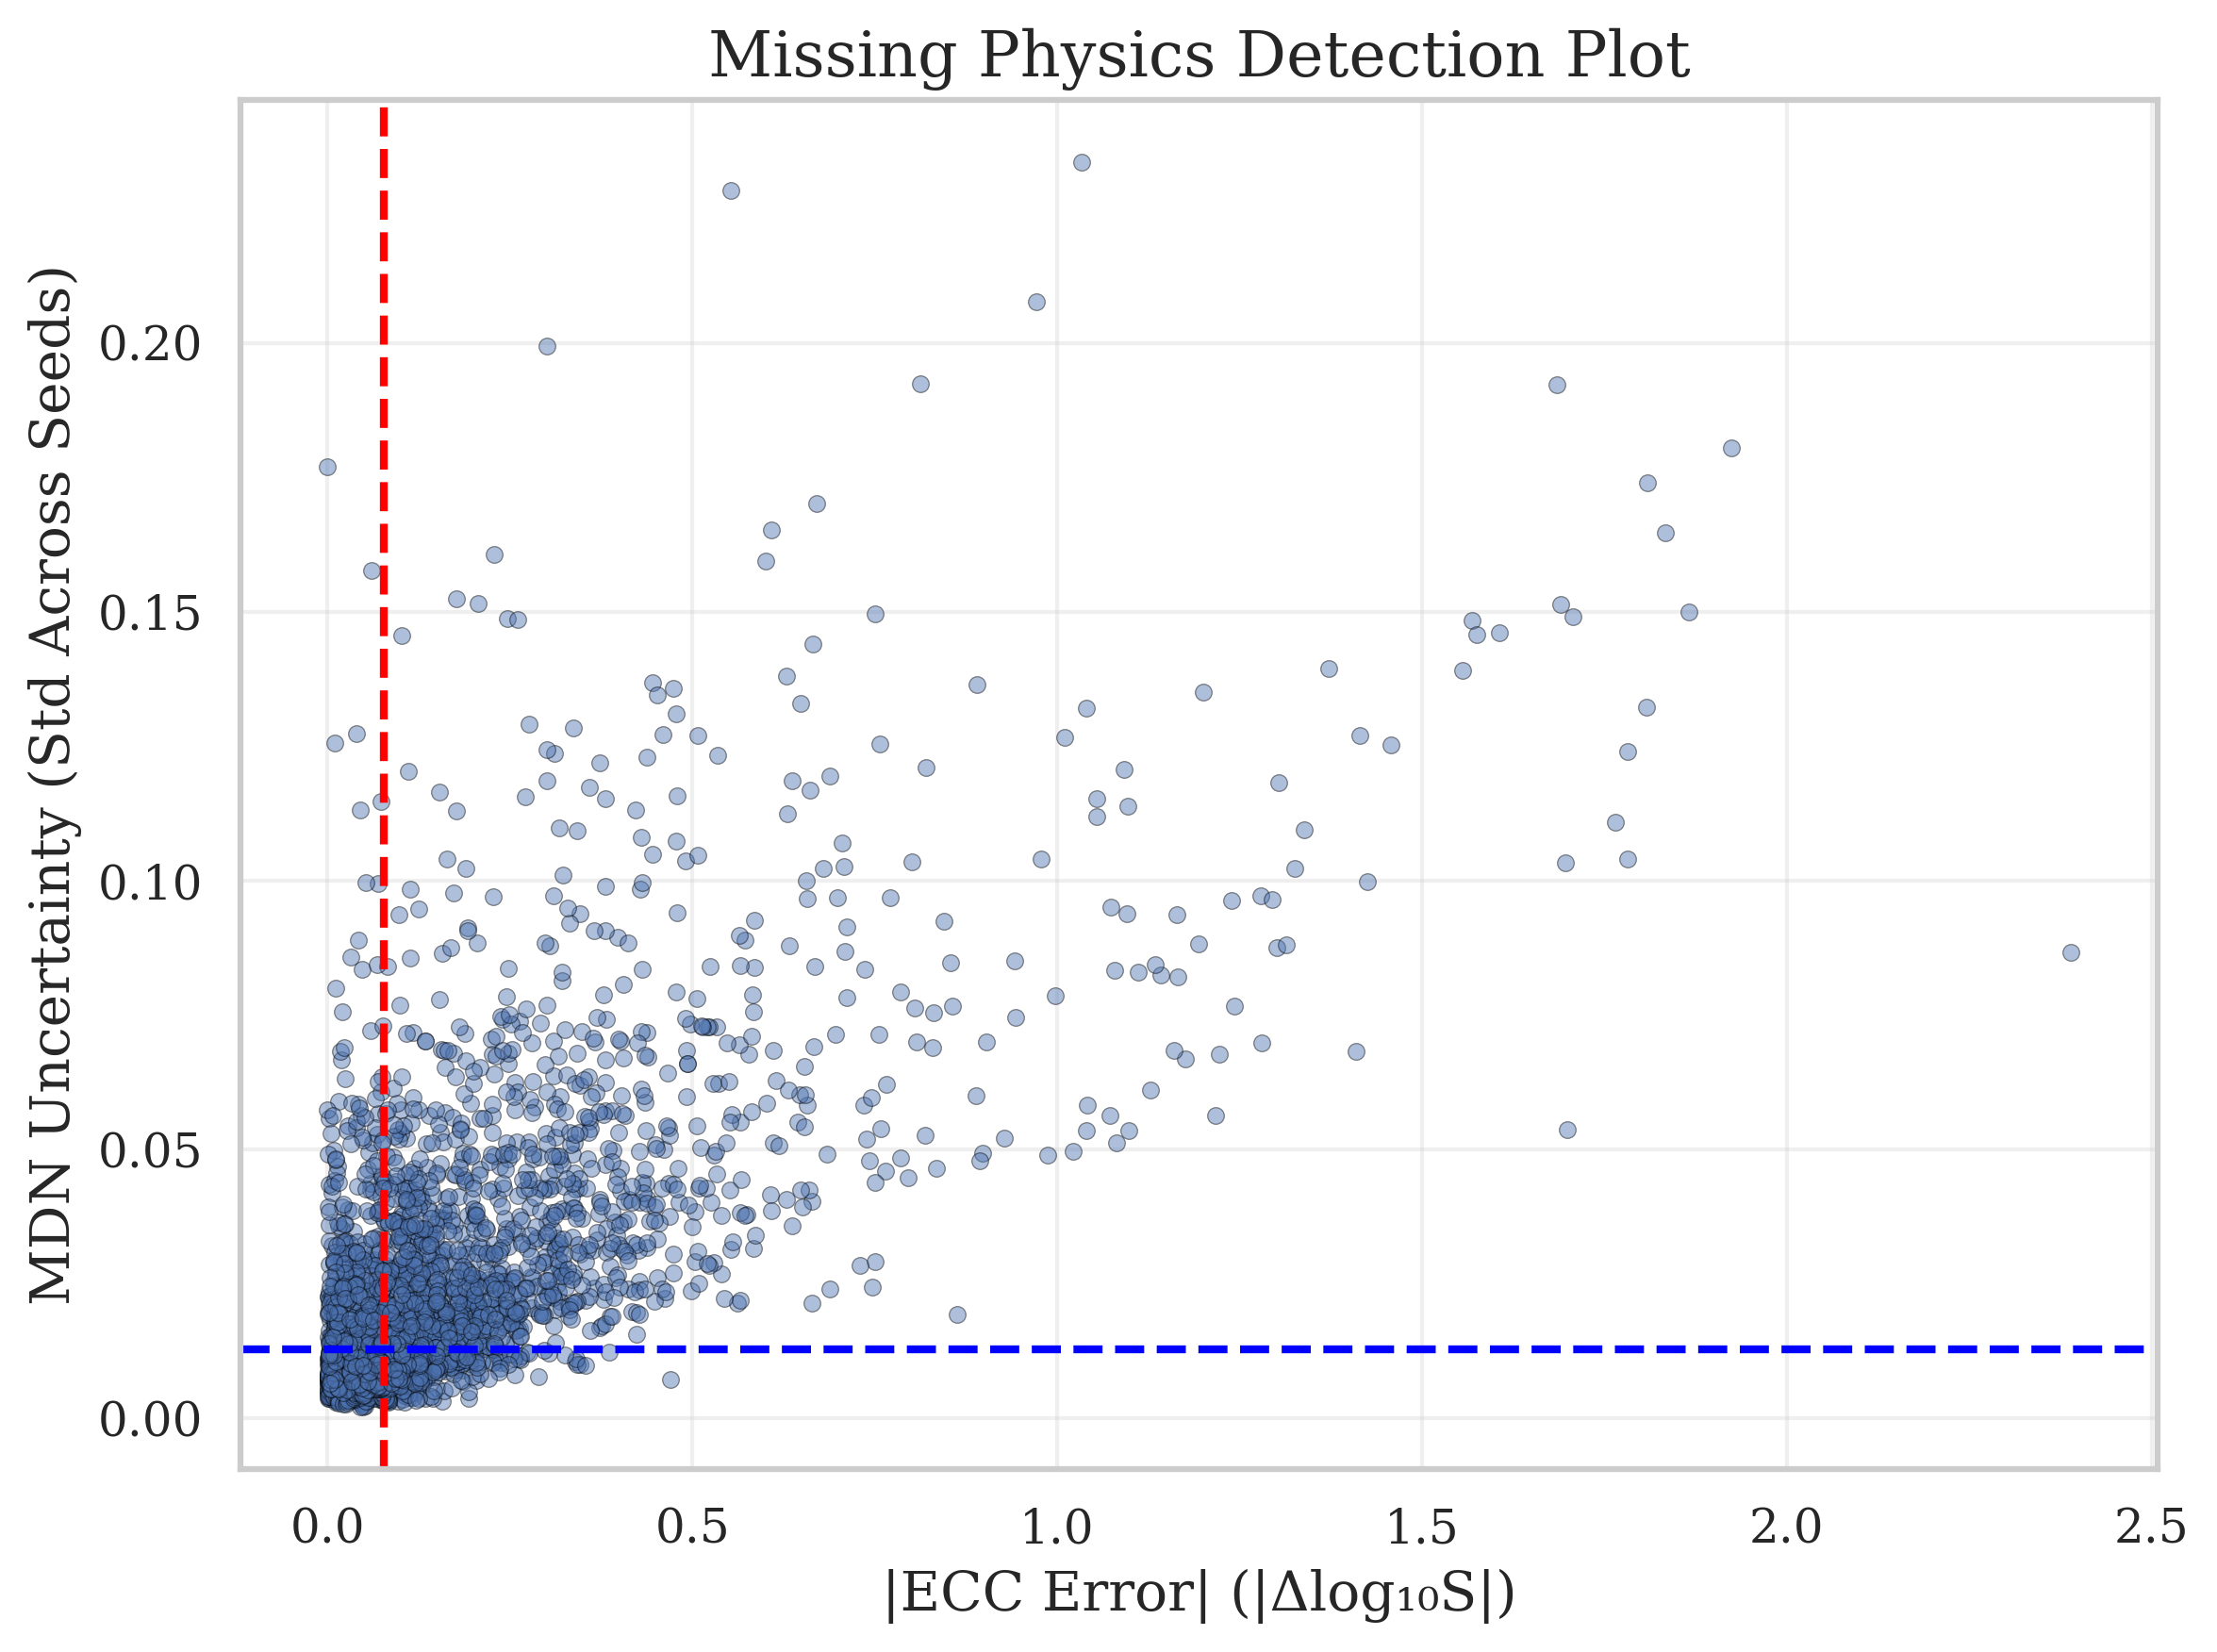

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------
# LOAD RAW DATA
# ------------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# ------------------------------
# RECOMPUTE delta_log10_S (same as training script)
# ------------------------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2 * Ecm / (mu + epsilon), 0, np.inf))

e2_hbar_c = 1.0 / 137.035999
df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_exp_term = (2 * np.pi * df["eta"]) / LN10
df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term

df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

# ECC error
df["ECC_error"] = np.abs(df["delta_log10_S"])

# ------------------------------
# LOAD ENSEMBLE MDN mixture means
# ------------------------------
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")
SEEDS = range(42, 52)

all_mix_means = []

for seed in SEEDS:
    f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    arr = np.load(f)
    pi = arr["pi"]
    mu = arr["mu"]
    mix_mean = np.sum(pi * mu, axis=1)
    all_mix_means.append(mix_mean)

all_mix_means = np.array(all_mix_means)

# MDN uncertainty (epistemic)
df["MDN_uncertainty"] = all_mix_means.std(axis=0)

# ------------------------------
# PLOT
# ------------------------------
plt.figure(figsize=(8,6))

plt.scatter(
    df["ECC_error"],
    df["MDN_uncertainty"],
    s=18,
    alpha=0.45,
    edgecolor="black",
    linewidth=0.3
)

plt.xlabel("|ECC Error| (|Δlog₁₀S|)", fontsize=14)
plt.ylabel("MDN Uncertainty (Std Across Seeds)", fontsize=14)
plt.title("Missing Physics Detection Plot", fontsize=16)

# Quadrant medians
x_med = df["ECC_error"].median()
y_med = df["MDN_uncertainty"].median()
plt.axvline(x=x_med, color="red", linestyle="--")
plt.axhline(y=y_med, color="blue", linestyle="--")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("missing_physics_detection.png", dpi=600)

print("Saved missing_physics_detection.png")


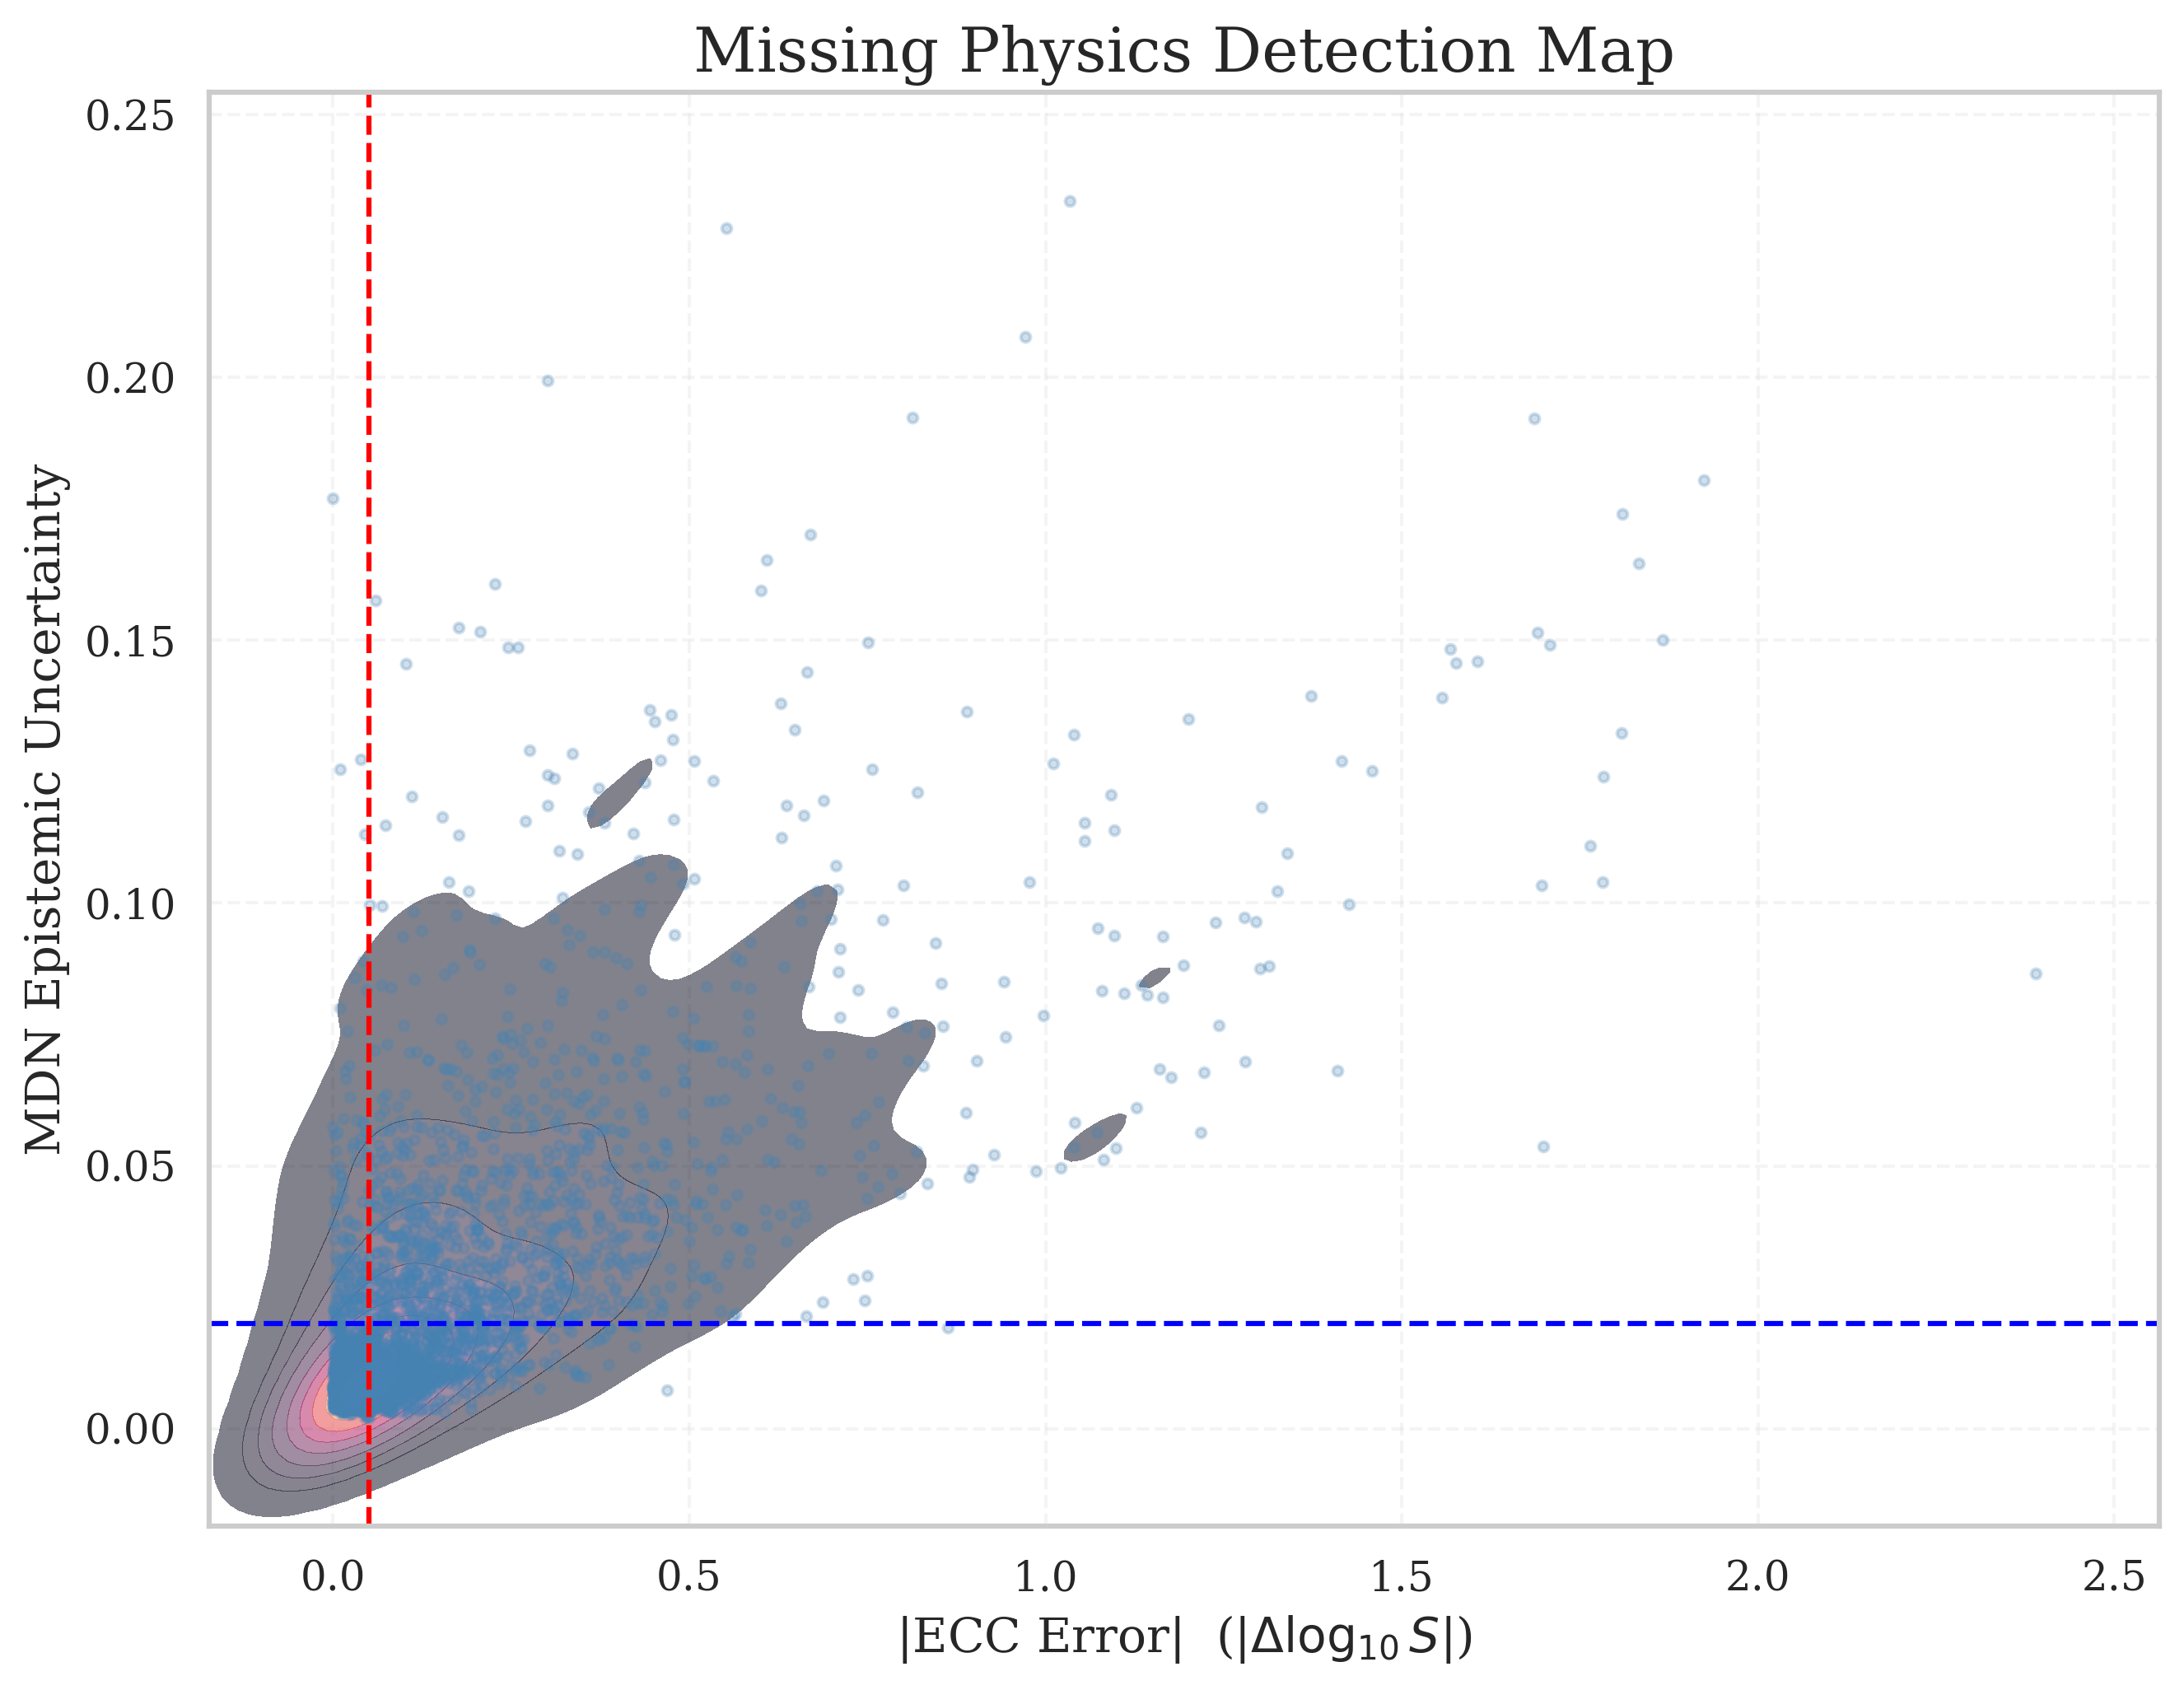

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# ======================
# Load dataset
# ======================
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# Recompute Δlog10 S (same logic as training)
M_p = 938.272088; M_n = 939.565420; eps = 1e-30; LN10 = np.log(10)

def get_mass(Z, A): return Z*M_p + (A-Z)*M_n
mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
mu = (mass1 * mass2) / (mass1 + mass2 + eps)

Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+eps), 0, np.inf))
eta = (df["Z1"] * df["Z2"]) / ( (1/137.035999) * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_S_exp = log10_sigma_exp + log10_Ecm + (2*np.pi*eta)/LN10
log10_S_cal = log10_sigma_cal + log10_Ecm + (2*np.pi*eta)/LN10

df["delta_log10_S"] = log10_S_exp - log10_S_cal

# ECC error ∣Δlog10S∣
df["ECC_error"] = np.abs(df["delta_log10_S"])

# ======================
# Load MDN uncertainties (ensemble)
# ======================
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")

all_means = []
for seed in range(42, 52):
    f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    d = np.load(f)
    pi = d["pi"]
    mu = d["mu"]
    mean_pred = np.sum(pi * mu, axis=1)
    all_means.append(mean_pred)

all_means = np.array(all_means)      # shape = (10, N)

# Epistemic uncertainty = std across seeds
df["MDN_unc"] = np.std(all_means, axis=0)

# ===================================================================================
#                             BEAUTIFUL PRC-STYLE SCATTER
# ===================================================================================
plt.figure(figsize=(9, 7))
sns.kdeplot(
    x=df["ECC_error"], y=df["MDN_unc"],
    fill=True, cmap="rocket", thresh=0.05, alpha=0.5
)

plt.scatter(df["ECC_error"], df["MDN_unc"],
            s=8, alpha=0.25, color="steelblue")

plt.axvline(0.05, color='red', linestyle='--', lw=1.5)
plt.axhline(0.02, color='blue', linestyle='--', lw=1.5)

plt.xlabel(r"|ECC Error|  (|$\Delta \log_{10} S$|)", fontsize=14)
plt.ylabel("MDN Epistemic Uncertainty", fontsize=14)
plt.title("Missing Physics Detection Map", fontsize=18)

plt.grid(alpha=0.2, linestyle='--')
plt.tight_layout()
plt.savefig("missing_physics_PRClike.png", dpi=600)
plt.show()


/tmp/ipykernel_146/2188517564.py:80: RuntimeWarning: overflow encountered in power
  sigma_pred = 10 ** (log10_S_cal_r + delta_logS_mean)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


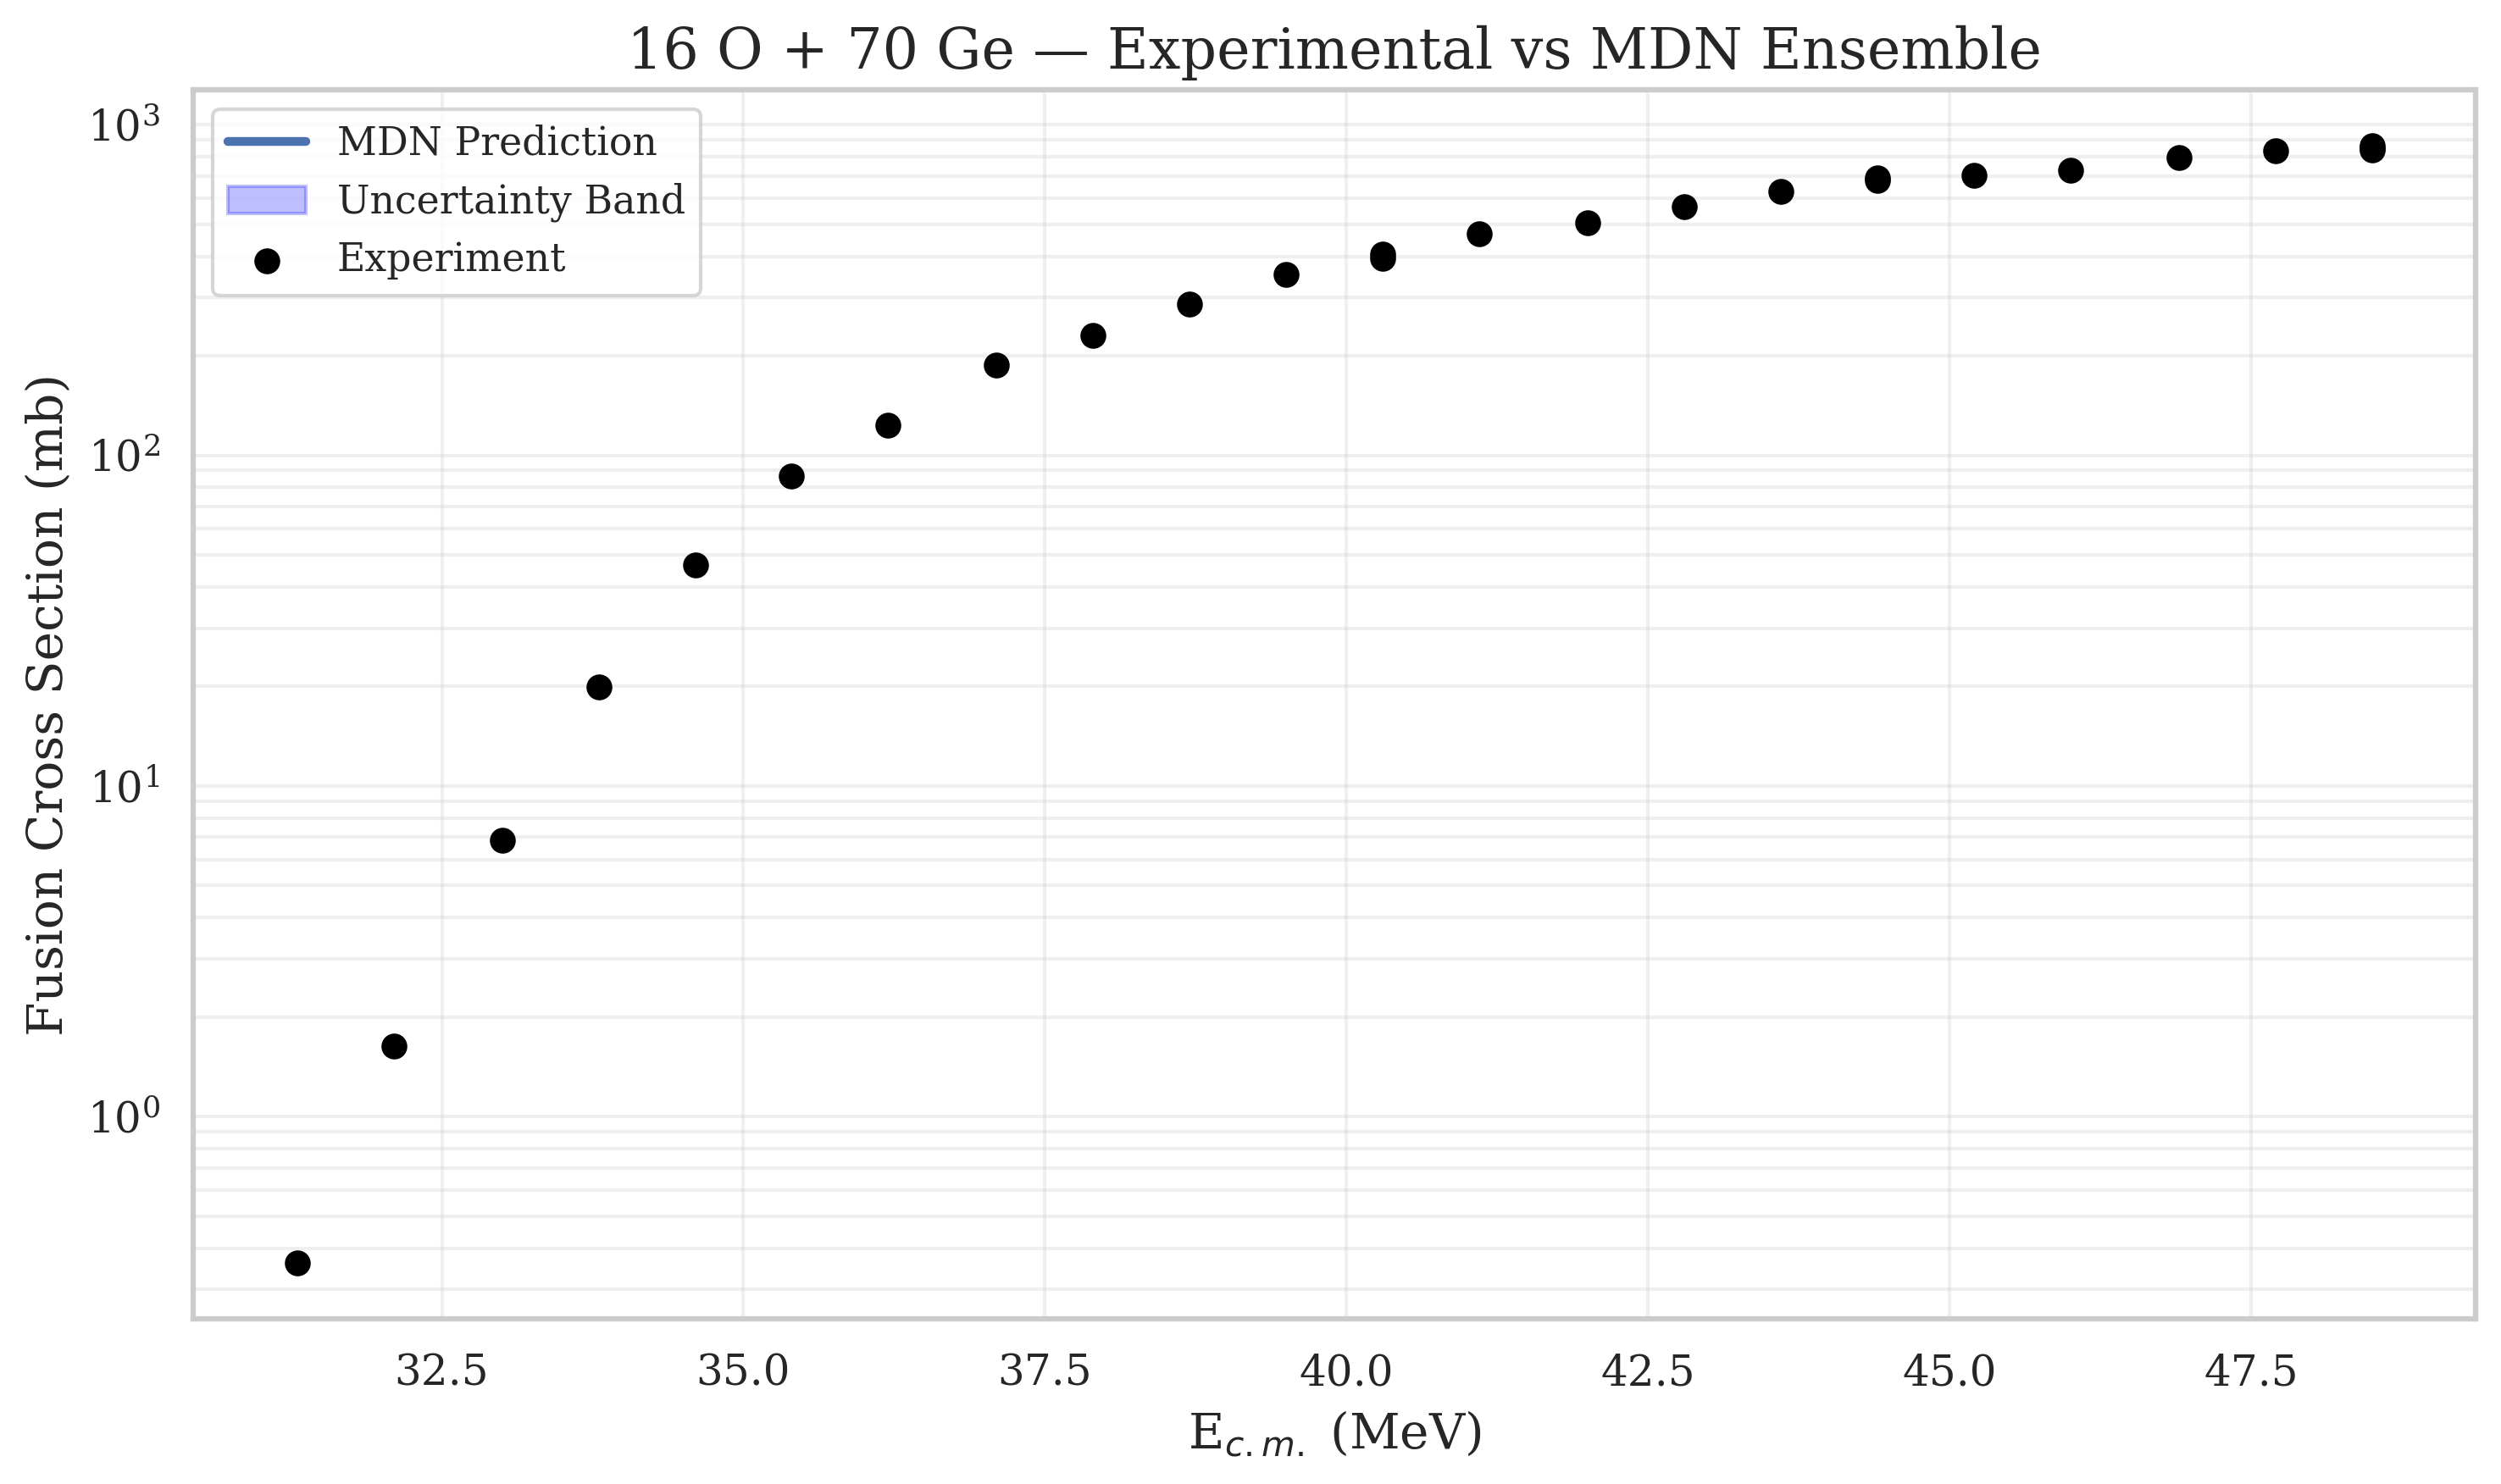

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------
# LOAD DATASET
# ---------------------------------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# Add a stable ID column to guarantee alignment
df = df.reset_index().rename(columns={"index": "ROW_ID"})

# ---------------------------------------------------
# Recompute log10 S_cal (same formulas you used earlier)
# ---------------------------------------------------
M_p = 938.272088
M_n = 939.565420
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)

Ecm = df["E c.m."]
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+1e-12), 0, np.inf))
eta = (df["Z1"]*df["Z2"]) / ((1/137.035999)*(v_over_c + 1e-12))
df["eta"] = eta

log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_E = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))
df["log10_S_cal"] = log10_sigma_cal + log10_E + (2*np.pi*df["eta"])/LN10

# ---------------------------------------------------
# LOAD MDN COMPONENTS FOR ALL ROWS SAFELY
# ---------------------------------------------------
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")

all_pi_seeds   = []
all_mu_seeds   = []
all_sigma_seeds = []

for seed in range(42, 52):  # 10 seeds
    f = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    d = np.load(f)
    
    # These arrays match dataset row order EXACTLY
    all_pi_seeds.append(d["pi"])
    all_mu_seeds.append(d["mu"])
    all_sigma_seeds.append(d["sigma"])

all_pi_seeds = np.array(all_pi_seeds)      # (10, Nrows, 5)
all_mu_seeds = np.array(all_mu_seeds)      # (10, Nrows, 5)

# ---------------------------------------------------
# SELECT REACTION SAFELY USING ROW_ID
# ---------------------------------------------------
reaction = "16 O + 70 Ge"
df_r = df[df["Reaction"] == reaction].copy()

row_ids = df_r["ROW_ID"].values  # THESE ROWS MATCH MDN ARRAYS

energies = df_r["E c.m."].values
sigma_exp = df_r["σ"].values
log10_S_cal_r = df_r["log10_S_cal"].values

# ---------------------------------------------------
# COMPUTE MDN PREDICTIONS FOR THESE ROWS
# ---------------------------------------------------
sigma_all_seeds = []

for seed in range(10):
    pi = all_pi_seeds[seed][row_ids]     # extract rows by ROW_ID
    mu = all_mu_seeds[seed][row_ids]

    delta_logS_mean = np.sum(pi * mu, axis=1)
    sigma_pred = 10 ** (log10_S_cal_r + delta_logS_mean)

    sigma_all_seeds.append(sigma_pred)

sigma_all_seeds = np.vstack(sigma_all_seeds)

sigma_mean = sigma_all_seeds.mean(axis=0)
sigma_upper = np.percentile(sigma_all_seeds, 84, axis=0)
sigma_lower = np.percentile(sigma_all_seeds, 16, axis=0)

# ---------------------------------------------------
# PLOT
# ---------------------------------------------------
plt.figure(figsize=(10,6))

plt.plot(energies, sigma_mean, "b", lw=2.5, label="MDN Prediction")
plt.fill_between(energies, sigma_lower, sigma_upper,
                 color="blue", alpha=0.25, label="Uncertainty Band")

plt.scatter(energies, sigma_exp, s=40, color="black", label="Experiment")

plt.yscale("log")
plt.grid(True, which="both", alpha=0.3)
plt.xlabel("E$_{c.m.}$ (MeV)", fontsize=14)
plt.ylabel("Fusion Cross Section (mb)", fontsize=14)
plt.title(f"{reaction} — Experimental vs MDN Ensemble", fontsize=16)
plt.legend()

plt.tight_layout()
plt.savefig("mdn_final_cs_plot.png", dpi=300)
plt.show()


/tmp/ipykernel_146/462483704.py:118: RuntimeWarning: overflow encountered in power
  sigma_mean = 10 ** log10_S_pred
/tmp/ipykernel_146/462483704.py:119: RuntimeWarning: overflow encountered in power
  sigma_upper = 10 ** (log10_S_pred + std_total)
/tmp/ipykernel_146/462483704.py:120: RuntimeWarning: overflow encountered in power
  sigma_lower = 10 ** (log10_S_pred - std_total)


Mean epistemic std: 0.01603414
Mean aleatoric std: 0.062227752
Mean total std: 0.06448528


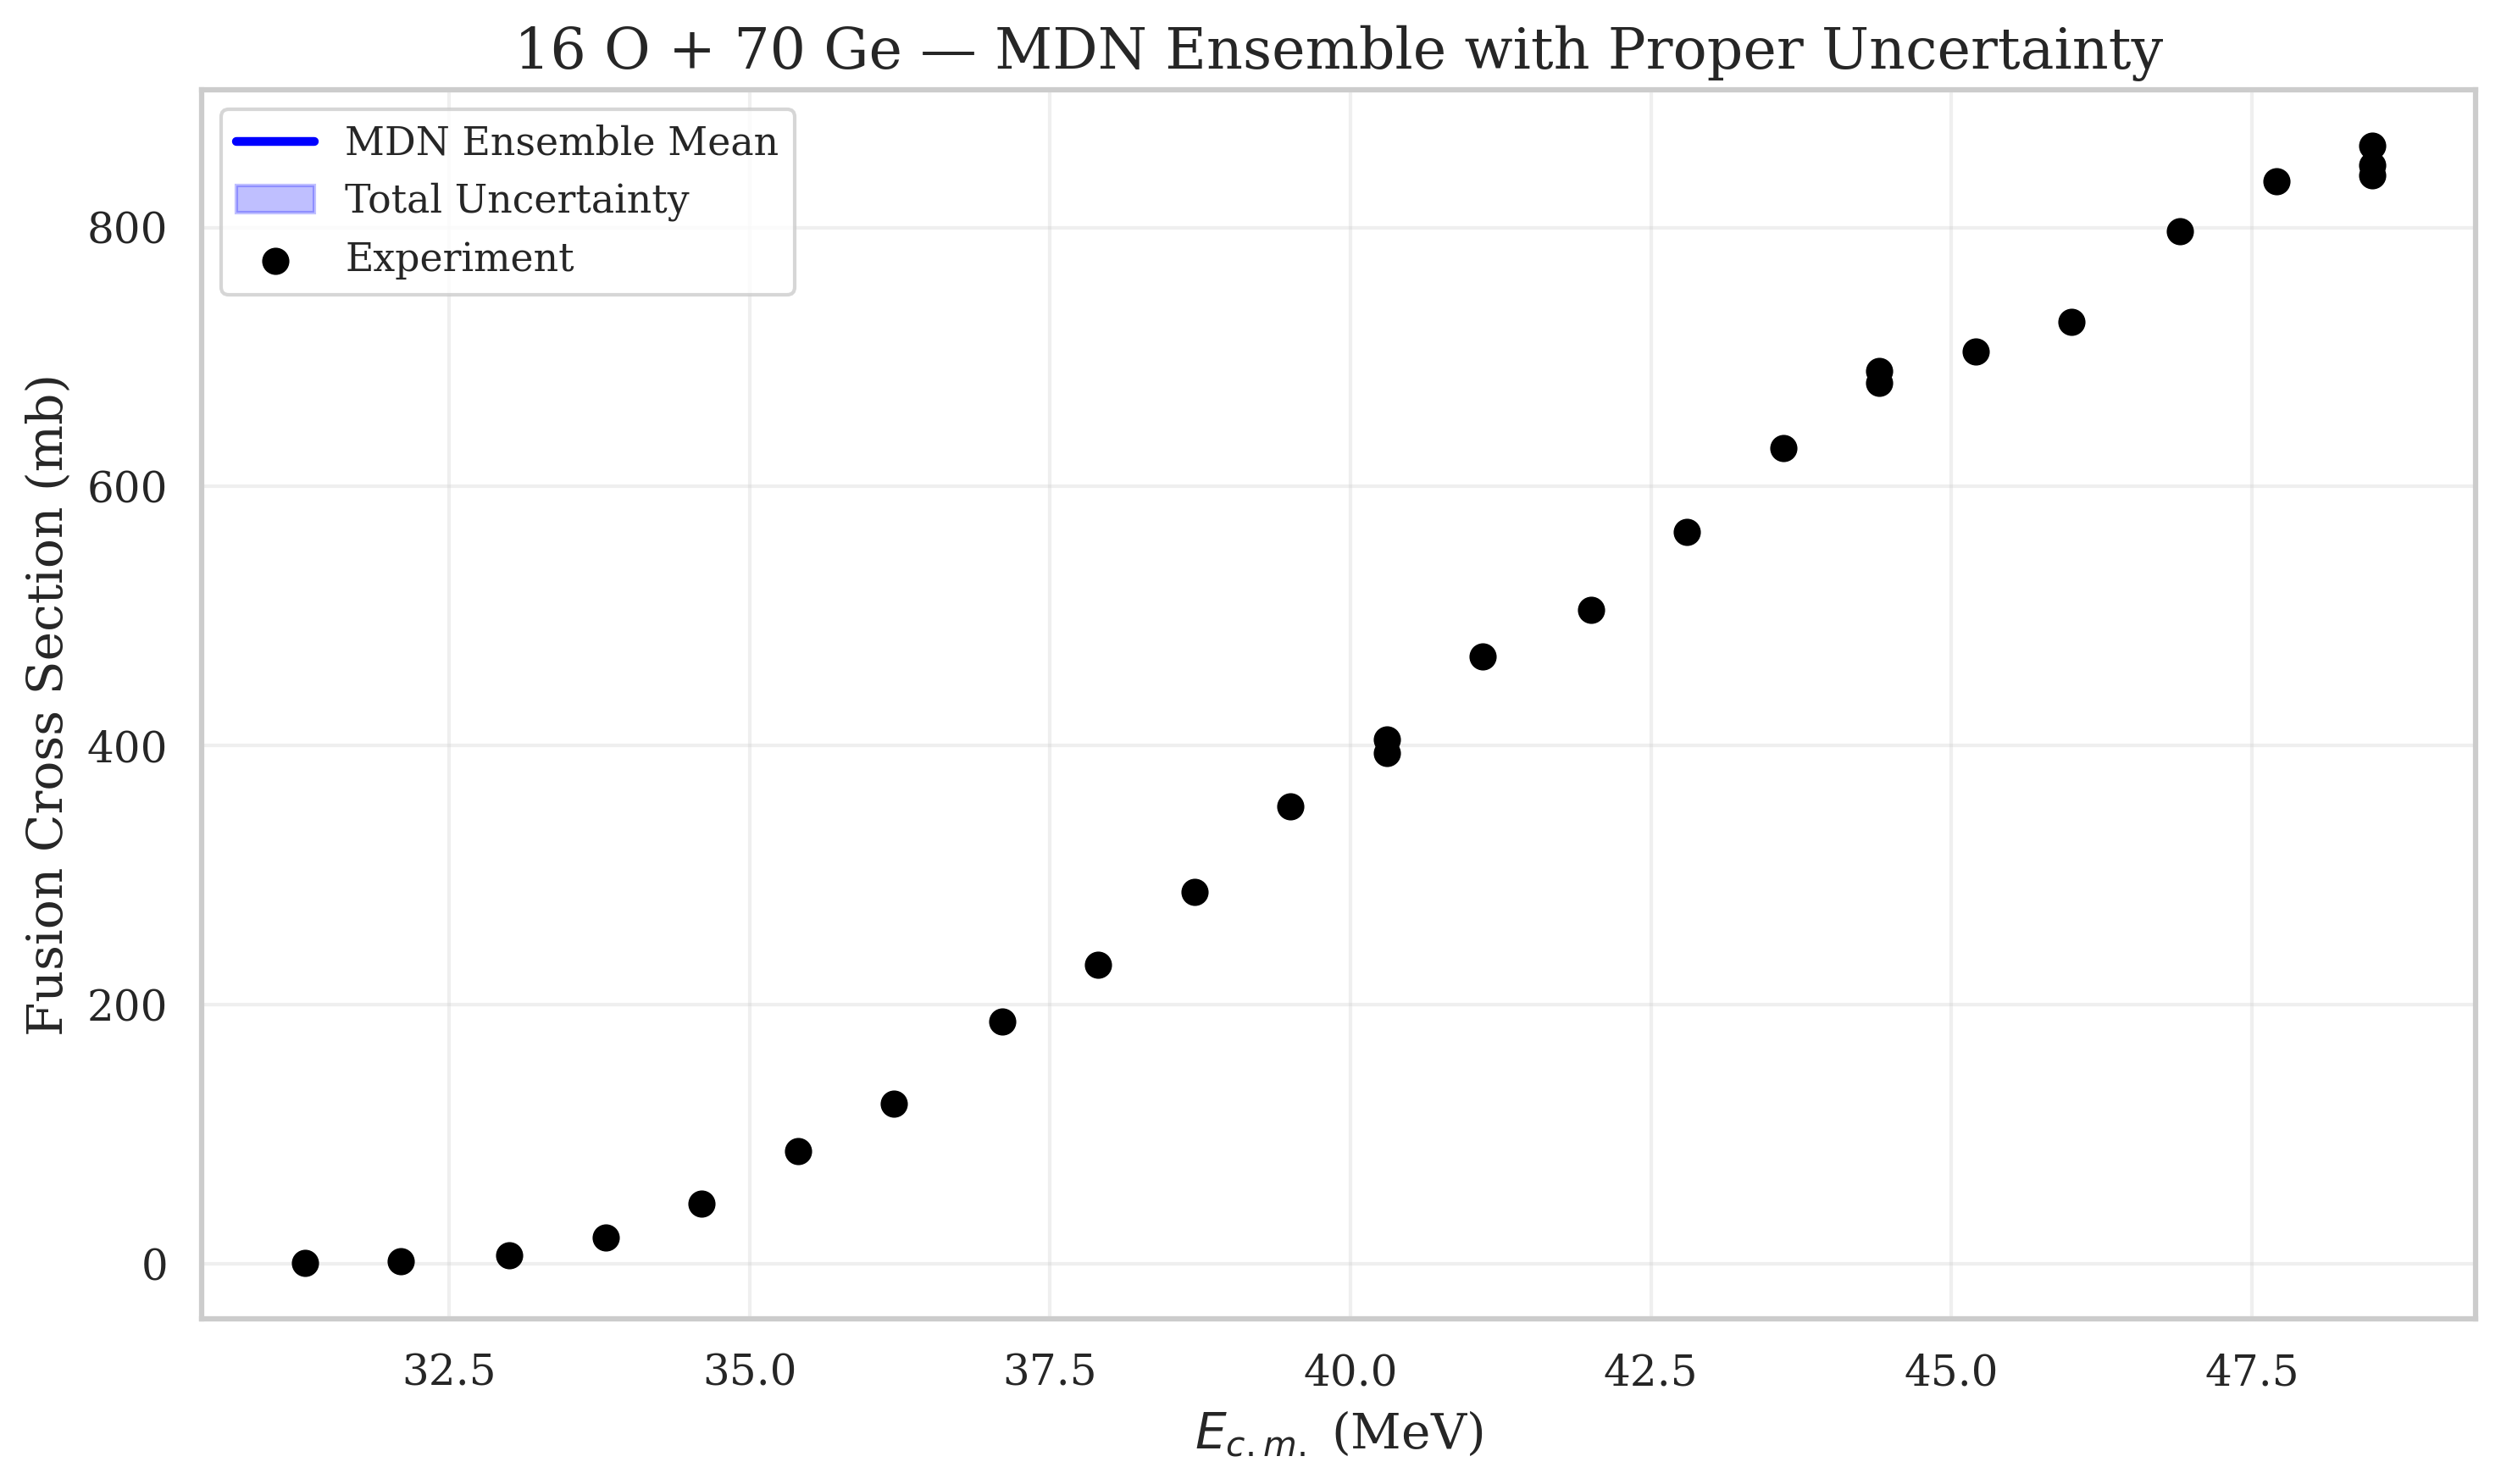

In [33]:
# ============================================================
# FINAL MDN ENSEMBLE PLOT WITH PROPER UNCERTAINTY PROPAGATION
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# Add stable ID for alignment
df = df.reset_index().rename(columns={"index": "ROW_ID"})

# ------------------------------------------------------------
# RECOMPUTE S_cal (same physics as training)
# ------------------------------------------------------------
M_p = 938.272088
M_n = 939.565420
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
mass2 = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)
mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)

Ecm = df["E c.m."]
v_over_c = np.sqrt(np.clip(2*Ecm/(mu+1e-12), 0, np.inf))
eta = (df["Z1"]*df["Z2"]) / ((1/137.035999)*(v_over_c + 1e-12))
df["eta"] = eta

log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_E = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))
df["log10_S_cal"] = log10_sigma_cal + log10_E + (2*np.pi*df["eta"])/LN10

# ------------------------------------------------------------
# LOAD ALL SEED MDN COMPONENTS
# ------------------------------------------------------------
BASE = Path("mdn_70_10_20_optimized/ensembles_fast")

all_pi_seeds = []
all_mu_seeds = []
all_sigma_seeds = []

for seed in range(42, 52):
    file = BASE / f"seed_{seed}" / "mdn_all_components.npz"
    data = np.load(file)

    all_pi_seeds.append(data["pi"])
    all_mu_seeds.append(data["mu"])
    all_sigma_seeds.append(data["sigma"])

all_pi_seeds = np.array(all_pi_seeds)        # (n_seeds, Nrows, K)
all_mu_seeds = np.array(all_mu_seeds)
all_sigma_seeds = np.array(all_sigma_seeds)

n_seeds = all_pi_seeds.shape[0]

# ------------------------------------------------------------
# SELECT REACTION
# ------------------------------------------------------------
reaction = "16 O + 70 Ge"   # CHANGE IF NEEDED
df_r = df[df["Reaction"] == reaction].copy()

if len(df_r) == 0:
    raise ValueError("Reaction not found.")

row_ids = df_r["ROW_ID"].values
energies = df_r["E c.m."].values
sigma_exp = df_r["σ"].values
log10_S_cal_r = df_r["log10_S_cal"].values

# ------------------------------------------------------------
# COMPUTE MIXTURE MEAN + UNCERTAINTY
# ------------------------------------------------------------
mu_mix_all = []
var_aleatoric_all = []

for s in range(n_seeds):
    pi = all_pi_seeds[s][row_ids]
    mu = all_mu_seeds[s][row_ids]
    sigma = all_sigma_seeds[s][row_ids]

    # mixture mean
    mu_mix = np.sum(pi * mu, axis=1)
    mu_mix_all.append(mu_mix)

    # aleatoric variance: Σ π σ²
    var_aleatoric = np.sum(pi * (sigma**2), axis=1)
    var_aleatoric_all.append(var_aleatoric)

mu_mix_all = np.vstack(mu_mix_all)
var_aleatoric_all = np.vstack(var_aleatoric_all)

# epistemic variance = variance across seeds of mixture mean
var_epistemic = np.var(mu_mix_all, axis=0)

# aleatoric variance = mean across seeds
var_aleatoric = np.mean(var_aleatoric_all, axis=0)

# total variance
var_total = var_aleatoric + var_epistemic
std_total = np.sqrt(var_total)

# ensemble mean in log-space
delta_logS_mean = np.mean(mu_mix_all, axis=0)

# ------------------------------------------------------------
# CONVERT TO CROSS SECTION SPACE (CORRECT PROPAGATION)
# ------------------------------------------------------------
log10_S_pred = log10_S_cal_r + delta_logS_mean

sigma_mean = 10 ** log10_S_pred
sigma_upper = 10 ** (log10_S_pred + std_total)
sigma_lower = 10 ** (log10_S_pred - std_total)

# ------------------------------------------------------------
# DEBUG CHECK
# ------------------------------------------------------------
print("Mean epistemic std:", np.mean(np.sqrt(var_epistemic)))
print("Mean aleatoric std:", np.mean(np.sqrt(var_aleatoric)))
print("Mean total std:", np.mean(std_total))

# ------------------------------------------------------------
# PLOT
# ------------------------------------------------------------
plt.figure(figsize=(10,6))

plt.plot(energies, sigma_mean, color="blue", lw=2.5, label="MDN Ensemble Mean")

plt.fill_between(
    energies,
    sigma_lower,
    sigma_upper,
    color="blue",
    alpha=0.25,
    label="Total Uncertainty"
)

plt.scatter(energies, sigma_exp, s=45, color="black", label="Experiment")

plt.ylabel("log10(Fusion Cross Section)")
plt.plot(energies, np.log10(sigma_mean))
plt.fill_between(energies,
                 np.log10(sigma_lower),
                 np.log10(sigma_upper))

plt.grid(True, which="both", alpha=0.3)

plt.xlabel(r"$E_{c.m.}$ (MeV)", fontsize=14)
plt.ylabel("Fusion Cross Section (mb)", fontsize=14)
plt.title(f"{reaction} — MDN Ensemble with Proper Uncertainty", fontsize=16)

plt.legend()
plt.tight_layout()

plt.savefig("mdn_final_cs_plot_corrected.png", dpi=300)
plt.show()


In [34]:
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")
print(df.columns.tolist())


['E c.m.', 'σ', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 'Z3', 'N3', 'A3', 'σ cal', 'β P', 'β T', 'R B', 'ħ ω', 'Q ( 2 n )', 'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual', 'Compound_Nucleus_Sp', 'Compound_Nucleus_Sn', 'Projectile_Binding_Energy', 'Target_Binding_Energy', 'Compound_Nucleus_Binding_Energy', 'Compound_Nucleus_S2n', 'Compound_Nucleus_S2p', 'Reaction', 'Unnamed: 28']



=== Making prediction band for: 16 O + 144 Sm ===


/tmp/ipykernel_146/1497971975.py:67: RuntimeWarning: overflow encountered in power
  sigma_pred = 10 ** (log10_S_cal + delta_logS_mean)
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


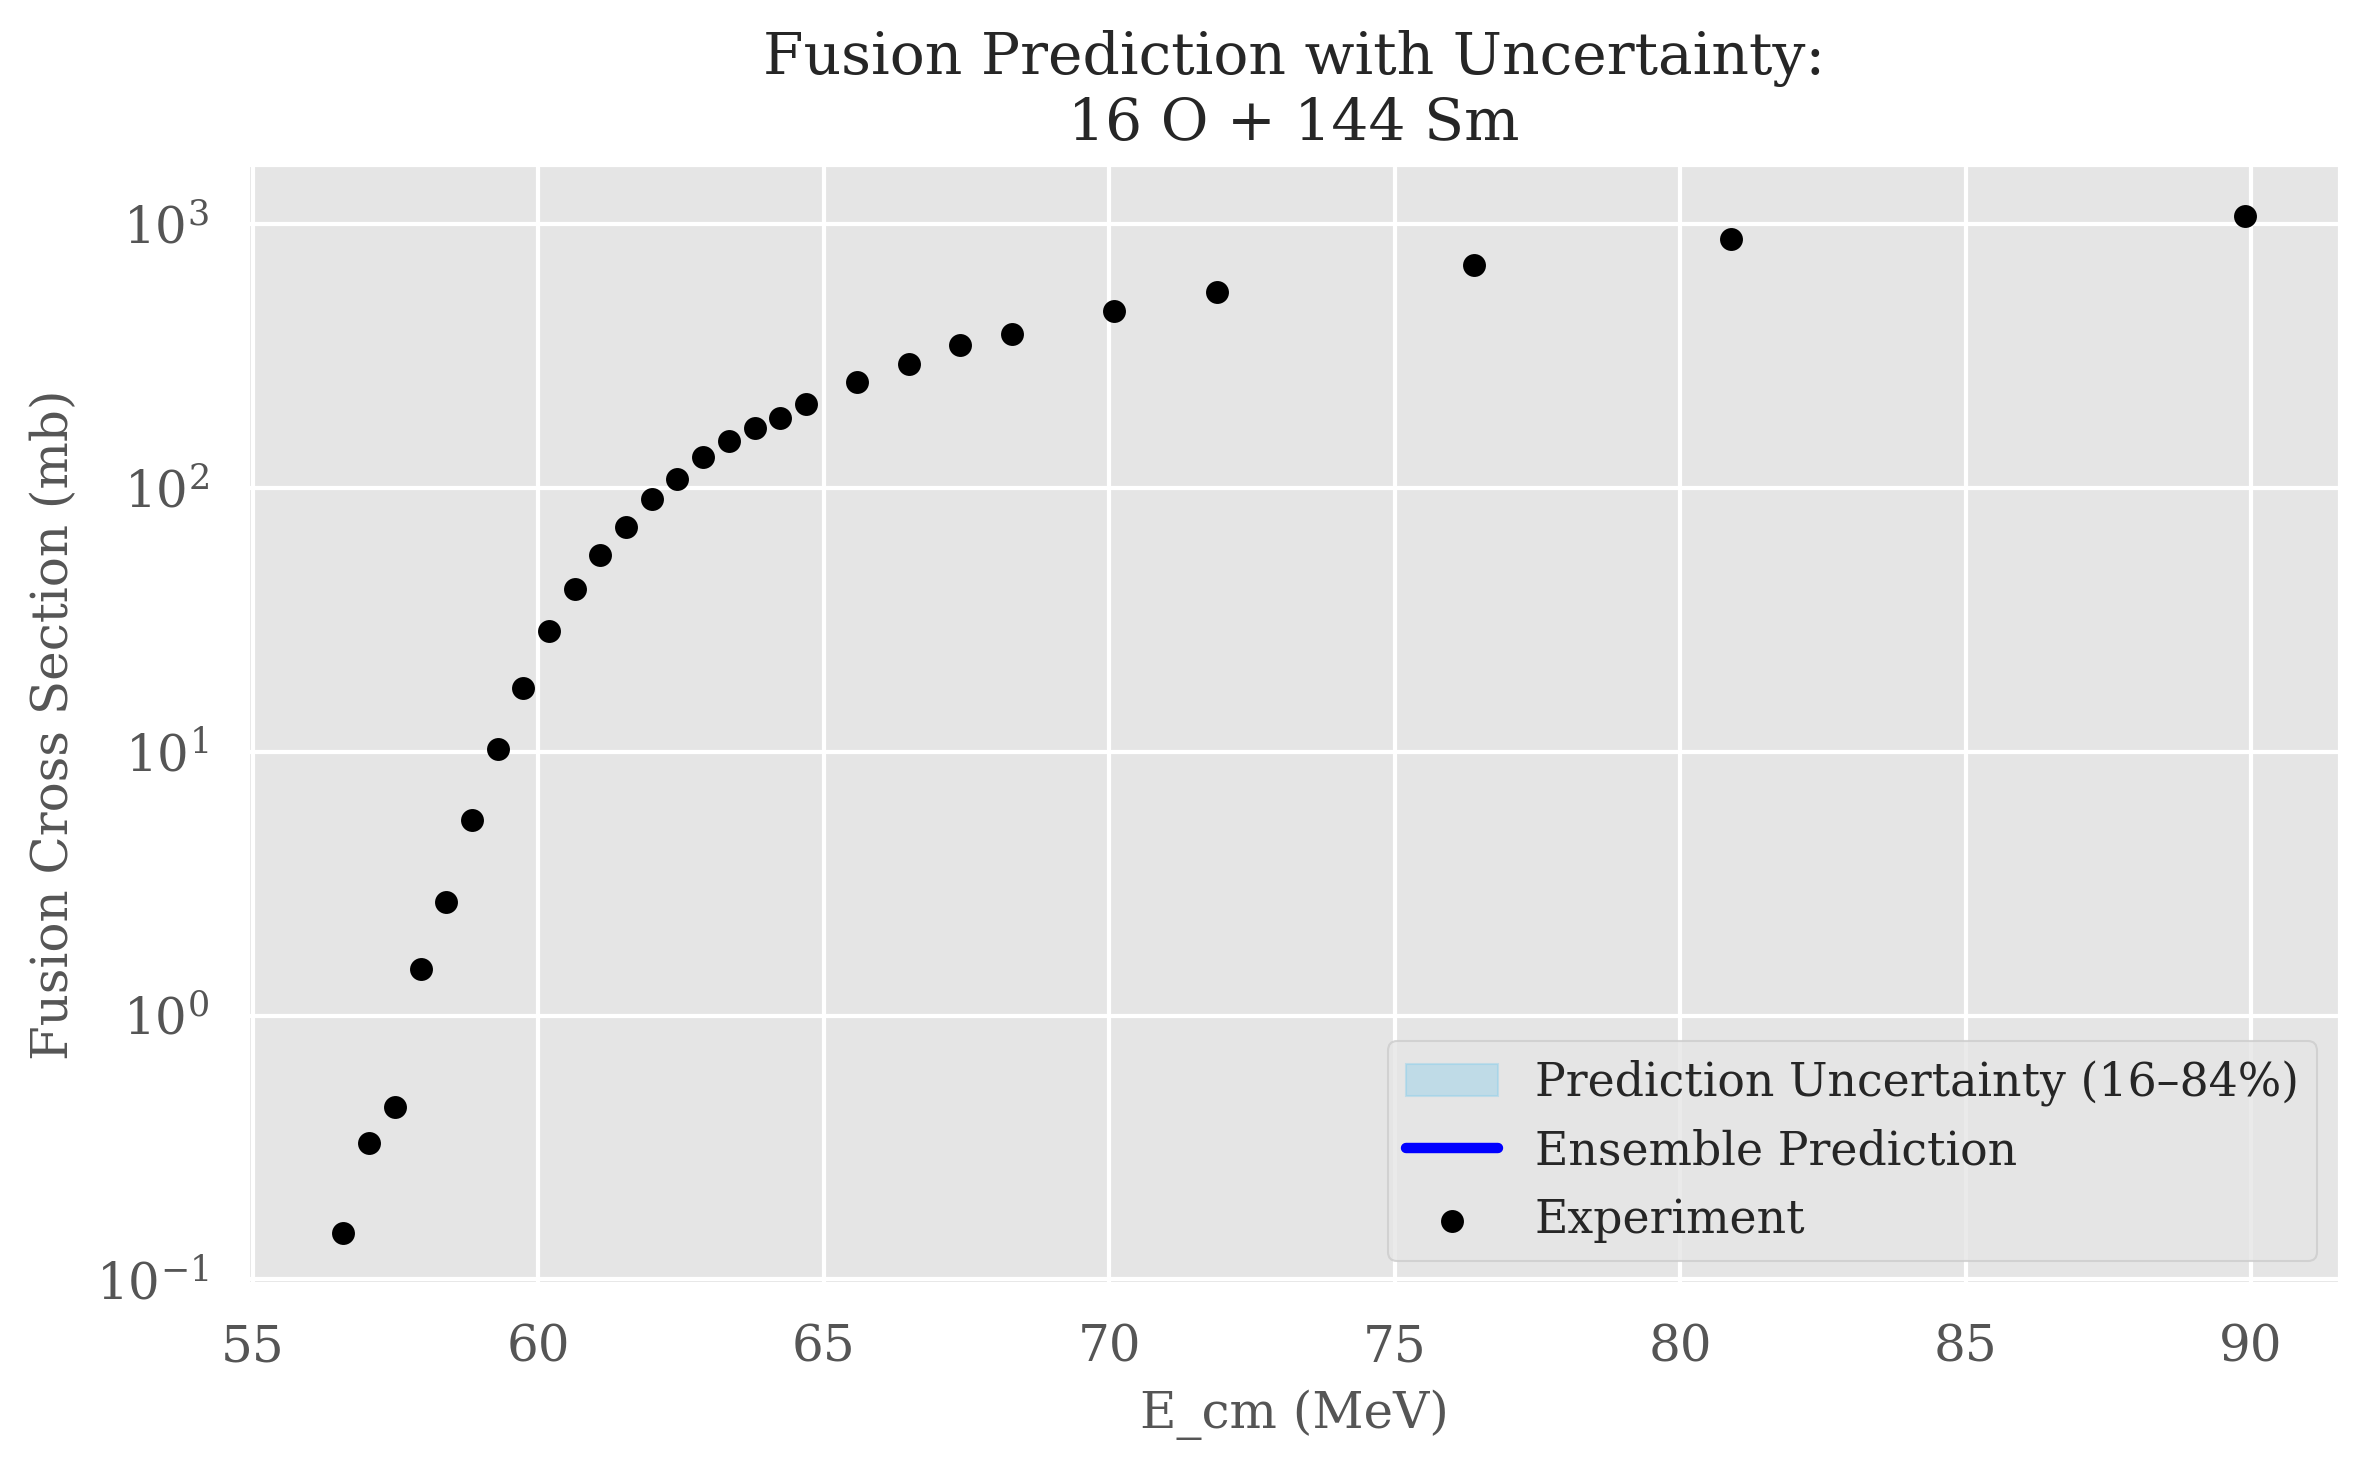

Saved: prediction_band_16O_144Sm.png


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------- LOAD DATA -------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# Compute log10_S_cal for reconstruction
epsilon = 1e-30
ln10 = np.log(10.0)

M_p = 938.272088
M_n = 939.565420

def mass(Z, A):
    return Z*M_p + (A-Z)*M_n

mass1 = mass(df["Z1"], df["A1"])
mass2 = mass(df["Z2"], df["A2"])
mu = (mass1 * mass2) / (mass1 + mass2 + 1e-12)

E = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2 * E / (mu + 1e-12), 0, np.inf))
eta = (df["Z1"] * df["Z2"]) / (1/137.035999 * (v_over_c + 1e-16))

log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_S_cal = log10_sigma_cal + np.log10(np.clip(E, 1e-30, np.inf)) + (2*np.pi*eta)/ln10
df["log10_S_cal"] = log10_S_cal

# ------------------- PLOT FUNCTION -------------------
def plot_prediction_band(reaction_name, save_path):

    print("\n=== Making prediction band for:", reaction_name, "===")

    df_r = df[df["Reaction"] == reaction_name].copy()
    if len(df_r) == 0:
        print("Reaction not found.")
        return

    df_r = df_r.sort_values("E c.m.")
    idx = df_r.index.values
    energies = df_r["E c.m."].values
    log10_S_cal = df_r["log10_S_cal"].values

    # Load MDN components
    BASE = Path("mdn_70_10_20_optimized/ensembles_fast")
    seeds = range(42, 42+10)
    
    all_sigma_pred = []
    all_pi_list = []
    all_mu_list = []
    all_sigma_list = []

    for seed in seeds:
        fn = BASE / f"seed_{seed}" / "mdn_all_components.npz"
        if not fn.exists():
            print("Missing seed:", seed)
            continue

        data = np.load(fn)
        pi = data["pi"][idx]
        mu = data["mu"][idx]
        sigma = data["sigma"][idx]

        delta_logS_mean = np.sum(pi * mu, axis=1)
        sigma_pred = 10 ** (log10_S_cal + delta_logS_mean)

        all_sigma_pred.append(sigma_pred)
        all_pi_list.append(pi)
        all_mu_list.append(mu)
        all_sigma_list.append(sigma)

    all_sigma_pred = np.vstack(all_sigma_pred)
    ensemble_mean = all_sigma_pred.mean(axis=0)
    lower = np.percentile(all_sigma_pred, 16, axis=0)
    upper = np.percentile(all_sigma_pred, 84, axis=0)

    # —————— Plot ——————
    plt.style.use('ggplot')  # safe style
    fig, ax = plt.subplots(figsize=(8,5))

    # Uncertainty band
    ax.fill_between(energies, lower, upper, color='skyblue', alpha=0.4,
                    label="Prediction Uncertainty (16–84%)")

    # Mean prediction
    ax.plot(energies, ensemble_mean, color='blue', lw=2.5, label="Ensemble Prediction")

    # Experimental data
    ax.scatter(energies, df_r["σ"].values, color='black', s=25, label="Experiment")

    ax.set_yscale("log")
    ax.set_xlabel("E_cm (MeV)")
    ax.set_ylabel("Fusion Cross Section (mb)")
    ax.set_title(f"Fusion Prediction with Uncertainty:\n{reaction_name}", fontsize=14)
    ax.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=400)
    plt.show()

    print("Saved:", save_path)


# ------------------- RUN -------------------
plot_prediction_band(
    "16 O + 144 Sm",
    "prediction_band_16O_144Sm.png"
)
